# Competition Solution: Кредитный скоринг

# Решение тестовго технического задания от SHIFT

## Задача бинарной классификации с метрикой ROC-AUC

## 1. Импорт библиотек и настройка

In [2]:
from typing import List, Tuple, Dict, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Модели
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Ансамбли
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Дополнительные
from datetime import datetime
import joblib
import zipfile
import os

# Настройки
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

RANDOM_STATE = 42

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## 2. Загрузка данных

In [3]:
print("Загрузка данных...")
train: pd.DataFrame = pd.read_csv('../data/shift_ml_2026_train.csv')
train

Загрузка данных...


id  сумма_займа срок_займа  процентная_ставка  аннуитет  \
0        68355089  1235000.000     3 года             11.990 41014.000   
1        68341763  1000000.000      5 лет             10.780 21633.000   
2        68426831   597500.000     3 года             13.440 20259.000   
3        68476668  1000000.000     3 года              9.170 31879.000   
4        67275481  1000000.000     3 года              8.490 31563.000   
...           ...          ...        ...                ...       ...   
1210774  89905081   900000.000      5 лет              9.490 18897.500   
1210775  88948836  1470000.000      5 лет             13.990 34197.000   
1210776  89996426  1600000.000      5 лет             14.490 37637.000   
1210777  90006534   800000.000      5 лет             12.790 18117.000   
1210778  88224441  1200000.000      5 лет             14.490 28228.000   

        рейтинг допрейтинг                           профессия_заемщика  \
0             В         В1                                      инженер   
1             Б         Б4                           водитель грузовика   
2             В         В3                          ветеринарный техник   
3             Б         Б2  вице-президент операций по набору персонала   
4             Б         Б1                           дорожному водителю   
...         ...        ...                                          ...   
1210774       Б         Б2                                          NaN   
1210775       В         В3                главный оперативный сотрудник   
1210776       В         В4                         менеджер по продажам   
1210777       В         В1                                     менеджер   
1210778       В         В4                       руководитель программы   

            стаж владение_жильем  годовой_доход  подтвержден_ли_доход  \
0        10+ лет         ИПОТЕКА    1300000.000        Не подтвержден   
1        10+ лет         ИПОТЕКА    1260000.000        Не подтвержден   
2         4 года          АРЕНДА     680000.000  Подтвержден источник   
3        10+ лет         ИПОТЕКА    3600000.000        Не подтвержден   
4        10+ лет         ИПОТЕКА    1700000.000        Не подтвержден   
...          ...             ...            ...                   ...   
1210774    5 лет   СОБСТВЕННОСТЬ    2600000.000        Не подтвержден   
1210775    9 лет         ИПОТЕКА    3615840.000        Не подтвержден   
1210776   3 года         ИПОТЕКА    3140000.000  Подтвержден источник   
1210777  10+ лет          АРЕНДА    3000000.000        Не подтвержден   
1210778    6 лет          АРЕНДА    2200000.000        Не подтвержден   

         итоговый_статус_займа  рейтинг_OCR платежный_график  \
0                            0            4                n   
1                            0            2                n   
2                            0            3                n   
3                            0            1                n   
4                            0            4                n   
...                        ...          ...              ...   
1210774                      0            2                n   
1210775                      0            3                n   
1210776                      1            1                n   
1210777                      0            4                n   
1210778                      1            1                n   

         коэфф_акционных_зачислений_в_остатке                  цель_займа  \
0                                       0.899               мелкий_бизнес   
1                                       0.490  улучшение_жилищных_условий   
2                                       0.939          консолидация_долга   
3                                       0.868          консолидация_долга   
4                                       0.249             крупная_покупка   
...                                       ...                         ...   
1210774                                 

In [4]:
test: pd.DataFrame = pd.read_csv('../data/shift_ml_2026_test.csv')
test

id  сумма_займа срок_займа  процентная_ставка  аннуитет рейтинг  \
0       85540387   450000.000     3 года              9.490 14413.000       Б   
1       28112500   400000.000     3 года              6.030 12174.500       А   
2       65731570  1250000.000     3 года             12.050 41548.000       В   
3       65874747   977500.000      5 лет             20.990 26439.500       Д   
4       57893355   520000.000     3 года             18.250 18865.000       Д   
...          ...          ...        ...                ...       ...     ...   
134526  72082596   280000.000     3 года             13.670  9525.000       В   
134527    484702   700000.000     3 года             10.250 22669.500       Б   
134528  73273241  1500000.000     3 года             12.990 50534.000       В   
134529  50466330  1070000.000     3 года             15.610 37412.500       Г   
134530  46350249   798750.000     3 года             16.990 28474.000       Г   

       допрейтинг                                 профессия_заемщика     стаж  \
0              Б2                              обслуживание клиентов  10+ лет   
1              А1                      помощник по правовым вопросам    5 лет   
2              В1           специалист по анализу кредитоспособности    5 лет   
3              Д5                             специальный специалист   3 года   
4              Д1                     руководитель районного проекта   3 года   
...           ...                                                ...      ...   
134526         В3                              хирургические продажи   4 года   
134527         Б2                              &quot; е2 инк. &quot;   4 года   
134528         В2  сертифицированный сотрудник по финансовому пла...  10+ лет   
134529         Г1                                           владелец  10+ лет   
134530         Г3                                              повар    6 лет   

       владение_жильем  годовой_доход  подтвержден_ли_доход  рейтинг_OCR  \
0              ИПОТЕКА     840000.000        Не подтвержден            4   
1               АРЕНДА    1520000.000        Не подтвержден            4   
2              ИПОТЕКА    1250000.000        Не подтвержден            1   
3              ИПОТЕКА    1020000.000           Подтвержден            4   
4               АРЕНДА    1000000.000           Подтвержден            2   
...                ...            ...                   ...          ...   
134526          АРЕНДА    5200000.000  Подтвержден источник            4   
134527          АРЕНДА    1250000.000        Не подтвержден            4   
134528          АРЕНДА    1600000.000  Подтвержден источник            2   
134529         ИПОТЕКА    1070000.000        Не подтвержден            3   
134530         ИПОТЕКА     800000.000        Не подтвержден            1   

       платежный_график  коэфф_акционных_зачислений_в_остатке  \
0                     n                                 0.459   
1                     n                                 0.007   
2                     n                                 0.485   
3                     n                                 0.309   
4                     n                                 0.250   
...                 ...                                   ...   
134526                n                                 0.156   
134527                n                                 0.900   
134528                n                                 0.813   
134529                n                                 0.653   
134530                n                                 0.530   

                цель_займа  кол_во_субсидий_за_год  индекс_проживания  \
0       консолидация_долга                       0            601.000   
1       консолидация_долга                       0            112.000   
2          кредитная_карта                       2            611.000   
3       консолидация_долга                       0            606.000   
4        

In [5]:
print(f"Размер train: {train.shape}")
print(f"Размер test: {test.shape}")

Размер train: (1210779, 109)
Размер test: (134531, 108)


### Первичный осмотр

In [6]:
print("\nПервые 10 строк train:")
display(train.head(10))


Первые 10 строк train:


id  сумма_займа срок_займа  процентная_ставка  аннуитет рейтинг  \
0  68355089  1235000.000     3 года             11.990 41014.000       В   
1  68341763  1000000.000      5 лет             10.780 21633.000       Б   
2  68426831   597500.000     3 года             13.440 20259.000       В   
3  68476668  1000000.000     3 года              9.170 31879.000       Б   
4  67275481  1000000.000     3 года              8.490 31563.000       Б   
5  68466926   500000.000     3 года              6.490 15322.500       А   
6  68616873   400000.000     3 года             11.480 13187.000       Б   
7  68338832    70000.000     3 года             12.880  2355.000       В   
8  66624733   900000.000      5 лет             19.480 23585.000       Д   
9  68466961  1400000.000     3 года              6.490 42902.500       А   

  допрейтинг                                 профессия_заемщика     стаж  \
0         В1                                            инженер  10+ лет   
1         Б4                                 водитель грузовика  10+ лет   
2         В3                                ветеринарный техник   4 года   
3         Б2        вице-президент операций по набору персонала  10+ лет   
4         Б1                                 дорожному водителю  10+ лет   
5         А2                                управление услугами    6 лет   
6         Б5                               связь с поставщиками  10+ лет   
7         В2  руководитель материально-технического обеспечения   3 года   
8         Д2                  менеджер программного обеспечения    7 лет   
9         А2                               старший руководитель  10+ лет   

  владение_жильем  годовой_доход  подтвержден_ли_доход  итоговый_статус_займа  \
0         ИПОТЕКА    1300000.000        Не подтвержден                      0   
1         ИПОТЕКА    1260000.000        Не подтвержден                      0   
2          АРЕНДА     680000.000  Подтвержден источник                      0   
3         ИПОТЕКА    3600000.000        Не подтвержден                      0   
4         ИПОТЕКА    1700000.000        Не подтвержден                      0   
5          АРЕНДА    1700000.000        Не подтвержден                      0   
6         ИПОТЕКА     840000.000        Не подтвержден                      0   
7         ИПОТЕКА    1280000.000        Не подтвержден                      0   
8          АРЕНДА    3000000.000        Не подтвержден                      1   
9         ИПОТЕКА    1840000.000        Не подтвержден                      0   

   рейтинг_OCR платежный_график  коэфф_акционных_зачислений_в_остатке  \
0            4                n                                 0.899   
1            2                n                                 0.490   
2            3                n                                 0.939   
3            1                n                                 0.868   
4            4                n                                 0.249   
5            2                n                                 0.373   
6            3                n                                 0.334   
7            1                n                                 0.060   
8            3                n                                 0.718   
9            2                n                                 0.905   

                   цель_займа  кол_во_субсидий_за_год  индекс_проживания  \
0               мелкий_бизнес                       0            577.000   
1  улучшение_жилищных_условий                       0            605.000   
2          консолидация_долга                       0            300.000   
3          консолидация_долга                       0            550.000   
4             крупная_покупка                       0            293.000   
5             кредитная_карта                       0            160.000   
6             кредитная_карта                       0             29.000   
7                      другое  

In [7]:
print("\nИнформация о данных train:")
train.info()


Информация о данных train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


In [8]:
print("\nПервые 10 строк test:")
display(test.head(10))


Первые 10 строк test:


id  сумма_займа срок_займа  процентная_ставка  аннуитет рейтинг  \
0  85540387   450000.000     3 года              9.490 14413.000       Б   
1  28112500   400000.000     3 года              6.030 12174.500       А   
2  65731570  1250000.000     3 года             12.050 41548.000       В   
3  65874747   977500.000      5 лет             20.990 26439.500       Д   
4  57893355   520000.000     3 года             18.250 18865.000       Д   
5  80589347  1000000.000     3 года             14.460 34401.500       В   
6  36381174  1750000.000     3 года             10.490 56871.500       Б   
7    624831   320000.000      5 лет             15.570  7709.000       Г   
8  44065675   493750.000     3 года             15.610 17264.000       Г   
9    771518  1062500.000      5 лет             12.990 24170.000       В   

  допрейтинг                        профессия_заемщика      стаж  \
0         Б2                     обслуживание клиентов   10+ лет   
1         А1             помощник по правовым вопросам     5 лет   
2         В1  специалист по анализу кредитоспособности     5 лет   
3         Д5                    специальный специалист    3 года   
4         Д1            руководитель районного проекта    3 года   
5         В4                                   инженер     5 лет   
6         Б3                    управляющий контрактом  < 1 года   
7         Г5                         очищенные бридеры     1 год   
8         Г1                           видеопереводчик    3 года   
9         В1                                       NaN       NaN   

  владение_жильем  годовой_доход  подтвержден_ли_доход  рейтинг_OCR  \
0         ИПОТЕКА     840000.000        Не подтвержден            4   
1          АРЕНДА    1520000.000        Не подтвержден            4   
2         ИПОТЕКА    1250000.000        Не подтвержден            1   
3         ИПОТЕКА    1020000.000           Подтвержден            4   
4          АРЕНДА    1000000.000           Подтвержден            2   
5          АРЕНДА    2200000.000  Подтвержден источник            2   
6         ИПОТЕКА    2600000.000           Подтвержден            4   
7          АРЕНДА     540000.000        Не подтвержден            3   
8         ИПОТЕКА     820000.000        Не подтвержден            3   
9         ИПОТЕКА     834000.000           Подтвержден            1   

  платежный_график  коэфф_акционных_зачислений_в_остатке          цель_займа  \
0                n                                 0.459  консолидация_долга   
1                n                                 0.007  консолидация_долга   
2                n                                 0.485     кредитная_карта   
3                n                                 0.309  консолидация_долга   
4                n                                 0.250             переезд   
5                n                                 0.003       мелкий_бизнес   
6                n                                 0.877  консолидация_долга   
7                n                                 0.615  консолидация_долга   
8                n                                 0.185  консолидация_долга   
9                n                                 0.121              другое   

   кол_во_субсидий_за_год  индекс_проживания  \
0                       0            601.000   
1                       0            112.000   
2                       2            611.000   
3                       0            606.000   
4                       0            605.000   
5                       0            907.000   
6                       0            337.000   
7                       0            330.000   
8                       0            282.000   
9                       0            487.000   

                              регион    пдн пос_стоп_фактор  \
0               Республика Татарстан 19.090             Нет   
1              Новосибирская область 20.420             Нет   
2               Республика Татарстан 15.61

In [9]:
print("\nИнформация о данных test:")
test.info()


Информация о данных test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


## 3. EDA - Анализ данных

### Анализ целевой переменной

In [10]:
target_col: str = 'итоговый_статус_займа'
print(f"\nРаспределение целевой переменной '{target_col}':")
target_dist: pd.Series = train[target_col].value_counts(normalize=True)
print(target_dist)


Распределение целевой переменной 'итоговый_статус_займа':
итоговый_статус_займа
0   0.800
1   0.200
Name: proportion, dtype: float64


### График для анализа результатов целевой переменной

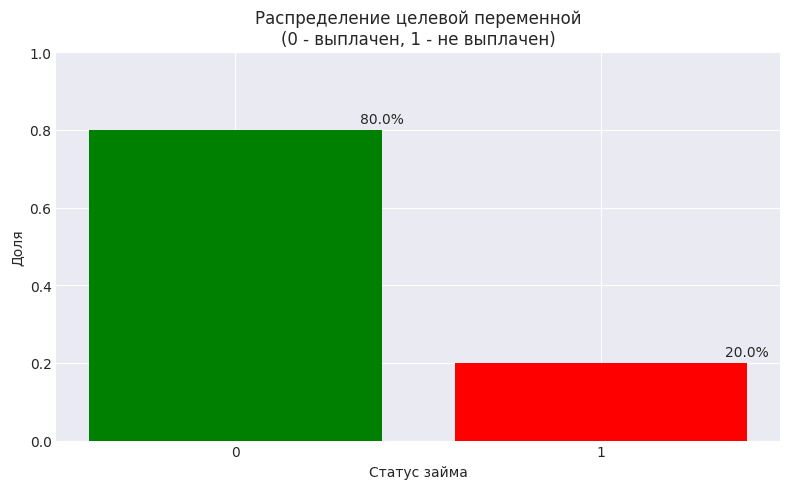

In [11]:
plt.figure(figsize=(8, 5))
bars = plt.bar(target_dist.index.astype(str), target_dist.values, color=['green', 'red'])
plt.title('Распределение целевой переменной\n(0 - выплачен, 1 - не выплачен)')
plt.xlabel('Статус займа')
plt.ylabel('Доля')
plt.ylim(0, 1)
for bar, value in zip(bars, target_dist.values):
    plt.text(bar.get_x() + bar.get_width(), bar.get_height() + 0.01, 
             f'{value:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Анализ пропусков

In [12]:
print("\nАнализ пропусков в данных:")

def analyze_missing(
    df: pd.DataFrame, 
    dataset_name: str
) -> pd.DataFrame:
    missing: pd.Series = df.isnull().sum()
    missing_pct: pd.Series = (missing / len(df)) * 100
    missing_df: pd.DataFrame = pd.DataFrame({
        'missing_count': missing,
        'missing_percent': missing_pct
    }).sort_values('missing_percent', ascending=False)
    
    missing_df: pd.DataFrame = missing_df[missing_df['missing_count'] > 0]
    
    print(f"\n{dataset_name} - колонки с пропусками ({len(missing_df)}):")
    if len(missing_df) > 0:
        display(missing_df.head(20))
        if len(missing_df) > 0:
            plt.figure(figsize=(12, 6))
            missing_df.head(20)['missing_percent'].plot(kind='bar')
            plt.title(f'Топ-20 признаков с пропусками ({dataset_name})')
            plt.ylabel('Процент пропусков')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("Пропусков нет!")
    return missing_df


Анализ пропусков в данных:



Train - колонки с пропусками (69):


missing_count  \
дата_следующей_выплаты                                    1210779   
кредитный_баланс_по_возоб_счетам                          1193971   
совокупный_статус_подтверждения_доходов_заемщиков         1187729   
совокупный_пдн_заемщиков                                  1187548   
совокупный_доход_заемщиков                                1187546   
кол-во_месяцев_с_последнего_займа                         1005117   
кол-во_мес_с_последней_задолженности_по_карте              923517   
кол-во_месяцев_с_последнего_нарушения                      892120   
кол-во_мес_с_последней_задолженности_по_возобно...         805599   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...         792391   
кол-во_месяцев_с_посл_аннуитетного_счета                   739709   
соотношение_баланса_к_лимиту_общее                         726952   
кол-во_финансовых_операций                                 726902   
кол-во_открытых_счетов_за_полгода                          726902   
кол-во_заявок_на_кредит_за_год                             726902   
текущий_баланс_по_аннуитетным_счетам                       726901   
кол-во_возоб_счетов_за_год                                 726901   
макс_баланс_по_возоб_счетам                                726901   
кол-во_возоб_счетов_за_2_года                              726901   
кол-во_аннуитетных_счетов_за_год                           726901   

                                                    missing_percent  
дата_следующей_выплаты                                      100.000  
кредитный_баланс_по_возоб_счетам                             98.612  
совокупный_статус_подтверждения_доходов_заемщиков            98.096  
совокупный_пдн_заемщиков                                     98.081  
совокупный_доход_заемщиков                                   98.081  
кол-во_месяцев_с_последнего_займа                            83.014  
кол-во_мес_с_последней_задолженности_по_карте                76.275  
кол-во_месяцев_с_последнего_нарушения                        73.681  
кол-во_мес_с_последней_задолженности_по_возобно...           66.536  
соотношение_сумм_текущего_баланса_к_лимиту_по_а...           65.445  
кол-во_месяцев_с_посл_аннуитетного_счета                     61.094  
соотношение_баланса_к_лимиту_общее                           60.040  
кол-во_финансовых_операций                                   60.036  
кол-во_открытых_счетов_за_полгода                            60.036  
кол-во_заявок_на_кредит_за_год                               60.036  
текущий_баланс_по_аннуитетным_счетам                         60.036  
кол-во_возоб_счетов_за_год                                   60.036  
макс_баланс_по_возоб_счетам                                  60.036  
кол-во_возоб_счетов_за_2_года                                60.036  
кол-во_аннуитетных_счетов_за_год                             60.036

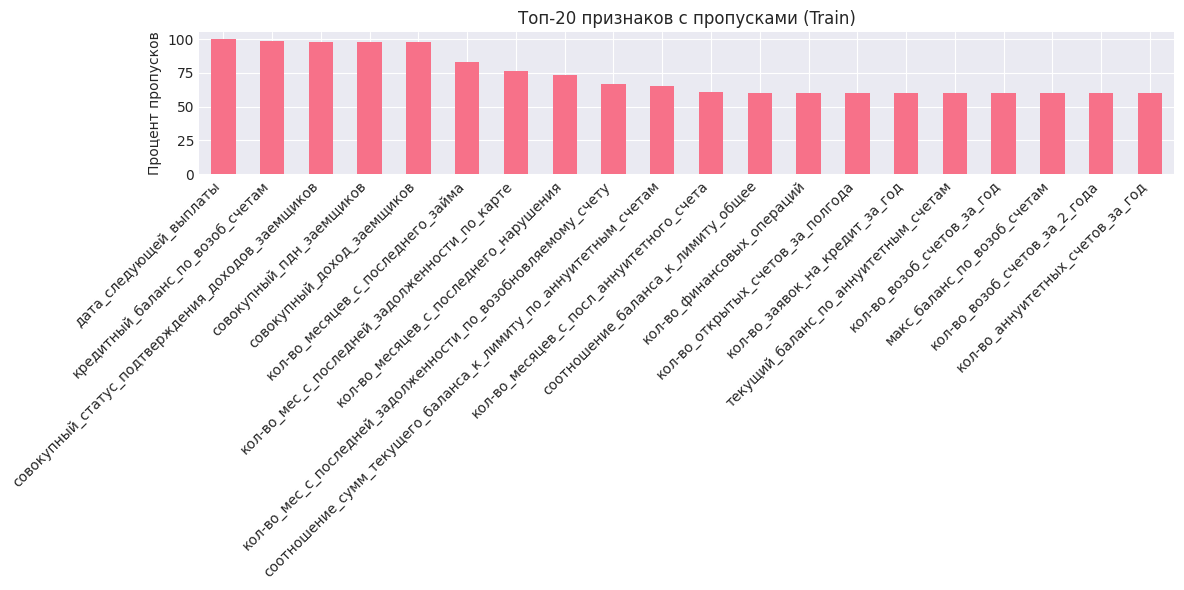

missing_count  \
дата_следующей_выплаты                                    1210779   
кредитный_баланс_по_возоб_счетам                          1193971   
совокупный_статус_подтверждения_доходов_заемщиков         1187729   
совокупный_пдн_заемщиков                                  1187548   
совокупный_доход_заемщиков                                1187546   
кол-во_месяцев_с_последнего_займа                         1005117   
кол-во_мес_с_последней_задолженности_по_карте              923517   
кол-во_месяцев_с_последнего_нарушения                      892120   
кол-во_мес_с_последней_задолженности_по_возобно...         805599   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...         792391   
кол-во_месяцев_с_посл_аннуитетного_счета                   739709   
соотношение_баланса_к_лимиту_общее                         726952   
кол-во_финансовых_операций                                 726902   
кол-во_открытых_счетов_за_полгода                          726902   
кол-во_заявок_на_кредит_за_год                             726902   
текущий_баланс_по_аннуитетным_счетам                       726901   
кол-во_возоб_счетов_за_год                                 726901   
макс_баланс_по_возоб_счетам                                726901   
кол-во_возоб_счетов_за_2_года                              726901   
кол-во_аннуитетных_счетов_за_год                           726901   
кол-во_финансовых_запросов                                 726901   
кол-во_аннуитетных_счетов_за_2_года                        726901   
кол-во_текущих_аннуитетных_счетов                          726901   
кол-во_месяцев_с_последней_просрочки                       610561   
пени_за_дефолт                                             363441   
кол-во_мес_с_последней_заявки                              156537   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес             105517   
кол-во_месяцев_с_первого_аннуитетного_счета                 95020   
профессия_заемщика                                          77049   
стаж                                                        70508   
процент_счетов_без_просрочек                                60902   
средний_баланс_текущих_счетов                               60788   
кол-во_возобновляемых_счетов                                60768   
кол-во_месяцев_с_первого_возобновляемого_счета              60768   
кол-во_месяцев_с_последнего_возобновляемого_счета           60768   
общая_сумма_взысканий                                       60767   
общая_сумма_на_счетах                                       60767   
кол-во_открытых_возобновляемых_счетов                       60767   
общий_лимит_по_возоб_счету                                  60767   
кол-во_месяцев_с_последнего_счета                           60767   
кол-во_счетов_с_акт_просрочкой_1_мес                        60767   
кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года              60767   
кредитный_лимит                                             60767   
лимит_по_аннуитетным_счетам                                 60767   
кол-во_счетов_за_посл_год                                   60767   
кол-во_возобновляемых_счетов_с_балансом_более_0             60767   
кол-во_аннуитетных_счетов                                   60767   
кол-во_карт                                                 60767   
кол-во_активных_возобновляемых_счетов                       60767   
кол-во_активных_карт                                        60767   
кол-во_счетов_с_просрочкой_4_мес                            60767   
соотношение_баланса_к_лимиту_по_картам                      55663   
процент_счетов_прев_75_лимита                               55331   
суммарная_доступная_сумма_займа_по_картам                   54971   
кол-во_месяцев_с_последней_карты                            54130   
кол-во_счетов_без_нарушений                                 50207   
кол-во_карт_без_нарушений                                   50207   
кол-во_открытых_счетов_за_2_года                  

In [13]:
missing_train: pd.DataFrame = analyze_missing(train, 'Train')
missing_train


Test - колонки с пропусками (67):


missing_count  \
дата_следующей_выплаты                                     134531   
пени_за_дефолт                                             134531   
кредитный_баланс_по_возоб_счетам                           132710   
совокупный_статус_подтверждения_доходов_заемщиков          131986   
совокупный_пдн_заемщиков                                   131965   
совокупный_доход_заемщиков                                 131964   
кол-во_месяцев_с_последнего_займа                          111638   
кол-во_мес_с_последней_задолженности_по_карте              102773   
кол-во_месяцев_с_последнего_нарушения                       99440   
кол-во_мес_с_последней_задолженности_по_возобно...          89749   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...          87903   
кол-во_месяцев_с_посл_аннуитетного_счета                    82219   
соотношение_баланса_к_лимиту_общее                          80813   
кол-во_открытых_счетов_за_полгода                           80811   
кол-во_аннуитетных_счетов_за_год                            80811   
кол-во_текущих_аннуитетных_счетов                           80811   
кол-во_финансовых_запросов                                  80811   
кол-во_финансовых_операций                                  80811   
текущий_баланс_по_аннуитетным_счетам                        80811   
макс_баланс_по_возоб_счетам                                 80811   

                                                    missing_percent  
дата_следующей_выплаты                                      100.000  
пени_за_дефолт                                              100.000  
кредитный_баланс_по_возоб_счетам                             98.646  
совокупный_статус_подтверждения_доходов_заемщиков            98.108  
совокупный_пдн_заемщиков                                     98.093  
совокупный_доход_заемщиков                                   98.092  
кол-во_месяцев_с_последнего_займа                            82.983  
кол-во_мес_с_последней_задолженности_по_карте                76.394  
кол-во_месяцев_с_последнего_нарушения                        73.916  
кол-во_мес_с_последней_задолженности_по_возобно...           66.713  
соотношение_сумм_текущего_баланса_к_лимиту_по_а...           65.340  
кол-во_месяцев_с_посл_аннуитетного_счета                     61.115  
соотношение_баланса_к_лимиту_общее                           60.070  
кол-во_открытых_счетов_за_полгода                            60.069  
кол-во_аннуитетных_счетов_за_год                             60.069  
кол-во_текущих_аннуитетных_счетов                            60.069  
кол-во_финансовых_запросов                                   60.069  
кол-во_финансовых_операций                                   60.069  
текущий_баланс_по_аннуитетным_счетам                         60.069  
макс_баланс_по_возоб_счетам                                  60.069

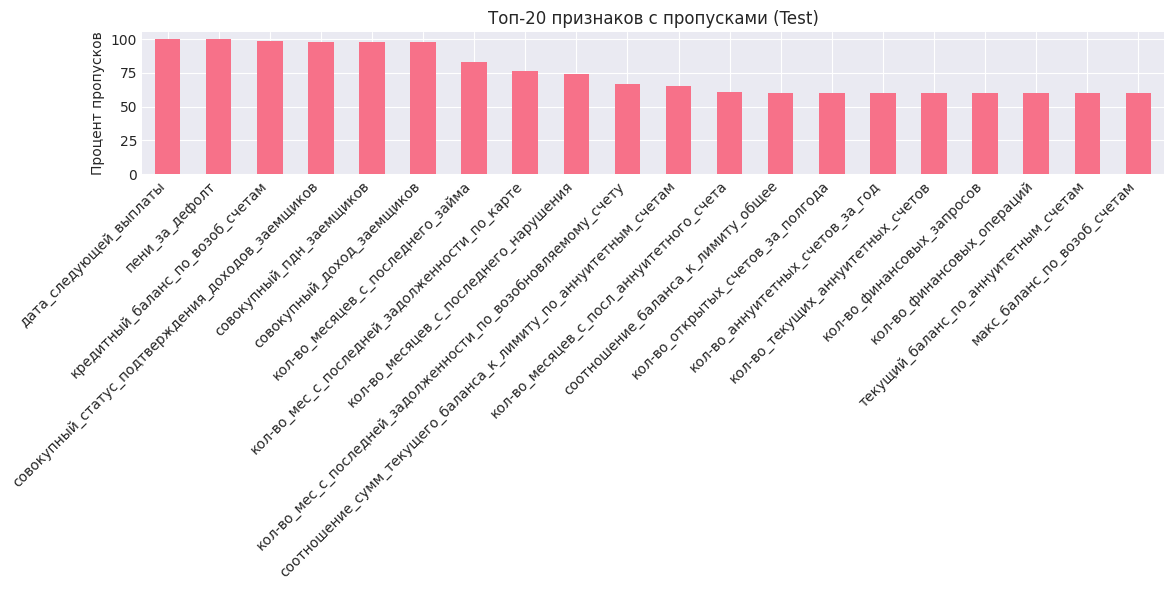

missing_count  \
дата_следующей_выплаты                                     134531   
пени_за_дефолт                                             134531   
кредитный_баланс_по_возоб_счетам                           132710   
совокупный_статус_подтверждения_доходов_заемщиков          131986   
совокупный_пдн_заемщиков                                   131965   
совокупный_доход_заемщиков                                 131964   
кол-во_месяцев_с_последнего_займа                          111638   
кол-во_мес_с_последней_задолженности_по_карте              102773   
кол-во_месяцев_с_последнего_нарушения                       99440   
кол-во_мес_с_последней_задолженности_по_возобно...          89749   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...          87903   
кол-во_месяцев_с_посл_аннуитетного_счета                    82219   
соотношение_баланса_к_лимиту_общее                          80813   
кол-во_открытых_счетов_за_полгода                           80811   
кол-во_аннуитетных_счетов_за_год                            80811   
кол-во_текущих_аннуитетных_счетов                           80811   
кол-во_финансовых_запросов                                  80811   
кол-во_финансовых_операций                                  80811   
текущий_баланс_по_аннуитетным_счетам                        80811   
макс_баланс_по_возоб_счетам                                 80811   
кол-во_аннуитетных_счетов_за_2_года                         80811   
кол-во_возоб_счетов_за_год                                  80811   
кол-во_возоб_счетов_за_2_года                               80811   
кол-во_заявок_на_кредит_за_год                              80811   
кол-во_месяцев_с_последней_просрочки                        68182   
кол-во_мес_с_последней_заявки                               17534   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес              11884   
кол-во_месяцев_с_первого_аннуитетного_счета                 10555   
профессия_заемщика                                           8736   
стаж                                                         8003   
процент_счетов_без_просрочек                                 6779   
средний_баланс_текущих_счетов                                6761   
общий_лимит_по_возоб_счету                                   6760   
кол-во_месяцев_с_последнего_возобновляемого_счета            6760   
кол-во_месяцев_с_последнего_счета                            6760   
общая_сумма_на_счетах                                        6760   
кол-во_возобновляемых_счетов                                 6760   
кол-во_месяцев_с_первого_возобновляемого_счета               6760   
общая_сумма_взысканий                                        6760   
кол-во_счетов_с_акт_просрочкой_1_мес                         6760   
кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года               6760   
кредитный_лимит                                              6760   
лимит_по_аннуитетным_счетам                                  6760   
кол-во_счетов_за_посл_год                                    6760   
кол-во_возобновляемых_счетов_с_балансом_более_0              6760   
кол-во_открытых_возобновляемых_счетов                        6760   
кол-во_карт                                                  6760   
кол-во_аннуитетных_счетов                                    6760   
кол-во_активных_возобновляемых_счетов                        6760   
кол-во_счетов_с_просрочкой_4_мес                             6760   
кол-во_активных_карт                                         6760   
соотношение_баланса_к_лимиту_по_картам                       6249   
процент_счетов_прев_75_лимита                                6224   
суммарная_доступная_сумма_займа_по_картам                    6172   
кол-во_месяцев_с_последней_карты                             6091   
кол-во_счетов_без_нарушений                                  5634   
кол-во_карт_без_нарушений                                    5634   
кол-во_открытых_счетов_за_2_года                  

In [14]:
missing_test: pd.DataFrame = analyze_missing(test, 'Test')
missing_test

### Анализ ключевых признаков

### Финансовые фичи

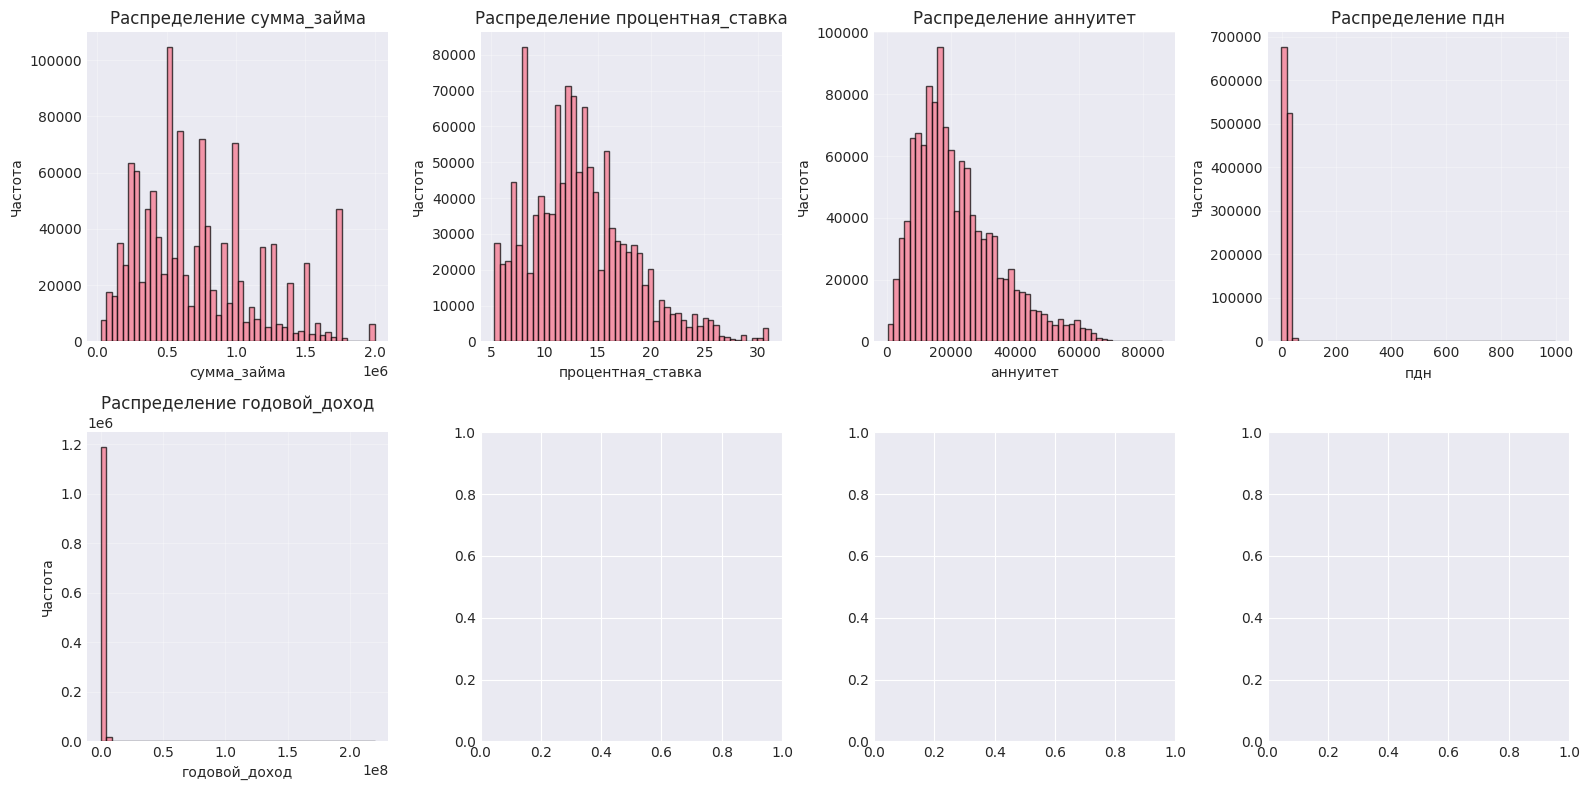

In [15]:
financial_features: List[str] = [
    'сумма_займа',              # Размер кредита
    'процентная_ставка',        # Процент по кредиту (чем выше - выше риск)
    'аннуитет',                 # Ежемесячный платеж
    'пдн',                      # Платеж на душу населения
    'годовой_доход',            # Доход заемщика
    'заем_к_доходу',            # Новый признак: отношение займа к доходу
    'аннуитет_к_доходу',        # Новый признак: платежная нагрузка
]

existing_features: List[str] = [f for f in financial_features if f in train.columns]

if existing_features:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Кредитная история и рейтинги

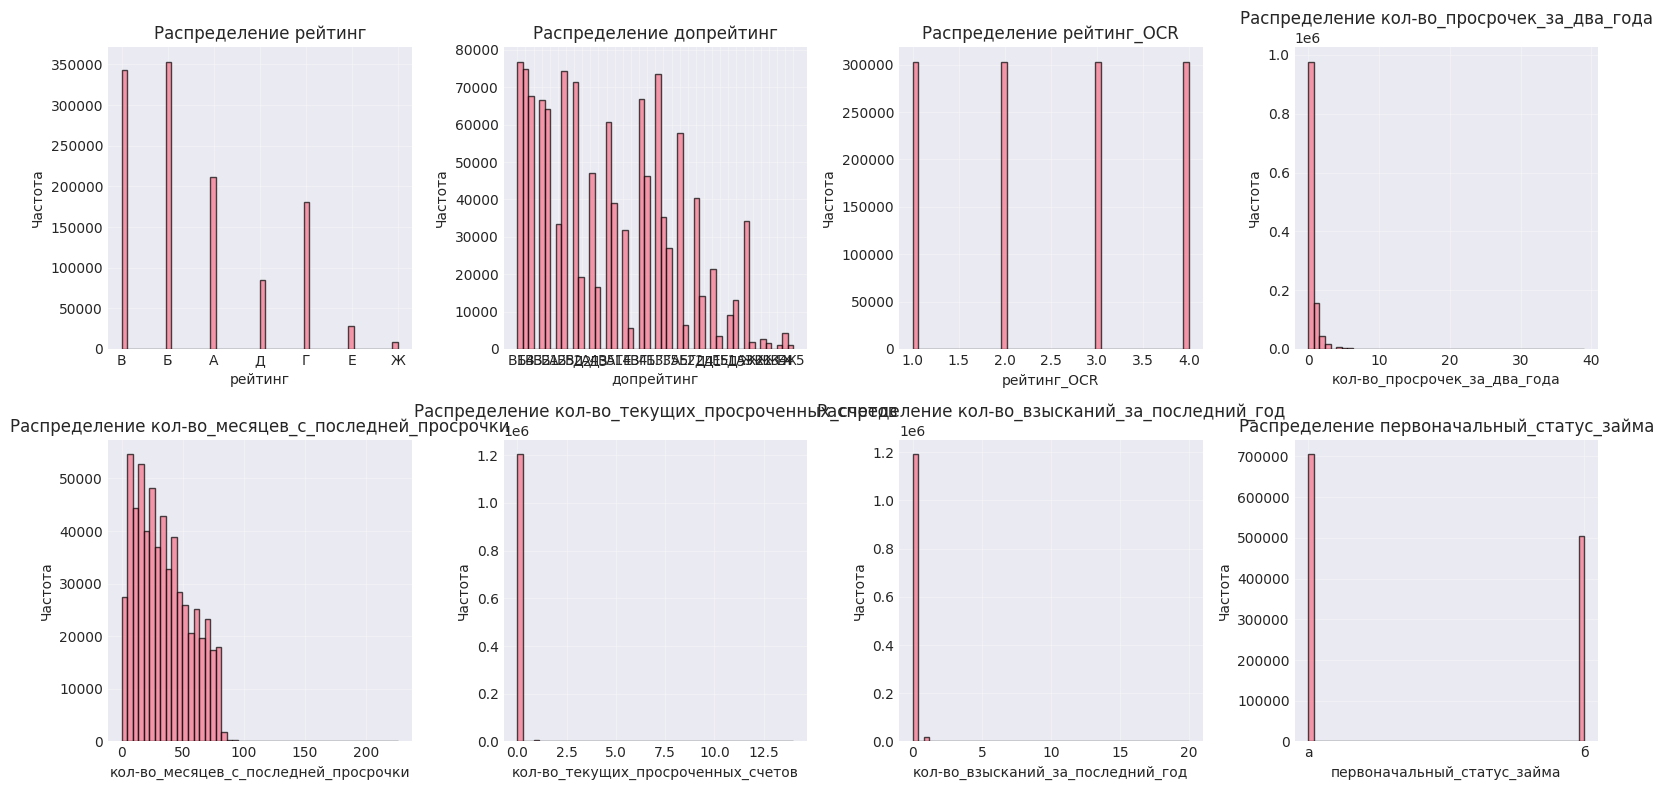

In [16]:
credit_history_features: List[str] = [
    'рейтинг',                  # Буквенный рейтинг (A-Ж) - порядковый признак
    'допрейтинг',               # Дополнительный рейтинг
    'рейтинг_OCR',              # Рейтинг от кредитного бюро
    'кол-во_просрочек_за_два_года',          # История просрочек
    'кол-во_месяцев_с_последней_просрочки',  # Время с последней просрочки
    'кол-во_текущих_просроченных_счетов',    # Текущие проблемы
    'кол-во_взысканий_за_последний_год',     # Взыскания
    'первоначальный_статус_займа',           # Исходный статус
]

existing_features_2: List[str] = [f for f in credit_history_features if f in train.columns]

if existing_features_2:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_2[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Кредитные лимиты и использование

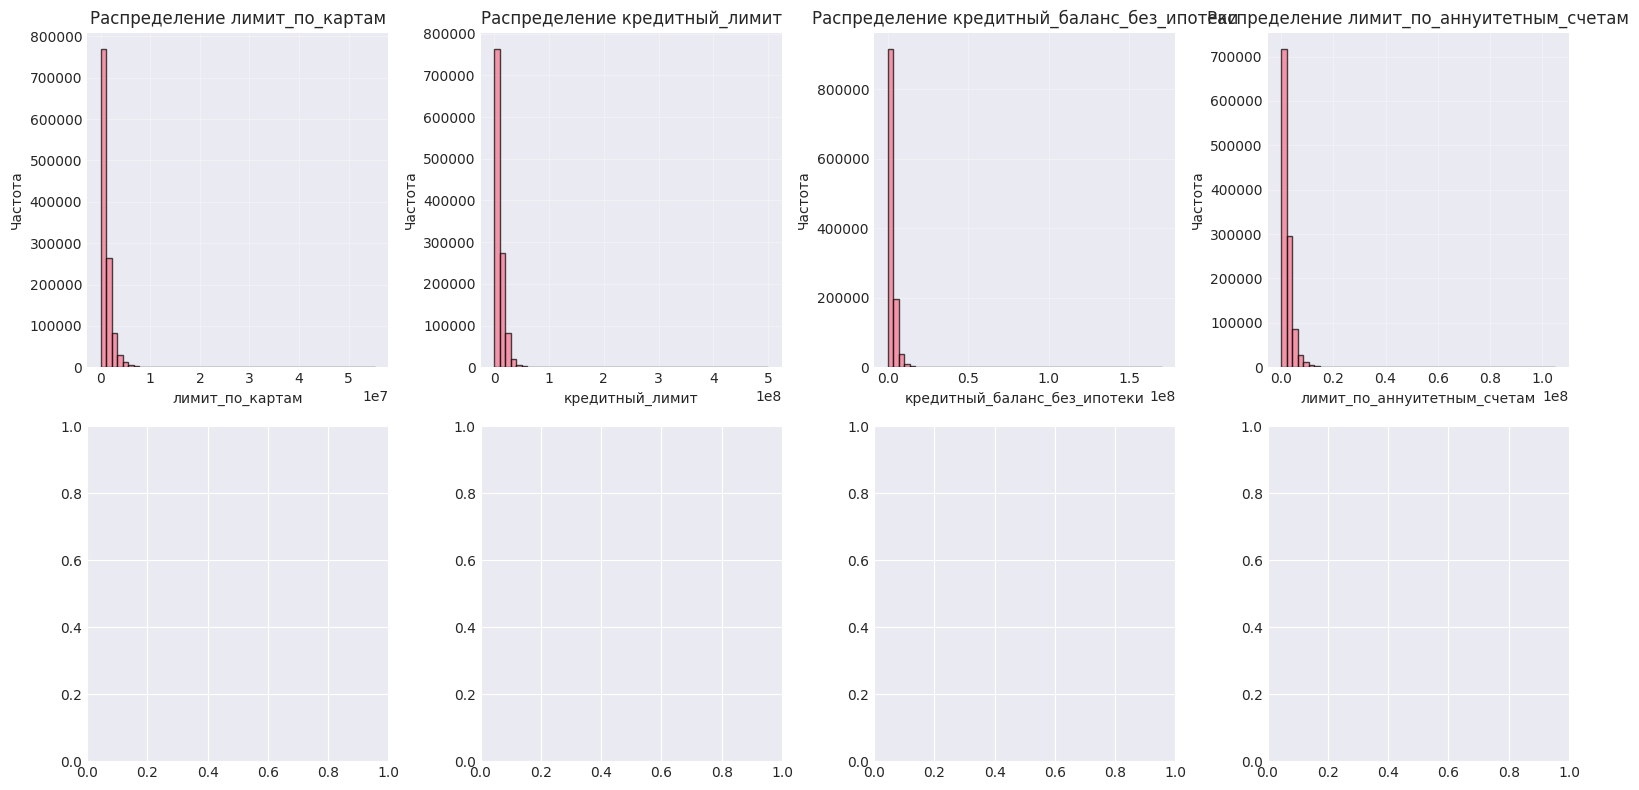

In [17]:
credit_limit_features: List[str] = [
    'лимит_по_картам',          # Лимит по кредитным картам
    'кредитный_лимит',          # Общий кредитный лимит
    'кредитный_баланс_без_ипотеки',  # Использование кредита
    'лимит_по_аннуитетным_счетам',  # Лимиты по разным типам счетов
    'общий_лимит',              # Новый признак: суммарный лимит
    'коэфф_использования_кредита',  # Новый признак: использование лимита
]

existing_features_3: List[str] = [f for f in credit_limit_features if f in train.columns]

if existing_features_3:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_3[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Демографические и профессиональные

In [ ]:
demographic_features: List[str] = [
    'профессия_заемщика',       # Профессия (нужна группировка)
    'стаж',                     # Стаж работы
    'владение_жильем',          # ИПОТЕКА/АРЕНДА/СОБСТВЕННОСТЬ
    'регион',                   # Регион проживания
    'возраст',                  # Если есть в данных
]

existing_features_4: List[str] = [f for f in demographic_features if f in train.columns]

if existing_features_4:
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_4[:5]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x72ee78848e00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Исторические данные по счетам 

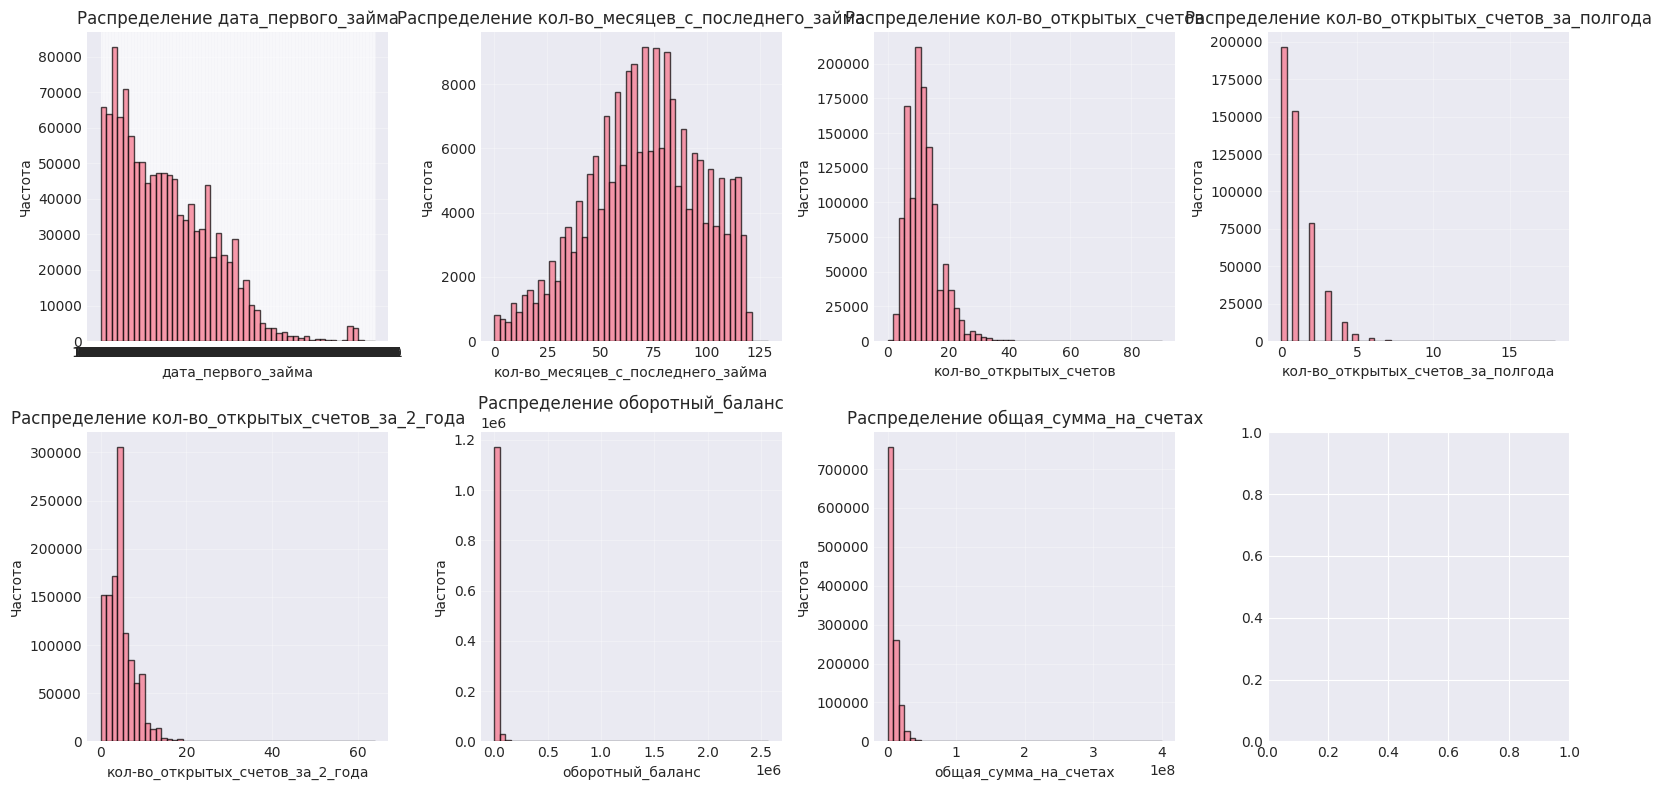

In [19]:
account_history_features = [
    'дата_первого_займа',       # Стаж кредитной истории
    'кол-во_месяцев_с_последнего_займа',     # Время с последнего займа
    'кол-во_открытых_счетов',                # Количество счетов
    'кол-во_открытых_счетов_за_полгода',     # Активность
    'кол-во_открытых_счетов_за_2_года',
    'оборотный_баланс',                      # Текущие балансы
    'общая_сумма_на_счетах',
]

existing_features_5: List[str] = [f for f in account_history_features if f in train.columns]

if existing_features_5:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_5[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Цель и подтверждение дохода

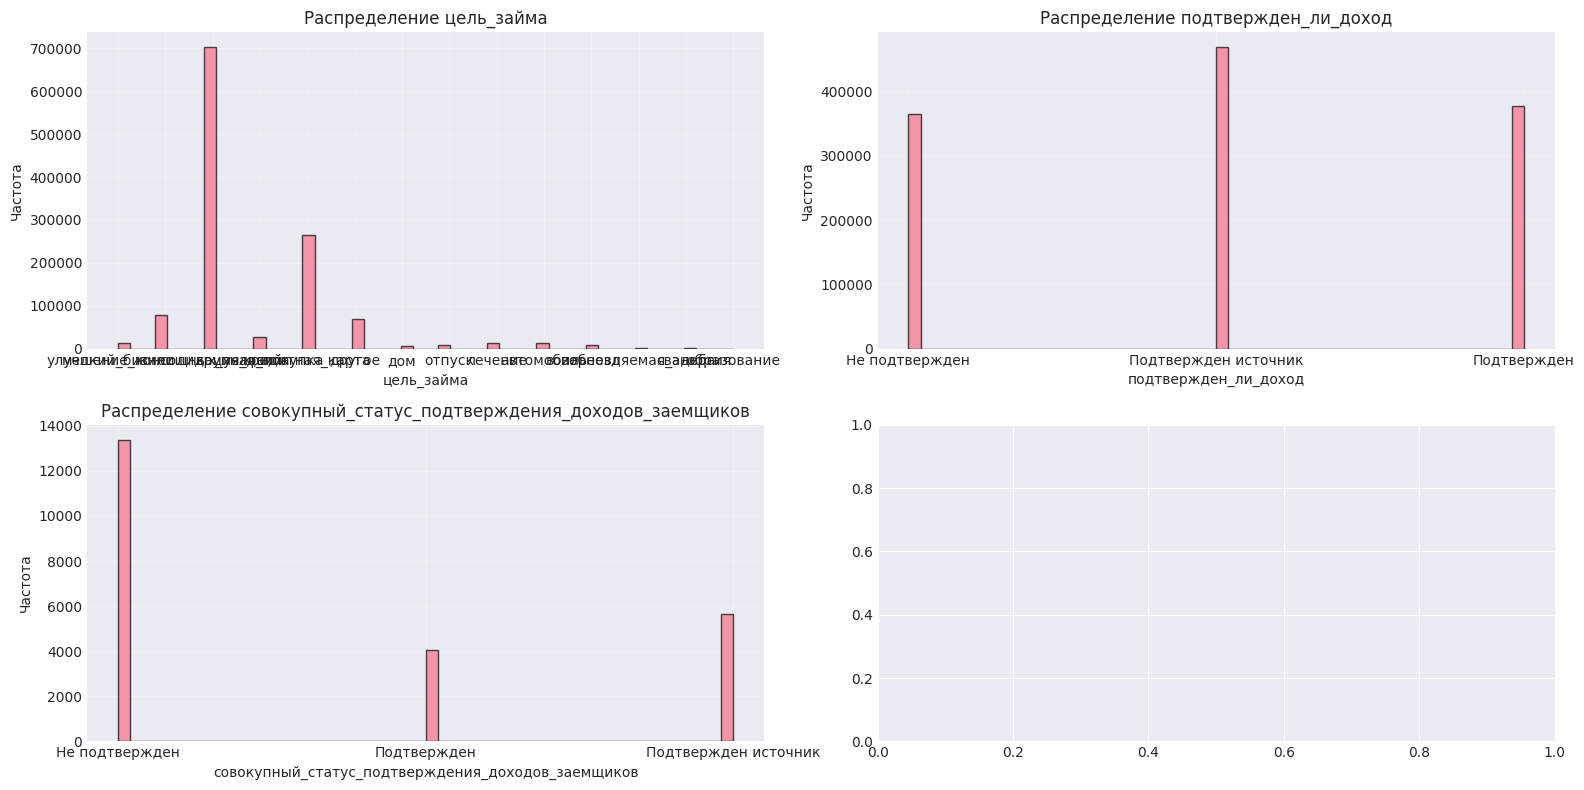

In [20]:
purpose_features = [
    'цель_займа',               # Цель кредита
    'подтвержден_ли_доход',     # Подтверждение дохода
    'совокупный_статус_подтверждения_доходов_заемщиков',
]

existing_features_6: List[str] = [f for f in purpose_features if f in train.columns]

if existing_features_6:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_6[:4]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Коэффициенты и соотношения

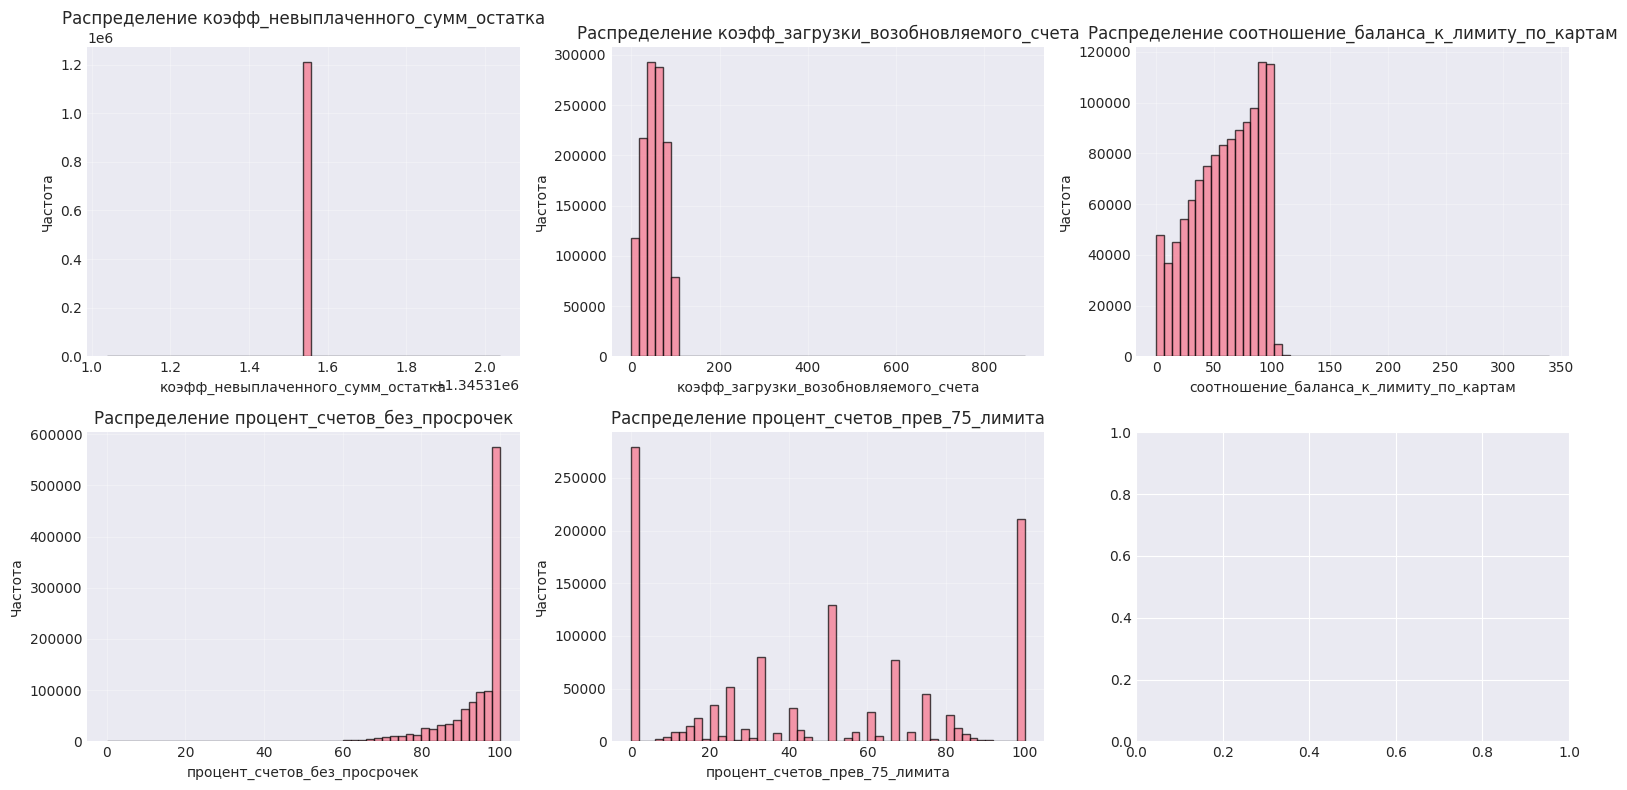

In [21]:
ratio_features = [
    'коэфф_невыплаченного_сумм_остатка',    # Доля непогашенного
    'коэфф_загрузки_возобновляемого_счета', # Использование возобновляемого счета
    'соотношение_баланса_к_лимиту_по_картам', # Использование карт
    'процент_счетов_без_просрочек',         # Качество счетов
    'процент_счетов_прев_75_лимита',        # Перегруженность кредитов
]

existing_features_7: List[str] = [f for f in ratio_features if f in train.columns]

if existing_features_7:
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_7[:6]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

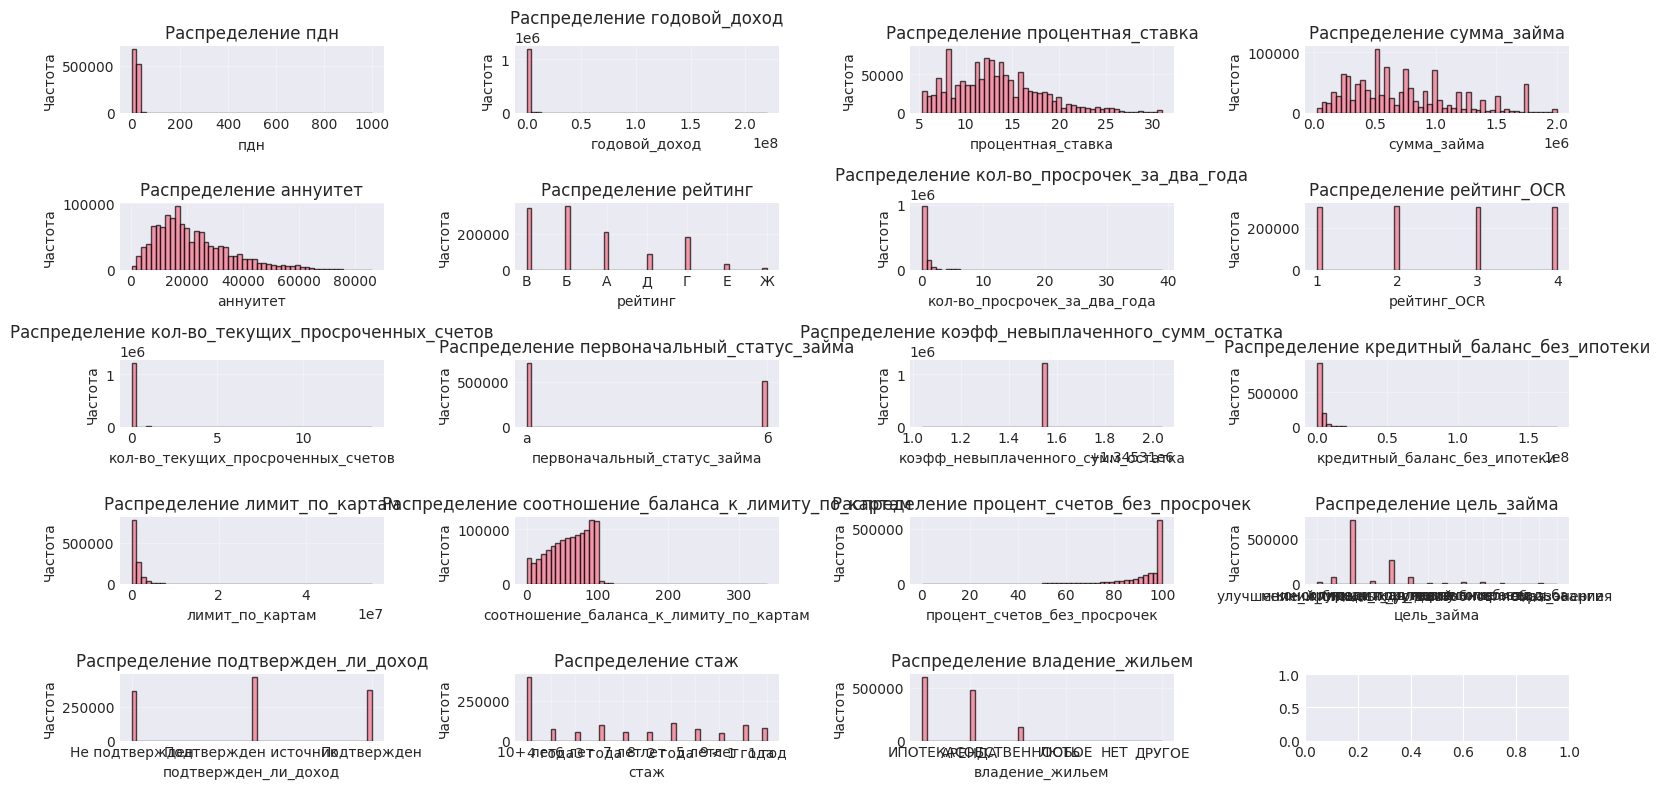

In [24]:
top_20_features = [
    # 1-5: Самые важные финансовые
    'пдн',                          # Ключевой показатель нагрузки
    'годовой_доход',                # Платежеспособность
    'процентная_ставка',            # Рисковость кредита
    'сумма_займа',                  # Размер обязательства
    'аннуитет',                     # Ежемесячная нагрузка
    
    # 6-10: Кредитная история
    'рейтинг',                      # Общая оценка риска
    'кол-во_просрочек_за_два_года', # История просрочек
    'рейтинг_OCR',                  # Оценка бюро
    'кол-во_текущих_просроченных_счетов', # Текущие проблемы
    'первоначальный_статус_займа',  # Исходные условия
    
    # 11-15: Использование кредитов
    'коэфф_невыплаченного_сумм_остатка',
    'кредитный_баланс_без_ипотеки',
    'лимит_по_картам',
    'соотношение_баланса_к_лимиту_по_картам',
    'процент_счетов_без_просрочек',
    
    # 16-20: Дополнительные
    'цель_займа',                   # Цель использования
    'подтвержден_ли_доход',         # Документальное подтверждение
    'стаж',                         # Стабильность работы
    'возраст',                      # Возрастная группа риска
    'владение_жильем',              # Стабильность проживания
]

existing_features_top: List[str] = [f for f in top_20_features if f in train.columns]

if existing_features_top:
    fig, axes = plt.subplots(5, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_top[:20]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Будущие признаки для анализа

In [ ]:
engineered_features = [
    # Финансовые соотношения
    'заем_к_доходу',                # сумма_займа / годовой_доход
    'аннуитет_к_доходу',            # аннуитет * 12 / годовой_доход
    'пдн_от_дохода',                # пдн / годовой_доход * 100
    'общий_лимит',                  # лимит_по_картам + кредитный_лимит
    'коэфф_использования_кредита',  # кредитный_баланс_без_ипотеки / кредитный_лимит
    
    # Временные
    'стаж_кредитной_истории_мес',   # Из дата_первого_займа
    'давность_просрочки_кат',        # Категории из кол-во_месяцев_с_последней_просрочки
    'срок_займа_мес',               # Из срок_займа
    
    # Кредитные
    'интенсивность_просрочек',      # кол-во_просрочек_за_два_года / (24 - кол-во_месяцев_с_последней_просрочки)
    'общая_кредитная_нагрузка',      # сумма всех балансов / сумма всех лимитов
]

### Анализ категориальных признаков

In [25]:
print("\nАнализ категориальных признаков:")
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Всего категориальных признаков: {len(categorical_cols)}")


Анализ категориальных признаков:
Всего категориальных признаков: 19


In [26]:
categorical_cols

['срок_займа',
 'рейтинг',
 'допрейтинг',
 'профессия_заемщика',
 'стаж',
 'владение_жильем',
 'подтвержден_ли_доход',
 'платежный_график',
 'цель_займа',
 'регион',
 'пос_стоп_фактор',
 'юридический_статус',
 'дата_первого_займа',
 'первоначальный_статус_займа',
 'пени_за_дефолт',
 'тип_займа',
 'совокупный_статус_подтверждения_доходов_заемщиков',
 'особая_ситуация',
 'тип_предоставления_кредита']

In [28]:
print("Проверка наличия признаков в данных train:")
available_categorical = []
for feature in categorical_cols:
    if feature in train.columns:
        available_categorical.append(feature)
        print(f"✓ {feature}")
    else:
        possible_variants = [col for col in train.columns if feature.lower() in col.lower()]
        if possible_variants:
            print(f"⚠ {feature} -> найден вариант: {possible_variants[0]}")
            available_categorical.append(possible_variants[0])
        else:
            print(f"✗ {feature} - отсутствует в данных")

Проверка наличия признаков в данных train:
✓ срок_займа
✓ рейтинг
✓ допрейтинг
✓ профессия_заемщика
✓ стаж
✓ владение_жильем
✓ подтвержден_ли_доход
✓ платежный_график
✓ цель_займа
✓ регион
✓ пос_стоп_фактор
✓ юридический_статус
✓ дата_первого_займа
✓ первоначальный_статус_займа
✓ пени_за_дефолт
✓ тип_займа
✓ совокупный_статус_подтверждения_доходов_заемщиков
✓ особая_ситуация
✓ тип_предоставления_кредита


### Первичный анализ категориальных признаков


Признак: срок_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.0%)

Уникальные значения:
  '3 года': 918586 записей
  '5 лет': 292193 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  '5 лет': дефолт 32.4% (292193.0 записей)
  '3 года': дефолт 16.0% (918586.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 2.0 раз выше минимальной!


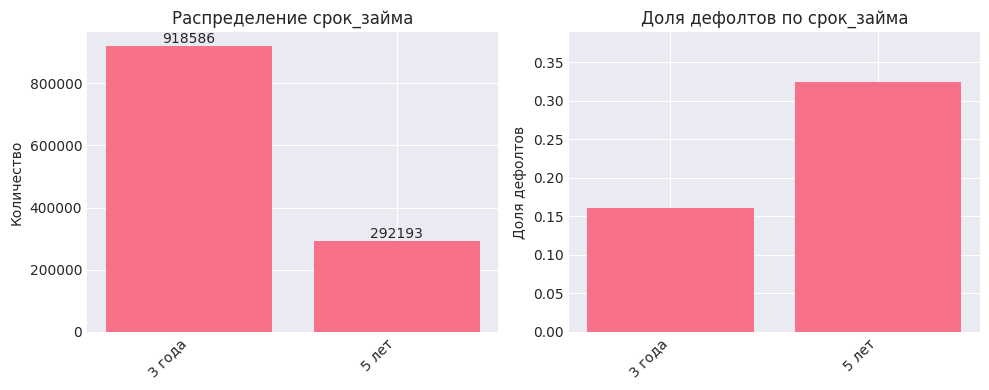


----------------------------------------

Признак: рейтинг
Тип данных: object
Уникальных значений: 7
Пропусков: 0 (0.0%)

Уникальные значения:
  'Б': 353530 записей
  'В': 343586 записей
  'А': 211521 записей
  'Г': 180714 записей
  'Д': 84394 записей
  'Е': 28842 записей
  'Ж': 8192 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Ж': дефолт 49.7% (8192.0 записей)
  'Е': дефолт 45.2% (28842.0 записей)
  'Д': дефолт 38.4% (84394.0 записей)
  'Г': дефолт 30.3% (180714.0 записей)
  'В': дефолт 22.4% (343586.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 8.2 раз выше минимальной!


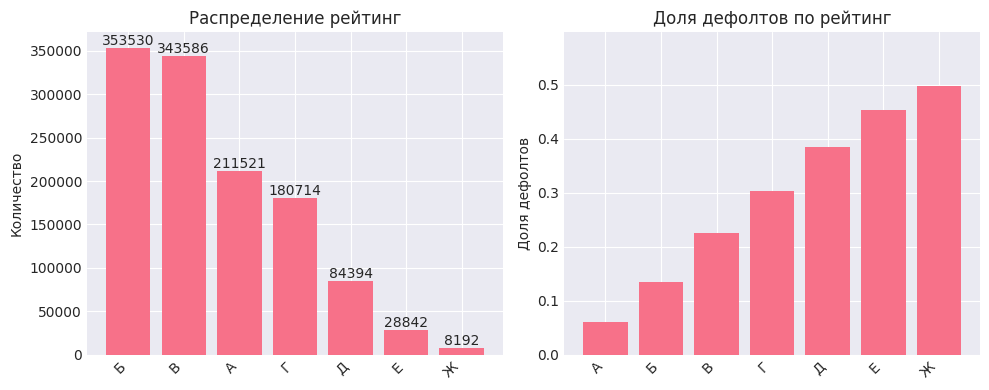


----------------------------------------

Признак: допрейтинг
Тип данных: object
Уникальных значений: 35
Пропусков: 0 (0.0%)

----------------------------------------

Признак: профессия_заемщика
Тип данных: object
Уникальных значений: 273666
Пропусков: 77049 (6.4%)

----------------------------------------

Признак: стаж
Тип данных: object
Уникальных значений: 11
Пропусков: 70508 (5.8%)

Уникальные значения:
  '10+ лет': 398214 записей
  '2 года': 109469 записей
  '< 1 года': 97338 записей
  '3 года': 96842 записей
  '1 год': 79652 записей
  '5 лет': 75707 записей
  '4 года': 72444 записей
  NaN: 70508 записей
  '6 лет': 56522 записей
  '8 лет': 54635 записей
  ... и еще 1 значений

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  '< 1 года': дефолт 20.5% (97338.0 записей)
  '1 год': дефолт 20.5% (79652.0 записей)
  '8 лет': дефолт 20.0% (54635.0 записей)
  '3 года': дефолт 19.9% (96842.0 записей)
  '9 лет': дефолт 19.9% (45815.0 записей)

------------------------------

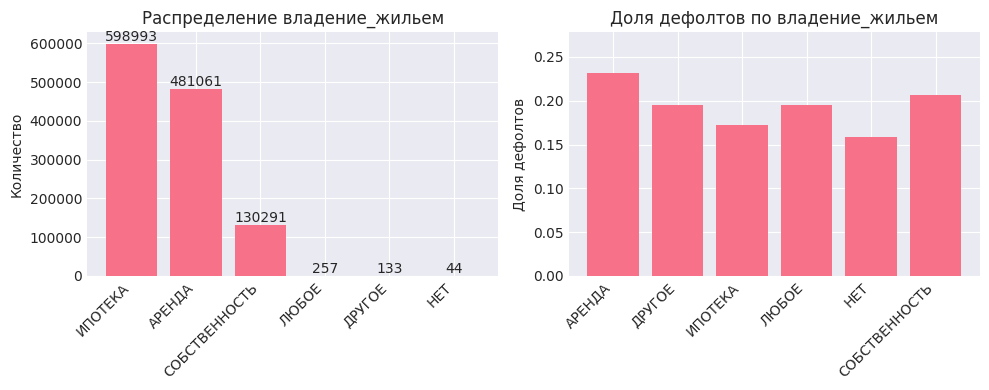


----------------------------------------

Признак: подтвержден_ли_доход
Тип данных: object
Уникальных значений: 3
Пропусков: 0 (0.0%)

Уникальные значения:
  'Подтвержден источник': 468878 записей
  'Подтвержден': 376662 записей
  'Не подтвержден': 365239 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Подтвержден': дефолт 23.8% (376662.0 записей)
  'Подтвержден источник': дефолт 21.0% (468878.0 записей)
  'Не подтвержден': дефолт 14.7% (365239.0 записей)


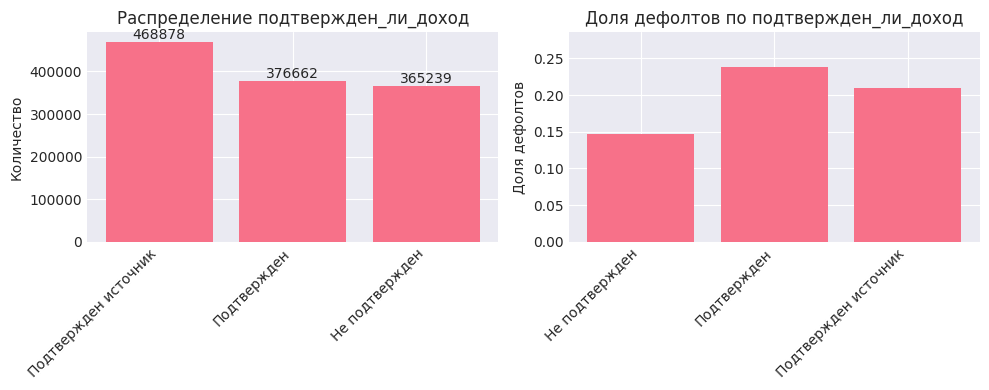


----------------------------------------

Признак: платежный_график
Тип данных: object
Уникальных значений: 1
Пропусков: 0 (0.0%)

Уникальные значения:
  'n': 1210779 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'n': дефолт 20.0% (1210779.0 записей)


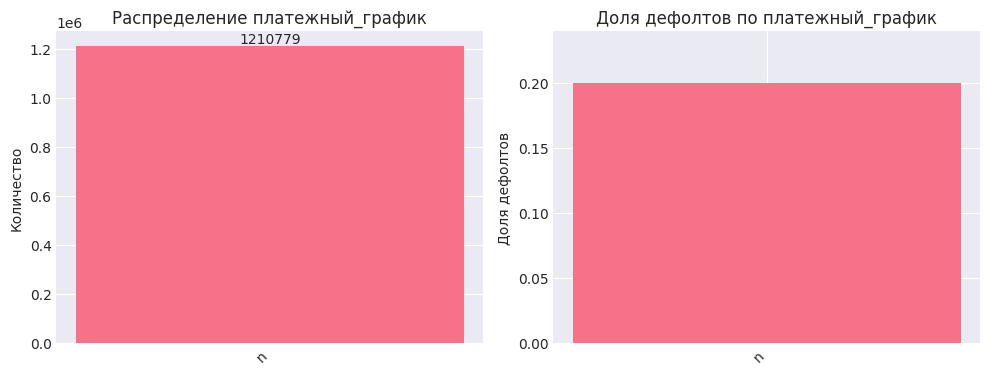


----------------------------------------

Признак: цель_займа
Тип данных: object
Уникальных значений: 14
Пропусков: 0 (0.0%)

Уникальные значения:
  'консолидация_долга': 702475 записей
  'кредитная_карта': 265504 записей
  'улучшение_жилищных_условий': 78686 записей
  'другое': 70166 записей
  'крупная_покупка': 26558 записей
  'лечение': 13983 записей
  'мелкий_бизнес': 13908 записей
  'автомобиль': 13093 записей
  'переезд': 8547 записей
  'отпуск': 8127 записей
  ... и еще 4 значений

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'мелкий_бизнес': дефолт 29.8% (13908.0 записей)
  'возобновляемая_энергия': дефолт 24.2% (832.0 записей)
  'переезд': дефолт 23.5% (8547.0 записей)
  'дом': дефолт 21.7% (6522.0 записей)
  'лечение': дефолт 21.6% (13983.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 2.4 раз выше минимальной!

----------------------------------------

Признак: регион
Тип данных: object
Уникальных значений: 51
Пропусков: 0 (0.0%)

---------------------

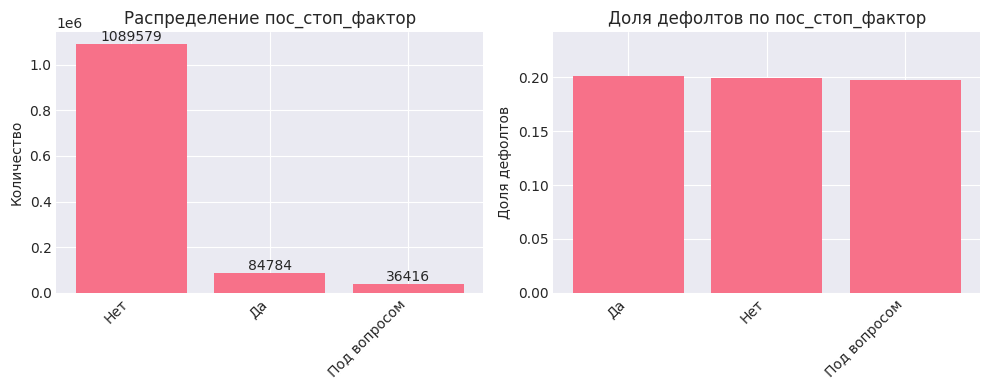


----------------------------------------

Признак: юридический_статус
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.0%)

Уникальные значения:
  'Нет': 968854 записей
  'Да': 241925 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Нет': дефолт 20.0% (968854.0 записей)
  'Да': дефолт 19.9% (241925.0 записей)


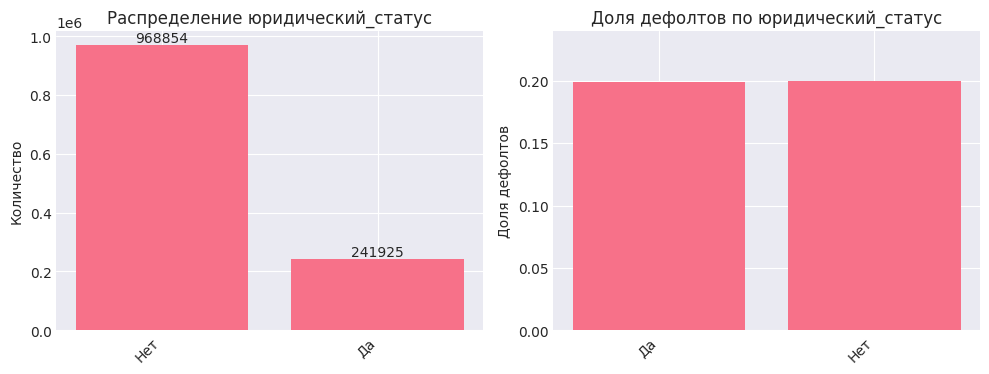


----------------------------------------

Признак: дата_первого_займа
Тип данных: object
Уникальных значений: 738
Пропусков: 0 (0.0%)

----------------------------------------

Признак: первоначальный_статус_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.0%)

Уникальные значения:
  'а': 705688 записей
  'б': 505091 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'а': дефолт 20.2% (705688.0 записей)
  'б': дефолт 19.6% (505091.0 записей)


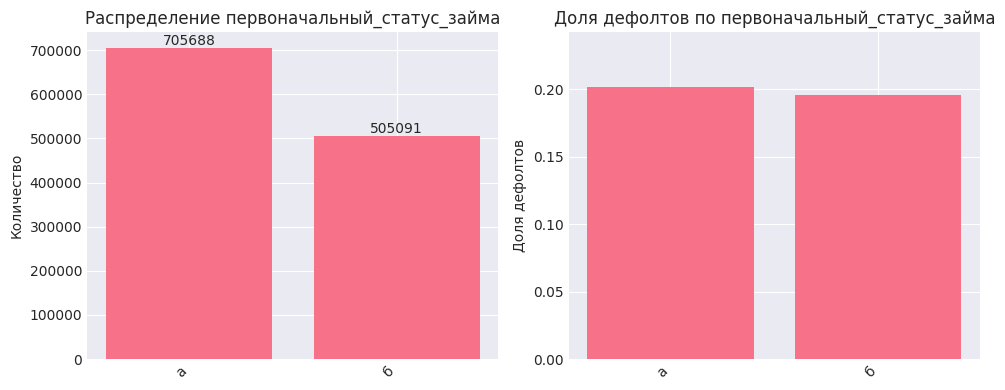


----------------------------------------

Признак: пени_за_дефолт
Тип данных: object
Уникальных значений: 2
Пропусков: 363441 (30.0%)

Уникальные значения:
  'False': 735956 записей
  NaN: 363441 записей
  'True': 111382 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'True': дефолт 100.0% (111382.0 записей)
  'False': дефолт 7.9% (735956.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 12.7 раз выше минимальной!

----------------------------------------

Признак: тип_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.0%)

Уникальные значения:
  'Индивидуальный': 1187546 записей
  'Совместный': 23233 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Совместный': дефолт 24.6% (23233.0 записей)
  'Индивидуальный': дефолт 19.9% (1187546.0 записей)


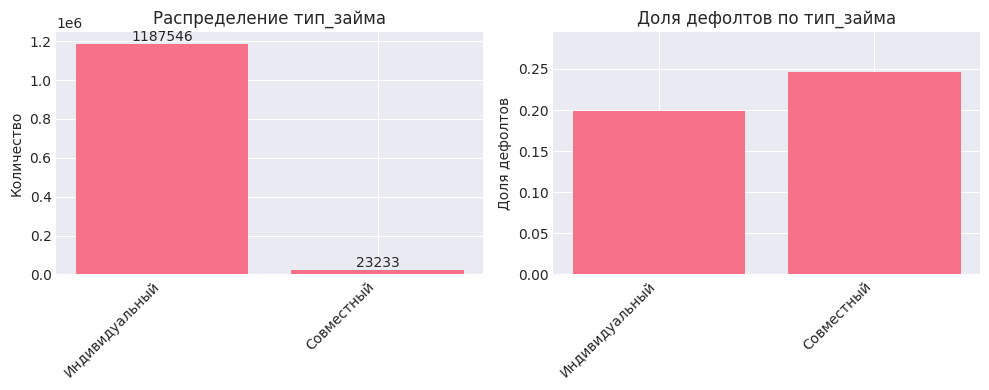


----------------------------------------

Признак: совокупный_статус_подтверждения_доходов_заемщиков
Тип данных: object
Уникальных значений: 3
Пропусков: 1187729 (98.1%)

Уникальные значения:
  NaN: 1187729 записей
  'Не подтвержден': 13380 записей
  'Подтвержден источник': 5635 записей
  'Подтвержден': 4035 записей

----------------------------------------

Признак: особая_ситуация
Тип данных: object
Уникальных значений: 1
Пропусков: 0 (0.0%)

Уникальные значения:
  'Нет': 1210779 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Нет': дефолт 20.0% (1210779.0 записей)


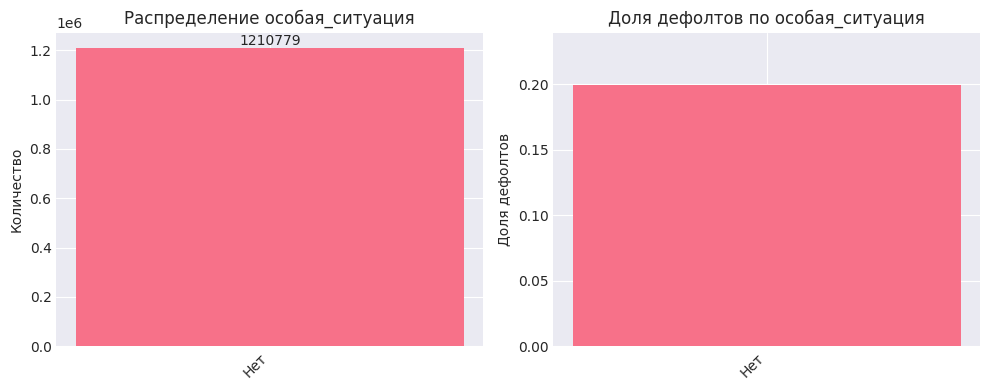


----------------------------------------

Признак: тип_предоставления_кредита
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.0%)

Уникальные значения:
  'Наличные': 1204573 записей
  'Перевод': 6206 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Перевод': дефолт 20.4% (6206.0 записей)
  'Наличные': дефолт 20.0% (1204573.0 записей)


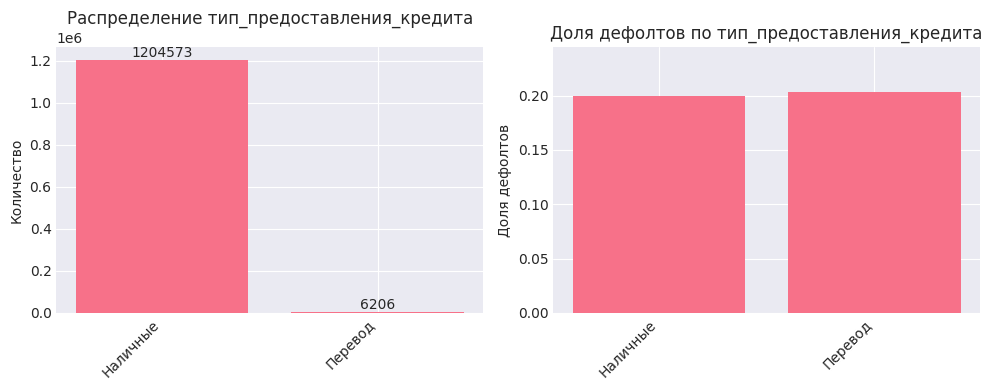


----------------------------------------


In [29]:
for feature in available_categorical:
    if feature in train.columns:
        print(f"\n{'='*40}")
        print(f"Признак: {feature}")
        print('='*40)
        
        # Основная информация
        unique_values = train[feature].nunique()
        n_missing = train[feature].isnull().sum()
        pct_missing = n_missing / len(train) * 100
        
        print(f"Тип данных: {train[feature].dtype}")
        print(f"Уникальных значений: {unique_values}")
        print(f"Пропусков: {n_missing} ({pct_missing:.1f}%)")
        
        # Содержимое (первые 10 уникальных значений, если их не слишком много)
        if unique_values <= 20:
            print(f"\nУникальные значения:")
            value_counts = train[feature].value_counts(dropna=False)
            for value, count in value_counts.head(10).items():
                if pd.isna(value):
                    print(f"  NaN: {count} записей")
                else:
                    print(f"  '{value}': {count} записей")
            
            if unique_values > 10:
                print(f"  ... и еще {unique_values - 10} значений")
        
        # Анализ связи с целевой переменной
        if pct_missing < 50 and unique_values <= 20:  # Анализируем только если разумное количество значений
            print(f"\nСвязь с целевой переменной:")
            
            # Удаляем пропуски для анализа
            clean_data = train[[feature, target_col]].dropna(subset=[feature])
            
            if len(clean_data) > 0:
                # Для каждого значения смотрим долю дефолтов
                default_rates = clean_data.groupby(feature)[target_col].agg(['mean', 'count'])
                default_rates = default_rates.sort_values('mean', ascending=False)
                
                print("Топ-5 значений по доле дефолтов:")
                for value, (default_rate, count) in default_rates.head(5).iterrows():
                    if pd.isna(value):
                        print(f"  NaN: дефолт {default_rate:.1%} ({count} записей)")
                    else:
                        print(f"  '{value}': дефолт {default_rate:.1%} ({count} записей)")
                
                # Проверяем, есть ли статистически значимые различия
                if len(default_rates) > 1:
                    max_rate = default_rates['mean'].max()
                    min_rate = default_rates['mean'].min()
                    if max_rate > 0 and min_rate > 0:
                        ratio = max_rate / min_rate
                        if ratio > 2:
                            print(f"  ВНИМАНИЕ: Максимальная доля дефолтов в {ratio:.1f} раз выше минимальной!")
        
        # Визуализация для важных признаков
        if unique_values <= 10 and pct_missing < 30:
            plt.figure(figsize=(10, 4))
            
            # 1. Распределение
            plt.subplot(1, 2, 1)
            value_counts = train[feature].value_counts(dropna=False)
            if len(value_counts) <= 10:
                bars = plt.bar(range(len(value_counts)), value_counts.values)
                plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')
                plt.title(f'Распределение {feature}')
                plt.ylabel('Количество')
                
                # Добавляем числа на столбцы
                for bar, count in zip(bars, value_counts.values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                            f'{count}', ha='center', va='bottom')
            
            # 2. Доля дефолтов по категориям
            plt.subplot(1, 2, 2)
            if len(clean_data) > 0:
                default_rates = clean_data.groupby(feature)[target_col].mean()
                if len(default_rates) <= 10:
                    bars = plt.bar(range(len(default_rates)), default_rates.values)
                    plt.xticks(range(len(default_rates)), default_rates.index, rotation=45, ha='right')
                    plt.title(f'Доля дефолтов по {feature}')
                    plt.ylabel('Доля дефолтов')
                    plt.ylim(0, max(default_rates.values) * 1.2)
            
            plt.tight_layout()
            plt.show()
        
        print("\n" + "-"*40)

### Анализ уникальных значений

In [30]:
for col in categorical_cols[:50]:
    unique_vals = train[col].nunique()
    print(f"{col}: {unique_vals} уникальных значений")

срок_займа: 2 уникальных значений
рейтинг: 7 уникальных значений
допрейтинг: 35 уникальных значений
профессия_заемщика: 273666 уникальных значений
стаж: 11 уникальных значений
владение_жильем: 6 уникальных значений
подтвержден_ли_доход: 3 уникальных значений
платежный_график: 1 уникальных значений
цель_займа: 14 уникальных значений
регион: 51 уникальных значений
пос_стоп_фактор: 3 уникальных значений
юридический_статус: 2 уникальных значений
дата_первого_займа: 738 уникальных значений
первоначальный_статус_займа: 2 уникальных значений
пени_за_дефолт: 2 уникальных значений
тип_займа: 2 уникальных значений
совокупный_статус_подтверждения_доходов_заемщиков: 3 уникальных значений
особая_ситуация: 1 уникальных значений
тип_предоставления_кредита: 2 уникальных значений


### Анализ рейтингов

In [31]:
if 'рейтинг' in train.columns:
    print("Рейтинг (буквенный):")
    rating_order = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж']
    for rating in rating_order:
        if rating in train['рейтинг'].values:
            subset = train[train['рейтинг'] == rating]
            default_rate = subset[target_col].mean()
            print(f"  {rating}: {len(subset)} записей, дефолт {default_rate:.1%}")

if 'допрейтинг' in train.columns:
    print("\nДопрейтинг:")
    top_dopratings = train['допрейтинг'].value_counts().head(10)
    for doprating, count in top_dopratings.items():
        if not pd.isna(doprating):
            subset = train[train['допрейтинг'] == doprating]
            default_rate = subset[target_col].mean()
            print(f"  {doprating}: {count} записей, дефолт {default_rate:.1%}")

Рейтинг (буквенный):
  А: 211521 записей, дефолт 6.1%
  Б: 353530 записей, дефолт 13.4%
  В: 343586 записей, дефолт 22.4%
  Г: 180714 записей, дефолт 30.3%
  Д: 84394 записей, дефолт 38.4%
  Е: 28842 записей, дефолт 45.2%
  Ж: 8192 записей, дефолт 49.7%

Допрейтинг:
  В1: 76885 записей, дефолт 19.1%
  Б4: 74965 записей, дефолт 14.8%
  Б5: 74394 записей, дефолт 16.7%
  Б3: 73444 записей, дефолт 13.0%
  В2: 71404 записей, дефолт 20.7%
  В3: 67583 записей, дефолт 22.5%
  В4: 66958 записей, дефолт 25.0%
  Б2: 66645 записей, дефолт 11.3%
  Б1: 64082 записей, дефолт 10.5%
  В5: 60756 записей, дефолт 25.9%



Распределение по рейтингам:
рейтинг
А    211521
Б    353530
В    343586
Г    180714
Д     84394
Е     28842
Ж      8192
Name: count, dtype: int64


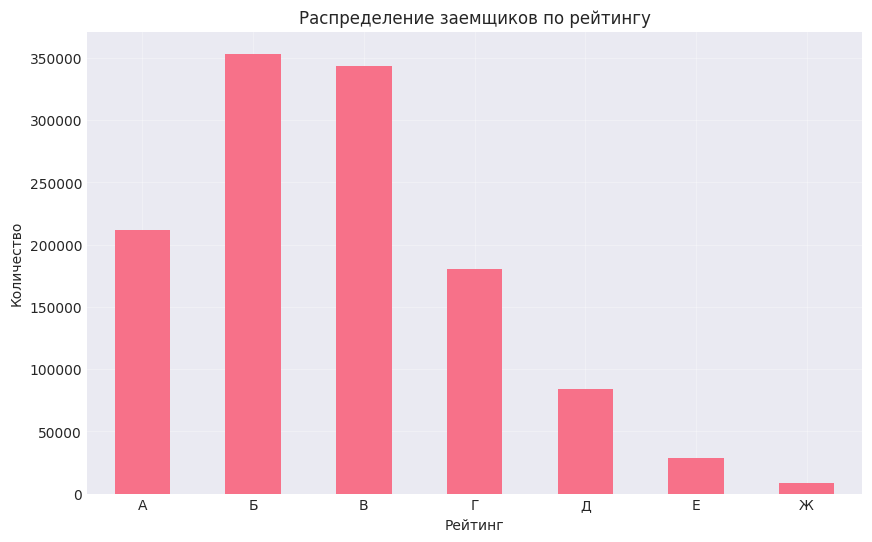

In [32]:
if 'рейтинг' in categorical_cols:
    print("\nРаспределение по рейтингам:")
    rating_dist = train['рейтинг'].value_counts().sort_index()
    print(rating_dist)
    
    # Визуализация рейтингов
    plt.figure(figsize=(10, 6))
    rating_dist.plot(kind='bar')
    plt.title('Распределение заемщиков по рейтингу')
    plt.xlabel('Рейтинг')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(alpha=0.3)
    plt.show()

### Подтверждение дохода

In [33]:
income_confirmation_cols = ['подтвержден_ли_доход', 'совокупный_статус_подтверждения_доходов_заемщиков']
for col in income_confirmation_cols:
    if col in train.columns:
        print(f"\n{col}:")
        for value in sorted(train[col].dropna().unique()):
            if not pd.isna(value):
                subset = train[train[col] == value]
                default_rate = subset[target_col].mean()
                print(f"  '{value}': {len(subset)} записей, дефолт {default_rate:.1%}")


подтвержден_ли_доход:
  'Не подтвержден': 365239 записей, дефолт 14.7%
  'Подтвержден': 376662 записей, дефолт 23.8%
  'Подтвержден источник': 468878 записей, дефолт 21.0%

совокупный_статус_подтверждения_доходов_заемщиков:
  'Не подтвержден': 13380 записей, дефолт 22.5%
  'Подтвержден': 4035 записей, дефолт 28.5%
  'Подтвержден источник': 5635 записей, дефолт 27.0%


### Цель займа

In [34]:
if 'цель_займа' in train.columns:
    # Группируем похожие цели
    purpose_groups = {
        'консолидация_долга': ['консолидация', 'долг', 'рефинансирование'],
        'жилье': ['жилищ', 'ипотек', 'квартир', 'дом'],
        'авто': ['автомобиль', 'авто', 'машина'],
        'образование': ['образование', 'учеба', 'обучение'],
        'бизнес': ['бизнес', 'предприниматель', 'коммерция'],
        'потребительский': ['потребитель', 'личные', 'товары'],
        'кредитная_карта': ['карта', 'кредитн']
    }
    
    # Анализ по группам
    for group_name, keywords in purpose_groups.items():
        mask = train['цель_займа'].astype(str).str.lower().apply(
            lambda x: any(keyword in x for keyword in keywords)
        )
        if mask.any():
            subset = train[mask]
            default_rate = subset[target_col].mean()
            print(f"  {group_name}: {len(subset)} записей, дефолт {default_rate:.1%}")
            # Примеры целей в группе
            examples = subset['цель_займа'].unique()[:3]
            print(f"    Примеры: {', '.join([str(e) for e in examples])}")


  консолидация_долга: 702475 записей, дефолт 21.1%
    Примеры: консолидация_долга
  жилье: 85208 записей, дефолт 18.0%
    Примеры: улучшение_жилищных_условий, дом
  авто: 13093 записей, дефолт 14.7%
    Примеры: автомобиль
  образование: 297 записей, дефолт 17.2%
    Примеры: образование
  бизнес: 13908 записей, дефолт 29.8%
    Примеры: мелкий_бизнес
  кредитная_карта: 265504 записей, дефолт 16.9%
    Примеры: кредитная_карта


### Владение жильём

In [35]:
if 'владение_жильем' in train.columns:
    ownership_order = ['СОБСТВЕННОСТЬ', 'ИПОТЕКА', 'АРЕНДА', 'Другое']
    for ownership in ownership_order:
        if ownership in train['владение_жильем'].values:
            subset = train[train['владение_жильем'] == ownership]
            default_rate = subset[target_col].mean()
            print(f"  {ownership}: {len(subset)} записей, дефолт {default_rate:.1%}")

  СОБСТВЕННОСТЬ: 130291 записей, дефолт 20.6%
  ИПОТЕКА: 598993 записей, дефолт 17.2%
  АРЕНДА: 481061 записей, дефолт 23.2%


### Регион

In [36]:
print("\nРЕГИОНЫ (топ-10 по количеству займов):")
if 'регион' in train.columns:
    top_regions = train['регион'].value_counts().head(10)
    for region, count in top_regions.items():
        if not pd.isna(region):
            subset = train[train['регион'] == region]
            default_rate = subset[target_col].mean()
            print(f"  {region}: {count} записей, дефолт {default_rate:.1%}")


РЕГИОНЫ (топ-10 по количеству займов):
  Московская область: 177023 записей, дефолт 19.6%
  Ленинградская область: 99039 записей, дефолт 19.8%
  Новосибирская область: 98828 записей, дефолт 22.0%
  Иркутская область: 86014 записей, дефолт 21.5%
  Республика Татарстан: 46608 записей, дефолт 18.1%
  Тверская область: 43601 записей, дефолт 21.1%
  Амурская область: 40972 записей, дефолт 20.9%
  Ярославская область: 39514 записей, дефолт 20.6%
  Республика Коми: 38999 записей, дефолт 18.4%
  Кемеровская область: 34330 записей, дефолт 19.8%


### Корреляционный анализ

In [37]:
print("\nКорреляционный анализ:")

# Выбираем числовые колонки
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)


Корреляционный анализ:


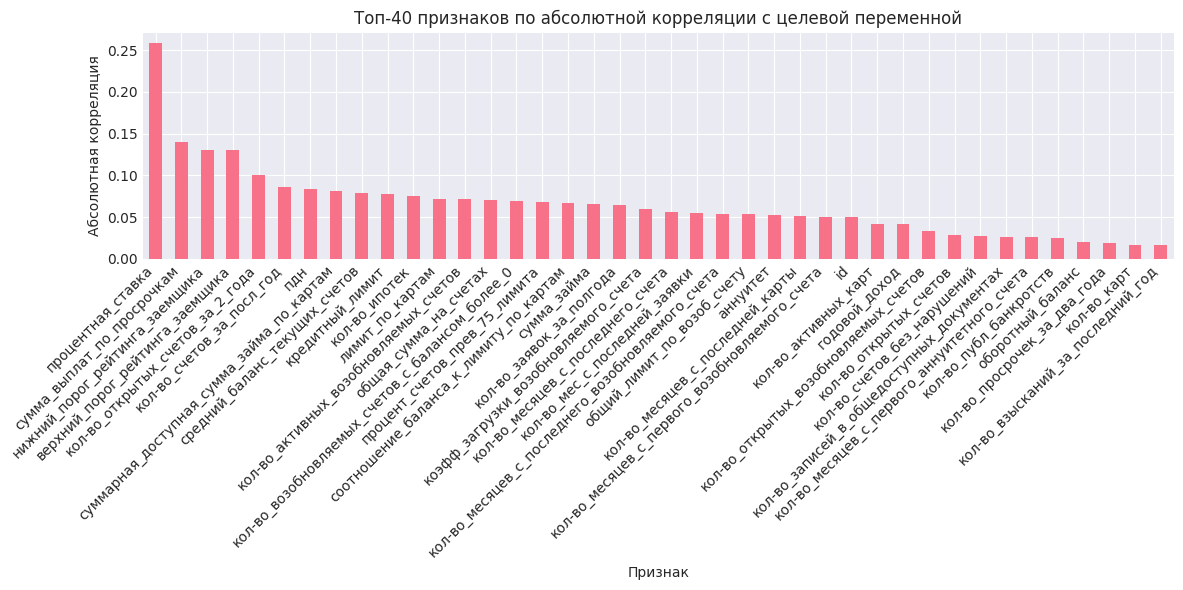


Топ-20 признаков по корреляции с итоговый_статус_займа:
процентная_ставка                                 0.258
сумма_выплат_по_просрочкам                        0.140
нижний_порог_рейтинга_заемщика                    0.131
верхний_порог_рейтинга_заемщика                   0.131
кол-во_открытых_счетов_за_2_года                  0.100
кол-во_счетов_за_посл_год                         0.086
пдн                                               0.084
суммарная_доступная_сумма_займа_по_картам         0.082
средний_баланс_текущих_счетов                     0.079
кредитный_лимит                                   0.078
кол-во_ипотек                                     0.075
лимит_по_картам                                   0.072
кол-во_активных_возобновляемых_счетов             0.071
общая_сумма_на_счетах                             0.071
кол-во_возобновляемых_счетов_с_балансом_более_0   0.070
процент_счетов_прев_75_лимита                     0.068
соотношение_баланса_к_лимиту_по_картам         

In [ ]:
numeric_cols_filtered: List = []
for col in numeric_cols:
    if train[col].notna().sum() > len(train) * 0.5:  # Более 50% заполнено
        numeric_cols_filtered.append(col)

if len(numeric_cols_filtered) > 0:
    # Корреляции с целевой переменной
    correlations: pd.Series = train[numeric_cols_filtered + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
    
    # Топ-40 признаков по корреляции
    top_corr = correlations[1:41]  # Исключаем саму целевую
    
    plt.figure(figsize=(12, 6))
    top_corr.plot(kind='bar')
    plt.title('Топ-40 признаков по абсолютной корреляции с целевой переменной')
    plt.xlabel('Признак')
    plt.ylabel('Абсолютная корреляция')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\nТоп-20 признаков по корреляции с {target_col}:")
    print(correlations[1:21])

## 4. Предобработка данных

### Функция для предобработки

In [115]:
# def advanced_preprocessing(
#     train_df: pd.DataFrame, 
#     test_df: pd.DataFrame, 
#     target_col:str = 'итоговый_статус_займа'
# ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
#     """
#     Улучшенная предобработка данных
#     """
#     # Сохраняем ID
#     train_ids: pd.Series = train_df['id'].copy() if 'id' in train_df.columns else None
#     test_ids: pd.Series = test_df['id'].copy()
    
#     # Объединяем для согласованной обработки
#     df: pd.DataFrame = pd.concat([train_df, test_df], ignore_index=True)
#     original_cols: List[str] = df.columns.tolist()

#     # Признаки с >98% пропусков (бесполезны)
#     useless_cols: List[str] = [
#         'дата_следующей_выплаты',  # 100% пропусков
#         'кредитный_баланс_по_возоб_счетам',  # ~98.6%
#         'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
#         'совокупный_пдн_заемщиков',  # ~98.1%
#         'совокупный_доход_заемщиков',  # ~98.1%
#         'пени_за_дефолт',  # 30% пропусков + коррелирует с таргетом
#     ]
    
#     # Константные признаки
#     constant_cols: List[str] = [
#         'платежный_график',  # только 'n'
#         'особая_ситуация',  # только 'Нет'
#     ]
    
#     # Признаки, которые заменим производными
#     to_replace_cols: List[str] = [
#         'дата_первого_займа',  # заменим на стаж кредитной истории
#         'срок_займа',  # заменим на числовой срок
#     ]
    
#     cols_to_drop: List[str] = [col for col in useless_cols + constant_cols + to_replace_cols 
#                    if col in df.columns]
#     df: pd.DataFrame = df.drop(columns=cols_to_drop)
#     print(f"Удалено {len(cols_to_drop)} признаков")
    
#     print("\nОбработка временных и категориальных признаков...")
#     # 1. Обработка дат
#     if 'дата_первого_займа' in df.columns:
#         print("Обработка дат...")
#         df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
#         current_date = pd.Timestamp('2026-01-01')  # Предполагаемая дата анализа
#         df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
#         df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)  # Ограничиваем 50 лет
#         df = df.drop(columns=['дата_первого_займа'])
#         print("Создан признак: стаж_кредитной_истории_мес")
    
#     # 2. Обработка сроков займа
#     if 'срок_займа' in df.columns:
#         print("Обработка сроков займа...")
#         df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
#         df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
#         df = df.drop(columns=['срок_займа'])
#         print("Создан признак: срок_займа_мес")
    
#     # 3. Кодирование рейтингов (порядковые признаки)
#     # 3.1 Порядковое кодирование (очень важные признаки)
#     rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
#     if 'рейтинг' in df.columns:
#         print("Кодирование рейтингов...")
#         df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
#         df = df.drop(columns=['рейтинг'])
#         print("Закодирован рейтинг (порядковое кодирование)")

#     # 3.2 Стаж работы
#     experience_order = {
#         '< 1 года': 0.5,
#         '1 год': 1,
#         '2 года': 2,
#         '3 года': 3,
#         '4 года': 4,
#         '5 лет': 5,
#         '6 лет': 6,
#         '7 лет': 7,
#         '8 лет': 8,
#         '9 лет': 9,
#         '10+ лет': 10
#     }
#     if 'стаж' in df.columns:
#         # Сначала применяем mapping
#         df['стаж_encoded'] = df['стаж'].map(experience_order)
        
#         # Для пропусков заполняем медианой уже преобразованных значений
#         median_experience = df['стаж_encoded'].median()
#         df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        
#         df = df.drop(columns=['стаж'])
#         print("✓ Закодирован стаж (порядковое кодирование)")

#      # 3.3 Бинарные признаки
#     binary_mapping = {
#         'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
#         'True': 1, 'False': 0
#     }
    
#     binary_cols = ['пос_стоп_фактор', 'юридический_статус']
#     for col in binary_cols:
#         if col in df.columns:
#             df[col] = df[col].map(binary_mapping).fillna(0)
#             print(f"Закодирован {col} (бинарное кодирование)")

#     # 3.4 One-Hot Encoding для признаков с малым количеством уникальных значений
#     onehot_cols = [
#         'владение_жильем',  # 6 значений
#         'подтвержден_ли_доход',  # 3 значения
#         'первоначальный_статус_займа',  # 2 значения
#         'тип_займа',  # 2 значения
#         'тип_предоставления_кредита'  # 2 значения
#     ]
    
#     for col in onehot_cols:
#         if col in df.columns:
#             dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
#             df = pd.concat([df, dummies], axis=1)
#             df = df.drop(columns=[col])
#             print(f"Закодирован {col} (one-hot encoding)")

#     # 3.6 Frequency Encoding для признаков с большим количеством уникальных значений
#     freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
#     for col in freq_cols:
#         if col in df.columns:
#             freq = df[col].value_counts(normalize=True)
#             df[f'{col}_freq_encoded'] = df[col].map(freq)
#             df = df.drop(columns=[col])
#             print(f"Закодирован {col} (frequency encoding)")

#     # 3.7 Цель займа - группировка + target encoding
#     if 'цель_займа' in df.columns:
#         # Сначала сгруппируем редкие цели
#         purpose_counts = df['цель_займа'].value_counts()
#         rare_purposes = purpose_counts[purpose_counts < 1000].index
        
#         # Группировка по смыслу
#         purpose_groups = {
#             'консолидация_долга': ['консолидация_долга'],
#             'кредитная_карта': ['кредитная_карта'],
#             'жилье': ['улучшение_жилищных_условий', 'дом'],
#             'бизнес': ['мелкий_бизнес'],
#             'авто': ['автомобиль'],
#             'образование': ['образование'],
#             'лечение': ['лечение'],
#             'переезд': ['переезд'],
#             'отпуск': ['отпуск'],
#             'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия']
#         }
        
#         # Обратное отображение для группировки
#         purpose_to_group = {}
#         for group, purposes in purpose_groups.items():
#             for purpose in purposes:
#                 purpose_to_group[purpose] = group
        
#         # Группируем
#         df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        
#         # Заменяем редкие цели на 'другое'
#         df.loc[df['цель_займа'].isin(rare_purposes), 'цель_займа_группа'] = 'другое'
#         df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'

#         # Будем делать target encoding позже
#         df = df.drop(columns=['цель_займа'])
#         print("Сгруппирована цель_займа (создано 10 групп)")
    
#     # 4. Создание новых признаков
#     print("Создание новых признаков...")
    
#     # Финансовые соотношения
#     if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
#         df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: аннуитет_к_доходу")
    
#     if 'пдн' in df.columns and 'годовой_доход' in df.columns:
#         df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: пдн_от_дохода")
    
#     if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
#         df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: заем_к_доходу")
    
#     # Кредитные метрики
#     if all(col in df.columns for col in ['кредитный_баланс_без_ипотеки', 'кредитный_лимит']):
#         df['коэфф_использования_кредита'] = df['кредитный_баланс_без_ипотеки'] / df['кредитный_лимит'].replace(0, 1)
#         print("Создан признак: коэфф_использования_кредита")
    
#     if all(col in df.columns for col in ['лимит_по_картам', 'кредитный_лимит']):
#         df['общий_лимит'] = df['лимит_по_картам'].fillna(0) + df['кредитный_лимит'].fillna(0)
#         print("Создан признак: общий_лимит")
    
#     if all(col in df.columns for col in ['оборотный_баланс', 'общий_лимит']):
#         df['коэфф_использования_общего_лимита'] = df['оборотный_баланс'] / df['общий_лимит'].replace(0, np.nan)
#         print("Создан признак: коэфф_использования_общего_лимита")

#     if 'рейтинг_encoded' in df.columns and 'пдн_от_дохода' in df.columns:
#         df['рейтинг_пдн_взаимодействие'] = df['рейтинг_encoded'] * df['пдн_от_дохода']
#         print("Создан признак: рейтинг_пдн_взаимодействие")
    
#     if 'рейтинг_encoded' in df.columns and 'процентная_ставка' in df.columns:
#         df['рейтинг_ставка_взаимодействие'] = df['рейтинг_encoded'] * df['процентная_ставка']
#         print("Создан признак: рейтинг_ставка_взаимодействие")

#     # Временные признаки
#     if 'кол-во_месяцев_с_последней_просрочки' in df.columns:
#         df['давность_просрочки_кат'] = pd.cut(
#             df['кол-во_месяцев_с_последней_просрочки'].fillna(999),
#             bins=[0, 3, 6, 12, 24, 999],
#             labels=['0-3м', '3-6м', '6-12м', '1-2г', '>2л/нет'],
#             right=False
#         )
#         print("Создан признак: давность_просрочки_кат")
    
#     # 5. Обработка пропусков
#     print("Обработка пропусков...")
#     # Разделяем признаки по степени заполненности
#     missing_stats = df.isnull().sum() / len(df) * 100
#     missing_stats = missing_stats.sort_values(ascending=False)
    
#     # Группа 1: Признаки с <5% пропусков - заполняем медианой/модой
#     low_missing_cols = missing_stats[missing_stats < 5].index.tolist()
    
#     # Группа 2: Признаки с 5-50% пропусков - требуют особого подхода
#     medium_missing_cols = missing_stats[(missing_stats >= 5) & (missing_stats < 50)].index.tolist()
    
#     # Группа 3: Признаки с >50% пропусков - возможно, стоит удалить
#     high_missing_cols = missing_stats[missing_stats >= 50].index.tolist()
    
#     print(f"Признаков с <5% пропусков: {len(low_missing_cols)}")
#     print(f"Признаков с 5-50% пропусков: {len(medium_missing_cols)}")
#     print(f"Признаков с >50% пропусков: {len(high_missing_cols)}")
    
#     # Удаляем признаки с >80% пропусков (кроме критически важных)
#     critical_cols = ['пдн', 'процентная_ставка']  # Важные признаки, даже с пропусками
#     cols_to_drop_high_missing = [col for col in high_missing_cols 
#                                 if col not in critical_cols and missing_stats[col] > 80]
    
#     if cols_to_drop_high_missing:
#         df = df.drop(columns=cols_to_drop_high_missing)
#         print(f"Удалено {len(cols_to_drop_high_missing)} признаков с >80% пропусков")
    
#     # Для низких пропусков - заполняем
#     for col in low_missing_cols:
#         if col in df.columns:
#             if df[col].dtype in ['int64', 'float64']:
#                 df[col] = df[col].fillna(df[col].median())
#             else:
#                 df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
#     # Для средних пропусков - заполняем специальными значениями
#     for col in medium_missing_cols:
#         if col in df.columns:
#             if df[col].dtype in ['int64', 'float64']:
#                 # Для числовых - медиана + флаг пропуска
#                 df[f'{col}_missing'] = df[col].isnull().astype(int)
#                 df[col] = df[col].fillna(df[col].median())
#             else:
#                 # Для категориальных - специальная категория
#                 df[col] = df[col].fillna('MISSING')
    
#     # # Разделяем числовые и категориальные признаки
#     # numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     # categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
#     # # Для числовых - медиана
#     # for col in numeric_cols:
#     #     if col in df.columns:
#     #         df[col] = df[col].fillna(df[col].median())
    
#     # # Для категориальных - мода
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
#     # 6. Обработка выбросов
#     print("Обработка выбросов...")
#     # for col in numeric_cols:
#     #     if col in df.columns:
#     #         Q1 = df[col].quantile(0.01)  # Используем 1% и 99% перцентили
#     #         Q3 = df[col].quantile(0.99)
#     #         IQR = Q3 - Q1
#     #         lower_bound = Q1 - 3 * IQR
#     #         upper_bound = Q3 + 3 * IQR
            
#     #         # Winsorizing
#     #         df[col] = np.where(df[col] > upper_bound, upper_bound,
#     #                          np.where(df[col] < lower_bound, lower_bound, df[col]))
#     # Только для ключевых числовых признаков
#     key_numeric_cols = [
#         'сумма_займа', 'процентная_ставка', 'годовой_доход', 'пдн',
#         'аннуитет', 'лимит_по_картам', 'кредитный_лимит',
#         'заем_к_доходу', 'аннуитет_к_доходу', 'пдн_от_дохода'
#     ]
    
#     for col in key_numeric_cols:
#         if col in df.columns:
#             # Используем более агрессивное winsorizing для финансовых показателей
#             q01 = df[col].quantile(0.01)
#             q99 = df[col].quantile(0.99)
#             df[col] = np.clip(df[col], q01, q99)
    
#     # # 7. Обработка категориальных переменных
#     # print("Обработка категориальных переменных...")
    
#     # # Бинарные признаки
#     # binary_mapping = {'Да': 1, 'Нет': 0, 'Под вопросом': 0.5}
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         unique_vals = df[col].unique()
#     #         if set(unique_vals).issubset(set(binary_mapping.keys())):
#     #             df[col] = df[col].map(binary_mapping)
#     #             categorical_cols.remove(col)
    
#     # # Frequency encoding для категориальных с большим количеством значений
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         if df[col].nunique() > 20:  # Много уникальных значений
#     #             freq = df[col].value_counts(normalize=True)
#     #             df[f'{col}_freq_encoded'] = df[col].map(freq)
#     #             df = df.drop(columns=[col])
#     #         else:
#     #             # One-hot encoding для остальных
#     #             dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
#     #             df = pd.concat([df, dummies], axis=1)
#     #             df = df.drop(columns=[col])
    
#     # # 8. Масштабирование
#     # print("Масштабирование признаков...")
#     # scaler = RobustScaler()
#     # numeric_cols_updated = df.select_dtypes(include=[np.number]).columns.tolist()
#     # if target_col in numeric_cols_updated:
#     #     numeric_cols_updated.remove(target_col)
    
#     # df[numeric_cols_updated] = scaler.fit_transform(df[numeric_cols_updated])
    
#     # # 9. Удаление константных признаков
#     # print("Удаление константных признаков...")
#     # constant_cols = [col for col in df.columns if df[col].nunique() == 1]
#     # if constant_cols:
#     #     df = df.drop(columns=constant_cols)
#     #     print(f"Удалено {len(constant_cols)} константных признаков")
    
#     # # 10. Разделяем обратно
#     # print("Разделение на train и test...")
#     # if target_col in df.columns:
#     #     train_processed = df[df[target_col].notna()].copy()
#     #     test_processed = df[df[target_col].isna()].copy()
#     #     y = train_processed[target_col]
#     #     X_train = train_processed.drop(columns=[target_col, 'id'] if 'id' in train_processed.columns else [target_col])
#     #     X_test = test_processed.drop(columns=[target_col, 'id'] if 'id' in test_processed.columns else [target_col])
#     # else:
#     #     X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
#     #     X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
#     #     y = None
    
#     # print(f"Обработка завершена! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
#     # return X_train, X_test, y, test_ids
#     # ШАГ 7: РАЗДЕЛЕНИЕ НА TRAIN/TEST ДЛЯ TARGET ENCODING
#     print("\n7. Разделение данных для target encoding...")
    
#     if target_col in df.columns:
#         train_mask = df[target_col].notna()
#         test_mask = df[target_col].isna()
        
#         df_train = df[train_mask].copy()
#         df_test = df[test_mask].copy()
        
#         # Target Encoding для категориальных признаков
#         target_encode_cols = ['цель_займа_группа', 'регион_freq_encoded']
        
#         for col in target_encode_cols:
#             if col in df_train.columns:
#                 # Вычисляем target encoding на train
#                 target_mean = df_train.groupby(col)[target_col].mean()
                
#                 # Применяем к train и test
#                 df_train[f'{col}_target_encoded'] = df_train[col].map(target_mean)
#                 df_test[f'{col}_target_encoded'] = df_test[col].map(target_mean).fillna(df_train[target_col].mean())
                
#                 # Удаляем исходный признак
#                 df_train = df_train.drop(columns=[col])
#                 df_test = df_test.drop(columns=[col])
        
#         # Объединяем обратно
#         df = pd.concat([df_train, df_test], ignore_index=True)
        
#         # Разделяем на X и y
#         y = df[target_col].loc[train_mask]
#         X_train = df.loc[train_mask].drop(columns=[target_col, 'id'])
#         X_test = df.loc[test_mask].drop(columns=[target_col, 'id'])
        
#     else:
#         X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
#         X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
#         y = None
#     # ШАГ 8: МАСШТАБИРОВАНИЕ И ФИНАЛЬНАЯ ОЧИСТКА
#     print("\n8. Масштабирование и финальная очистка...")
    
#     # Масштабирование (RobustScaler для устойчивости к выбросам)
#     from sklearn.preprocessing import RobustScaler
    
#     numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
#     if numeric_cols:
#         scaler = RobustScaler()
#         X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
#         X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
#         print(f"Масштабировано {len(numeric_cols)} числовых признаков")
    
#     # Удаление константных признаков (если появились после обработки)
#     constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
#     if constant_cols:
#         X_train = X_train.drop(columns=constant_cols)
#         X_test = X_test.drop(columns=constant_cols)
#         print(f"Удалено {len(constant_cols)} константных признаков")
    
#     # Удаление дубликатов признаков (если есть)
#     # (пропускаем для скорости, но в реальном проекте стоит проверить)
    
#     print("\n" + "="*60)
#     print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
#     print("="*60)
#     print(f"Итоговые размеры:")
#     print(f"  X_train: {X_train.shape}")
#     print(f"  X_test:  {X_test.shape}")
#     if y is not None:
#         print(f"  y_train: {y.shape}")
    
#     return X_train, X_test, y, test_ids

def advanced_preprocessing(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = 'итоговый_статус_займа'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Улучшенная предобработка данных с исправлением ошибок
    """
    # Сохраняем ID
    train_ids: pd.Series = train_df['id'].copy()
    test_ids: pd.Series = test_df['id'].copy()
    
    # Объединяем для согласованной обработки
    df: pd.DataFrame = pd.concat([train_df, test_df], ignore_index=True)
    
    print("="*60)
    print("НАЧАЛО ПРЕДОБРАБОТКИ")
    print("="*60)
    
    # ШАГ 1: УДАЛЕНИЕ БЕСПОЛЕЗНЫХ ПРИЗНАКОВ
    print("\n1. Удаление бесполезных признаков...")
    
    # Признаки с >98% пропусков (бесполезны)
    useless_cols: List[str] = [
        'дата_следующей_выплаты',  # 100% пропусков
        'кредитный_баланс_по_возоб_счетам',  # ~98.6%
        'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
        'совокупный_пдн_заемщиков',  # ~98.1%
        'совокупный_доход_заемщиков',  # ~98.1%
        'пени_за_дефолт',  # 30% пропусков + коррелирует с таргетом
    ]
    
    # Константные признаки
    constant_cols: List[str] = [
        'платежный_график',  # только 'n'
        'особая_ситуация',  # только 'Нет'
    ]
    
    # Признаки, которые заменим производными
    to_replace_cols: List[str] = [
        'дата_первого_займа',  # заменим на стаж кредитной истории
        'срок_займа',  # заменим на числовой срок
    ]
    
    cols_to_drop: List[str] = [col for col in useless_cols + constant_cols + to_replace_cols 
                   if col in df.columns]
    df: pd.DataFrame = df.drop(columns=cols_to_drop)
    print(f"✓ Удалено {len(cols_to_drop)} признаков")
    
    # ШАГ 2: ОБРАБОТКА ВРЕМЕННЫХ И КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    print("\n2. Обработка временных и категориальных признаков...")
    
    # 2.1 Обработка сроков займа
    if 'срок_займа' in df.columns:
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
        df = df.drop(columns=['срок_займа'])
        print("✓ Создан признак: срок_займа_мес")
    
    # 2.2 Кодирование рейтингов (порядковые признаки)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
        print("✓ Закодирован рейтинг (порядковое кодирование)")

    # 2.3 Стаж работы
    experience_order = {
        '< 1 года': 0.5,
        '1 год': 1,
        '2 года': 2,
        '3 года': 3,
        '4 года': 4,
        '5 лет': 5,
        '6 лет': 6,
        '7 лет': 7,
        '8 лет': 8,
        '9 лет': 9,
        '10+ лет': 10
    }
    
    if 'стаж' in df.columns:
        df['стаж_encoded'] = df['стаж'].map(experience_order)
        median_experience = df['стаж_encoded'].median()
        df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        df = df.drop(columns=['стаж'])
        print("✓ Закодирован стаж (порядковое кодирование)")

    # 2.4 Бинарные признаки
    binary_mapping = {
        'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
        'True': 1, 'False': 0
    }
    
    binary_cols = ['пос_стоп_фактор', 'юридический_статус']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map(binary_mapping)
            df[col] = df[col].fillna(0)
            print(f"✓ Закодирован {col} (бинарное кодирование)")

    # 2.5 One-Hot Encoding для признаков с малым количеством уникальных значений
    onehot_cols = [
        'владение_жильем',  # 6 значений
        'подтвержден_ли_доход',  # 3 значения
        'первоначальный_статус_займа',  # 2 значения
        'тип_займа',  # 2 значения
        'тип_предоставления_кредита'  # 2 значения
    ]
    
    for col in onehot_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            print(f"✓ Закодирован {col} (one-hot encoding)")

    # 2.6 Frequency Encoding для признаков с большим количеством уникальных значений
    freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
    for col in freq_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq_encoded'] = df[col].map(freq)
            df = df.drop(columns=[col])
            print(f"✓ Закодирован {col} (frequency encoding)")

    # 2.7 Цель займа - группировка
    if 'цель_займа' in df.columns:
        df['цель_займа'] = df['цель_займа'].fillna('другое')
        
        purpose_counts = df['цель_займа'].value_counts()
        rare_purposes = purpose_counts[purpose_counts < 1000].index
        
        purpose_groups = {
            'консолидация_долга': ['консолидация_долга'],
            'кредитная_карта': ['кредитная_карта'],
            'жилье': ['улучшение_жилищных_условий', 'дом'],
            'бизнес': ['мелкий_бизнес'],
            'авто': ['автомобиль'],
            'образование': ['образование'],
            'лечение': ['лечение'],
            'переезд': ['переезд'],
            'отпуск': ['отпуск'],
            'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия']
        }
        
        purpose_to_group = {}
        for group, purposes in purpose_groups.items():
            for purpose in purposes:
                purpose_to_group[purpose] = group
        
        df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        df.loc[df['цель_займа'].isin(rare_purposes), 'цель_займа_группа'] = 'другое'
        df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'
        
        df = df.drop(columns=['цель_займа'])
        print("✓ Сгруппирована цель_займа (создано 10 групп)")
    
    # ШАГ 3: СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
    print("\n3. Создание новых признаков...")
    
    # Финансовые соотношения
    if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: аннуитет_к_доходу")
    
    if 'пдн' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: пдн_от_дохода")
    
    if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: заем_к_доходу")
    
    # ШАГ 4: ОБРАБОТКА ПРОПУСКОВ
    print("\n4. Обработка пропусков...")
    
    # Удаляем признаки с >80% пропусков
    missing_stats = df.isnull().sum() / len(df) * 100
    high_missing_cols = missing_stats[missing_stats >= 80].index.tolist()
    
    # Важные признаки, которые НЕ удаляем даже с пропусками
    critical_cols = ['пдн', 'процентная_ставка', 'годовой_доход', 'аннуитет']
    cols_to_drop_high_missing = [col for col in high_missing_cols 
                                if col not in critical_cols]
    
    if cols_to_drop_high_missing:
        df = df.drop(columns=cols_to_drop_high_missing)
        print(f"✓ Удалено {len(cols_to_drop_high_missing)} признаков с >80% пропусков")
    
    # Заполняем пропуски в числовых признаках
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    print(f"✓ Заполнены пропуски в {len(numeric_cols)} числовых признаках")
    
    # ШАГ 5: УДАЛЕНИЕ КОНСТАНТНЫХ ПРИЗНАКОВ (ДО РАЗДЕЛЕНИЯ!)
    print("\n5. Удаление константных признаков...")
    
    constant_cols_before = [col for col in df.columns if df[col].nunique() == 1 and col != target_col]
    if constant_cols_before:
        df = df.drop(columns=constant_cols_before)
        print(f"✓ Удалено {len(constant_cols_before)} константных признаков")
    
    # ШАГ 6: РАЗДЕЛЕНИЕ НА TRAIN/TEST
    print("\n6. Разделение данных...")
    
    if target_col in df.columns:
        train_mask = df[target_col].notna()
        test_mask = df[target_col].isna()
        
        df_train = df[train_mask].copy()
        df_test = df[test_mask].copy()
        
        # Выделяем target
        y = df_train[target_col].copy()
        
        # Удаляем target из данных
        df_train = df_train.drop(columns=[target_col])
        df_test = df_test.drop(columns=[target_col])
        
        # ВАЖНО: Убедимся, что train и test имеют одинаковые колонки
        # Найдем общие колонки
        common_cols = list(set(df_train.columns) & set(df_test.columns))
        
        # Если есть различия, выровняем их
        if len(common_cols) < len(df_train.columns) or len(common_cols) < len(df_test.columns):
            print(f"  Выравнивание колонок: train={len(df_train.columns)}, test={len(df_test.columns)}")
            print(f"  Общих колонок: {len(common_cols)}")
            
            # Оставляем только общие колонки
            df_train = df_train[common_cols]
            df_test = df_test[common_cols]
        
        # Разделяем на X_train и X_test
        X_train = df_train.drop(columns=['id']) if 'id' in df_train.columns else df_train
        X_test = df_test.drop(columns=['id']) if 'id' in df_test.columns else df_test
        
        print(f"✓ Разделение завершено: X_train={X_train.shape}, X_test={X_test.shape}")
        
    else:
        # Если target_col нет (тестовый режим)
        X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
        X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
        y = None
    
    # ШАГ 7: МАСШТАБИРОВАНИЕ
    print("\n7. Масштабирование признаков...")
    
    from sklearn.preprocessing import RobustScaler
    
    # Берем только числовые колонки, которые есть в обоих наборах
    numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns.tolist()
    
    # Находим общие числовые колонки
    common_numeric_cols = list(set(numeric_cols_train) & set(numeric_cols_test))
    
    if common_numeric_cols:
        scaler = RobustScaler()
        
        # Масштабируем только общие колонки
        X_train_scaled = scaler.fit_transform(X_train[common_numeric_cols])
        X_test_scaled = scaler.transform(X_test[common_numeric_cols])
        
        # Обновляем значения
        X_train[common_numeric_cols] = X_train_scaled
        X_test[common_numeric_cols] = X_test_scaled
        
        print(f"✓ Масштабировано {len(common_numeric_cols)} числовых признаков")
    else:
        print("⚠ Нет общих числовых признаков для масштабирования")
    
    # ШАГ 8: ФИНАЛЬНАЯ ОЧИСТКА
    print("\n8. Финальная очистка...")
    
    # Удаление признаков с низкой дисперсией (если есть)
    try:
        from sklearn.feature_selection import VarianceThreshold
        
        # Объединяем для определения низковариационных признаков
        X_combined = pd.concat([X_train, X_test], axis=0)
        
        selector = VarianceThreshold(threshold=0.01)
        selector.fit(X_combined)
        
        # Получаем маску признаков, которые нужно оставить
        support_mask = selector.get_support()
        
        if not all(support_mask):
            removed_count = len(support_mask) - sum(support_mask)
            X_train = X_train.iloc[:, support_mask]
            X_test = X_test.iloc[:, support_mask]
            print(f"✓ Удалено {removed_count} признаков с низкой дисперсией")
        else:
            print("✓ Все признаки имеют достаточную дисперсию")
            
    except Exception as e:
        print(f"⚠ Ошибка при удалении низковариационных признаков: {str(e)}")
    
    # Проверка на пропуски
    if X_train.isnull().any().any() or X_test.isnull().any().any():
        print("⚠ ВНИМАНИЕ: После обработки остались пропуски!")
        print(f"  Пропуски в X_train: {X_train.isnull().sum().sum()}")
        print(f"  Пропуски в X_test: {X_test.isnull().sum().sum()}")
        
        # Заполняем оставшиеся пропуски
        for col in X_train.columns:
            if X_train[col].isnull().any():
                X_train[col] = X_train[col].fillna(X_train[col].median())
            if col in X_test.columns and X_test[col].isnull().any():
                X_test[col] = X_test[col].fillna(X_train[col].median())
    
    print("\n" + "="*60)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print("="*60)
    print(f"Итоговые размеры:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test:  {X_test.shape}")
    if y is not None:
        print(f"  y_train: {y.shape}")
        print(f"  Баланс классов: 0={100*(y==0).mean():.1f}%, 1={100*(y==1).mean():.1f}%")
    
    # Информация о важных признаках
    important_features = [
        'рейтинг_encoded', 'процентная_ставка', 'пдн', 
        'пдн_от_дохода', 'заем_к_доходу', 'аннуитет_к_доходу',
        'кол-во_просрочек_за_два_года'
    ]
    
    available_important = [f for f in important_features if f in X_train.columns]
    print(f"\n✓ Доступно {len(available_important)} из {len(important_features)} важных признаков:")
    for feat in available_important[:10]:  # Покажем первые 10
        print(f"  • {feat}")
    
    return X_train, X_test, y, test_ids
    
    return X_train, X_test, y, test_ids

In [ ]:
def advanced_preprocessing(train_df, test_df, target_col='итоговый_статус_займа'):
    """
    Улучшенная предобработка данных
    """
    # Сохраняем ID
    train_ids = train_df['id'].copy() if 'id' in train_df.columns else None
    test_ids = test_df['id'].copy()
    
    # Объединяем для согласованной обработки
    df = pd.concat([train_df, test_df], ignore_index=True)
    original_cols = df.columns.tolist()
    
    # 1. Обработка дат
    if 'дата_первого_займа' in df.columns:
        print("Обработка дат...")
        df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        current_date = pd.Timestamp('2026-01-01')  # Предполагаемая дата анализа
        df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
        df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)  # Ограничиваем 50 лет
        df = df.drop(columns=['дата_первого_займа'])
    
    # 2. Обработка сроков займа
    if 'срок_займа' in df.columns:
        print("Обработка сроков займа...")
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
        df = df.drop(columns=['срок_займа'])
    
    # 3. Кодирование рейтингов (порядковые признаки)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        print("Кодирование рейтингов...")
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
    
    # 4. Создание новых признаков
    print("Создание новых признаков...")
    
    # Финансовые соотношения
    if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход'].replace(0, np.nan)
    
    if 'пдн' in df.columns and 'годовой_доход' in df.columns:
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход'].replace(0, np.nan) * 100
    
    if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход'].replace(0, np.nan)
    
    # Кредитные метрики
    if all(col in df.columns for col in ['кредитный_баланс_без_ипотеки', 'кредитный_лимит']):
        df['коэфф_использования_кредита'] = df['кредитный_баланс_без_ипотеки'] / df['кредитный_лимит'].replace(0, np.nan)
    
    if all(col in df.columns for col in ['лимит_по_картам', 'кредитный_лимит']):
        df['общий_лимит'] = df['лимит_по_картам'].fillna(0) + df['кредитный_лимит'].fillna(0)
    
    if all(col in df.columns for col in ['оборотный_баланс', 'общий_лимит']):
        df['коэфф_использования_общего_лимита'] = df['оборотный_баланс'] / df['общий_лимит'].replace(0, np.nan)
    

    # Временные признаки
    if 'кол-во_месяцев_с_последней_просрочки' in df.columns:
        df['давность_просрочки_кат'] = pd.cut(
            df['кол-во_месяцев_с_последней_просрочки'].fillna(999),
            bins=[0, 3, 6, 12, 24, 999],
            labels=['0-3м', '3-6м', '6-12м', '1-2г', '>2л/нет'],
            right=False
        )
    
    # 5. Обработка пропусков
    print("Обработка пропусков...")
    
    # Разделяем числовые и категориальные признаки
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Для числовых - медиана
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Для категориальных - мода
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
    # 6. Обработка выбросов
    print("Обработка выбросов...")
    for col in numeric_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.01)  # Используем 1% и 99% перцентили
            Q3 = df[col].quantile(0.99)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Winsorizing
            df[col] = np.where(df[col] > upper_bound, upper_bound,
                             np.where(df[col] < lower_bound, lower_bound, df[col]))
    
    # 7. Обработка категориальных переменных
    print("Обработка категориальных переменных...")
    
    # Бинарные признаки
    binary_mapping = {'Да': 1, 'Нет': 0, 'Под вопросом': 0.5}
    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].unique()
            if set(unique_vals).issubset(set(binary_mapping.keys())):
                df[col] = df[col].map(binary_mapping)
                categorical_cols.remove(col)

    # Frequency encoding для категориальных с большим количеством значений
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() > 20:  # Много уникальных значений
                freq = df[col].value_counts(normalize=True)
                df[f'{col}_freq_encoded'] = df[col].map(freq)
                df = df.drop(columns=[col])
            else:
                # One-hot encoding для остальных
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
                df = pd.concat([df, dummies], axis=1)
                df = df.drop(columns=[col])
    
    # 8. Масштабирование
    print("Масштабирование признаков...")
    scaler = RobustScaler()
    numeric_cols_updated = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols_updated:
        numeric_cols_updated.remove(target_col)
    
    df[numeric_cols_updated] = scaler.fit_transform(df[numeric_cols_updated])
    
    # 9. Удаление константных признаков
    print("Удаление константных признаков...")
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        df = df.drop(columns=constant_cols)
        print(f"Удалено {len(constant_cols)} константных признаков")
    
    # 10. Разделяем обратно
    print("Разделение на train и test...")
    if target_col in df.columns:
        train_processed = df[df[target_col].notna()].copy()
        test_processed = df[df[target_col].isna()].copy()
        y = train_processed[target_col]
        X_train = train_processed.drop(columns=[target_col, 'id'] if 'id' in train_processed.columns else [target_col])
        X_test = test_processed.drop(columns=[target_col, 'id'] if 'id' in test_processed.columns else [target_col])
    else:
        X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
        X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
        y = None
    
    print(f"Обработка завершена! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y, test_ids

In [117]:
def advanced_preprocessing(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = 'итоговый_статус_займа'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Улучшенная предобработка данных с исправлением ошибок
    """
    print("="*60)
    print("НАЧАЛО ПРЕДОБРАБОТКИ")
    print("="*60)
    
    # Сохраняем ID
    train_ids = train_df['id'].copy()
    test_ids = test_df['id'].copy()
    
    # 1. КОПИРУЕМ ДАННЫЕ ДЛЯ БЕЗОПАСНОЙ ОБРАБОТКИ
    train_df_processed = train_df.copy()
    test_df_processed = test_df.copy()
    
    # 2. ДОБАВЛЯЕМ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ В TEST ДЛЯ ОБЪЕДИНЕНИЯ
    # В тестовых данных нет целевой переменной, добавляем её как NaN
    if target_col not in test_df_processed.columns:
        test_df_processed[target_col] = np.nan
    
    # 3. ОБЪЕДИНЯЕМ ДЛЯ СОГЛАСОВАННОЙ ОБРАБОТКИ
    df = pd.concat([train_df_processed, test_df_processed], ignore_index=True)
    print(f"Объединенный датасет: {df.shape}")
    
    # 4. ОБРАБОТКА ПРИЗНАКОВ
    print("\n1. Обработка признаков...")
    
    # 4.1 Удаление бесполезных признаков
    useless_cols = [
        'дата_следующей_выплаты',  # 100% пропусков
        'кредитный_баланс_по_возоб_счетам',  # ~98.6%
        'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
        'совокупный_пдн_заемщиков',  # ~98.1%
        'совокупный_доход_заемщиков',  # ~98.1%
    ]
    
    constant_cols = [
        'платежный_график',  # только 'n'
        'особая_ситуация',  # только 'Нет'
    ]
    
    # Удаляем признаки
    cols_to_drop = [col for col in useless_cols + constant_cols 
                    if col in df.columns]
    df = df.drop(columns=cols_to_drop)
    print(f"✓ Удалено {len(cols_to_drop)} признаков")
    
    # 4.2 Обработка дат
    if 'дата_первого_займа' in df.columns:
        df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        current_date = pd.Timestamp('2026-01-01')
        df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
        df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)
        df = df.drop(columns=['дата_первого_займа'])
        print("✓ Создан признак: стаж_кредитной_истории_мес")
    
    # 4.3 Обработка сроков займа
    if 'срок_займа' in df.columns:
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12
        df = df.drop(columns=['срок_займа'])
        print("✓ Создан признак: срок_займа_мес")
    
    # 4.4 Кодирование рейтингов
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
        print("✓ Закодирован рейтинг")
    
    # 4.5 Стаж работы
    experience_order = {
        '< 1 года': 0.5, '1 год': 1, '2 года': 2, '3 года': 3, 
        '4 года': 4, '5 лет': 5, '6 лет': 6, '7 лет': 7, 
        '8 лет': 8, '9 лет': 9, '10+ лет': 10
    }
    
    if 'стаж' in df.columns:
        df['стаж_encoded'] = df['стаж'].map(experience_order)
        median_experience = df['стаж_encoded'].median()
        df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        df = df.drop(columns=['стаж'])
        print("✓ Закодирован стаж")
    
    # 4.6 Бинарные признаки
    binary_mapping = {
        'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
        'True': 1, 'False': 0
    }
    
    binary_cols = ['пос_стоп_фактор', 'юридический_статус']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map(binary_mapping).fillna(0)
            print(f"✓ Закодирован {col}")
    
    # 4.7 One-Hot Encoding
    onehot_cols = [
        'владение_жильем', 'подтвержден_ли_доход', 
        'первоначальный_статус_займа', 'тип_займа', 
        'тип_предоставления_кредита'
    ]
    
    for col in onehot_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            print(f"✓ One-hot: {col}")
    
    # 4.8 Frequency Encoding
    freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
    for col in freq_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq_encoded'] = df[col].map(freq)
            df = df.drop(columns=[col])
            print(f"✓ Frequency encoding: {col}")
    
    # 4.9 Цель займа
    if 'цель_займа' in df.columns:
        df['цель_займа'] = df['цель_займа'].fillna('другое')
        
        purpose_groups = {
            'консолидация_долга': ['консолидация_долга'],
            'кредитная_карта': ['кредитная_карта'],
            'жилье': ['улучшение_жилищных_условий', 'дом'],
            'бизнес': ['мелкий_бизнес'],
            'авто': ['автомобиль'],
            'образование': ['образование'],
            'лечение': ['лечение'],
            'переезд': ['переезд'],
            'отпуск': ['отпуск'],
            'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия', 'свадьба']
        }
        
        purpose_to_group = {}
        for group, purposes in purpose_groups.items():
            for purpose in purposes:
                purpose_to_group[purpose] = group
        
        df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'
        
        # One-hot для сгруппированной цели
        dummies = pd.get_dummies(df['цель_займа_группа'], prefix='цель_займа')
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['цель_займа', 'цель_займа_группа'])
        print("✓ Обработана цель_займа")
    
    # 4.10 Обработка пени_за_дефолт (важный признак с 30% пропусков)
    if 'пени_за_дефолт' in df.columns:
        df['пени_за_дефолт'] = df['пени_за_дефолт'].map({'True': 1, 'False': 0})
        df['пени_за_дефолт_missing'] = df['пени_за_дефолт'].isna().astype(int)
        df['пени_за_дефолт'] = df['пени_за_дефолт'].fillna(df['пени_за_дефолт'].median())
        print("✓ Обработано пени_за_дефолт")
    
    # 5. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
    print("\n2. Создание новых признаков...")
    
    # Финансовые соотношения (с проверкой наличия признаков)
    if all(col in df.columns for col in ['аннуитет', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: аннуитет_к_доходу")
    
    if all(col in df.columns for col in ['пдн', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: пдн_от_дохода")
    
    if all(col in df.columns for col in ['сумма_займа', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: заем_к_доходу")
    
    # 6. ОБРАБОТКА ПРОПУСКОВ
    print("\n3. Обработка пропусков...")
    
    # Удаляем признаки с >95% пропусков (кроме критических)
    missing_stats = df.isnull().sum() / len(df) * 100
    critical_cols = ['пдн', 'процентная_ставка', 'годовой_доход', 'аннуитет']
    cols_to_drop_high = [col for col in missing_stats[missing_stats > 95].index 
                        if col not in critical_cols and col != target_col]
    
    if cols_to_drop_high:
        df = df.drop(columns=cols_to_drop_high)
        print(f"✓ Удалено {len(cols_to_drop_high)} признаков с >95% пропусков")
    
    # Заполняем пропуски в числовых признаках
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any() and col != target_col:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    # Заполняем пропуски в оставшихся категориальных
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if col in df.columns and df[col].isnull().any():
            df[col] = df[col].fillna('MISSING')
    
    print(f"✓ Заполнены пропуски в {len(numeric_cols)} числовых и {len(categorical_cols)} категориальных признаках")
    
    # 7. РАЗДЕЛЕНИЕ НА TRAIN И TEST
    print("\n4. Разделение на train и test...")
    
    # ВАЖНО: Разделяем по ID, а не по NaN в target
    train_mask = df['id'].isin(train_ids)
    test_mask = df['id'].isin(test_ids)
    
    print(f"  Train IDs найдено: {train_mask.sum()}")
    print(f"  Test IDs найдено: {test_mask.sum()}")
    
    # Разделяем данные
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    # Выделяем target
    y = train_data[target_col].copy()
    
    # Удаляем ID и target из признаков
    X_train = train_data.drop(columns=['id', target_col], errors='ignore')
    X_test = test_data.drop(columns=['id', target_col], errors='ignore')
    
    print(f"✓ Разделение завершено: X_train={X_train.shape}, X_test={X_test.shape}")
    
    # 8. МАСШТАБИРОВАНИЕ
    print("\n5. Масштабирование признаков...")
    
    from sklearn.preprocessing import RobustScaler
    
    # Берем только числовые колонки
    numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_cols_train:
        scaler = RobustScaler()
        
        # Масштабируем train и test отдельно, но с теми же параметрами
        X_train_scaled = scaler.fit_transform(X_train[numeric_cols_train])
        
        # Для test используем transform с теми же параметрами
        if len(X_test) > 0:
            # Убедимся, что test имеет те же колонки
            missing_in_test = [col for col in numeric_cols_train if col not in X_test.columns]
            if missing_in_test:
                for col in missing_in_test:
                    X_test[col] = 0  # Заполняем нулями отсутствующие колонки
            
            X_test_scaled = scaler.transform(X_test[numeric_cols_train])
            X_test[numeric_cols_train] = X_test_scaled
        
        X_train[numeric_cols_train] = X_train_scaled
        
        print(f"✓ Масштабировано {len(numeric_cols_train)} числовых признаков")
    else:
        print("⚠ Нет числовых признаков для масштабирования")
    
    # 9. ФИНАЛЬНАЯ ОЧИСТКА
    print("\n6. Финальная очистка...")
    
    # Удаление константных признаков (после всех преобразований)
    constant_cols_final = [col for col in X_train.columns if X_train[col].nunique() == 1]
    if constant_cols_final:
        X_train = X_train.drop(columns=constant_cols_final)
        if len(X_test) > 0:
            X_test = X_test.drop(columns=[col for col in constant_cols_final if col in X_test.columns])
        print(f"✓ Удалено {len(constant_cols_final)} константных признаков")
    
    # Выравнивание колонок в test (добавляем отсутствующие с нулями)
    if len(X_test) > 0:
        missing_in_test = [col for col in X_train.columns if col not in X_test.columns]
        if missing_in_test:
            for col in missing_in_test:
                X_test[col] = 0
        
        # Удаляем лишние колонки из test
        extra_in_test = [col for col in X_test.columns if col not in X_train.columns]
        if extra_in_test:
            X_test = X_test.drop(columns=extra_in_test)
        
        # Упорядочиваем колонки как в train
        X_test = X_test[X_train.columns]
    
    print("\n" + "="*60)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print("="*60)
    print(f"Итоговые размеры:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test:  {X_test.shape}")
    print(f"  y_train: {y.shape if y is not None else 'None'}")
    
    if y is not None:
        print(f"  Баланс классов: 0={100*(y==0).mean():.1f}%, 1={100*(y==1).mean():.1f}%")
    
    return X_train, X_test, y, test_ids

In [118]:
print("Запуск расширенной предобработки...")
X_train, X_test, y_train, test_ids = advanced_preprocessing(train, test, target_col)

Запуск расширенной предобработки...
НАЧАЛО ПРЕДОБРАБОТКИ
Объединенный датасет: (1345310, 109)

1. Обработка признаков...
✓ Удалено 7 признаков
✓ Создан признак: стаж_кредитной_истории_мес
✓ Создан признак: срок_займа_мес
✓ Закодирован рейтинг
✓ Закодирован стаж
✓ Закодирован пос_стоп_фактор
✓ Закодирован юридический_статус
✓ One-hot: владение_жильем
✓ One-hot: подтвержден_ли_доход
✓ One-hot: первоначальный_статус_займа
✓ One-hot: тип_займа
✓ One-hot: тип_предоставления_кредита
✓ Frequency encoding: профессия_заемщика
✓ Frequency encoding: допрейтинг
✓ Frequency encoding: регион
✓ Обработана цель_займа
✓ Обработано пени_за_дефолт

2. Создание новых признаков...
✓ Создан: аннуитет_к_доходу
✓ Создан: пдн_от_дохода
✓ Создан: заем_к_доходу

3. Обработка пропусков...
✓ Удалено 1 признаков с >95% пропусков
✓ Заполнены пропуски в 99 числовых и 0 категориальных признаках

4. Разделение на train и test...
  Train IDs найдено: 1210779
  Test IDs найдено: 134531
✓ Разделение завершено: X_train=(12

In [124]:
X_train

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
0              1.058             -0.120     1.340          0.000        2.000   
1              0.667             -0.314     0.172         -0.045        0.000   
2             -0.004              0.112     0.090         -0.701        1.000   
3              0.667             -0.572     0.790          2.599       -1.000   
4              0.667             -0.681     0.771          0.452        2.000   
...              ...                ...       ...            ...          ...   
1210774        0.500             -0.521     0.008          1.469        0.000   
1210775        1.450              0.200     0.929          2.617        1.000   
1210776        1.667              0.280     1.137          2.080       -1.000   
1210777        0.333              0.008    -0.039          1.921        2.000   
1210778        1.000              0.280     0.570          1.017       -1.000   

         коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
0                                       0.797                   0.000   
1                                      -0.021                   0.000   
2                                       0.876                   0.000   
3                                       0.736                   0.000   
4                                      -0.502                   0.000   
...                                       ...                     ...   
1210774                                -0.798                   0.000   
1210775                                 0.953                   0.000   
1210776                                -0.785                   0.000   
1210777                                -0.049                   0.000   
1210778                                -0.757                   2.000   

         индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
0                    0.170 -0.126            0.000               0.000   
1                    0.219 -0.557            0.000               0.000   
2                   -0.315 -0.604            0.500               0.000   
3                    0.123 -0.240            0.000               0.000   
4                   -0.327  0.000            0.000               1.000   
...                    ...    ...              ...                 ...   
1210774              0.517  0.243            0.000               0.000   
1210775              0.736  0.361            0.000               0.000   
1210776              0.671 -0.593            0.000               0.000   
1210777             -0.343 -0.437            0.000               0.000   
1210778             -0.256  0.056            0.000               0.000   

         кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
0                               1.000                    0.535   
1                               0.000                   -0.539   
2                               0.000                    0.923   
3                               0.000                   -0.418   
4                               1.000                    0.379   
...                               ...                      ...   
1210774                         0.000                    0.379   
1210775                         0.000                   -0.440   
1210776                         0.000                    0.724   
1210777                         0.000                    0.678   
1210778                         0.000                    0.078   

         нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
0                                 0.625                            0.625   
1                                 0.125                            0.125   
2                                 0.000                            0.000   
3                                -0.250                           -0.250   
4                                 0.375                            0.375   
...                  

In [125]:
X_test

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
1210779       -0.250             -0.521    -0.263         -0.520        2.000   
1210780       -0.333             -1.075    -0.397          0.249        2.000   
1210781        1.083             -0.111     1.372         -0.057       -1.000   
1210782        0.629              1.322     0.462         -0.316        2.000   
1210783       -0.133              0.883     0.006         -0.339        0.000   
...              ...                ...       ...            ...          ...   
1345305       -0.533              0.149    -0.557          4.408        2.000   
1345306        0.167             -0.399     0.235         -0.057        2.000   
1345307        1.500              0.040     1.914          0.339        0.000   
1345308        0.783              0.460     1.123         -0.260        1.000   
1345309        0.331              0.681     0.585         -0.565       -1.000   

         коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
1210779                                -0.083                   0.000   
1210780                                -0.987                   0.000   
1210781                                -0.031                   2.000   
1210782                                -0.384                   0.000   
1210783                                -0.501                   0.000   
...                                       ...                     ...   
1345305                                -0.690                   0.000   
1345306                                 0.799                   0.000   
1345307                                 0.624                   0.000   
1345308                                 0.306                   0.000   
1345309                                 0.059                   0.000   

         индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
1210779              0.212  0.121            0.000               1.000   
1210780             -0.644  0.229            0.000               0.000   
1210781              0.229 -0.163            0.000               0.000   
1210782              0.221  0.721            0.000               0.000   
1210783              0.219  0.077            0.000               1.000   
...                    ...    ...              ...                 ...   
1345305              0.651 -0.873            0.000               0.000   
1345306             -0.440 -0.191            0.000               0.000   
1345307             -0.431  0.414            0.000               0.000   
1345308             -0.084  0.225            0.000               0.000   
1345309              0.853 -0.191            0.500               0.000   

         кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
1210779                         0.000                    0.626   
1210780                         0.000                    0.451   
1210781                         0.000                   -0.705   
1210782                         0.000                   -0.511   
1210783                         0.000                    0.297   
...                               ...                      ...   
1345305                         0.000                    0.761   
1345306                         0.000                   -0.843   
1345307                         1.000                    0.646   
1345308                         0.000                    0.577   
1345309                         1.000                   -0.790   

         нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
1210779                           1.250                            1.250   
1210780                           0.500                            0.500   
1210781                           0.250                            0.250   
1210782                          -0.500                           -0.500   
1210783                          -0.250                           -0.250   
...                  

In [126]:
y_train

0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
           ... 
1210774   0.000
1210775   0.000
1210776   1.000
1210777   0.000
1210778   1.000
Name: итоговый_статус_займа, Length: 1210779, dtype: float64

In [127]:
test_ids

0         85540387
1         28112500
2         65731570
3         65874747
4         57893355
            ...   
134526    72082596
134527      484702
134528    73273241
134529    50466330
134530    46350249
Name: id, Length: 134531, dtype: int64

In [128]:
print(f"\nРезультаты предобработки:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape if y_train is not None else 'N/A'}")
print(f"\nПример обработанных данных:")
display(X_train.head())


Результаты предобработки:
X_train shape: (1210779, 118)
X_test shape: (134531, 118)
y_train shape: (1210779,)

Пример обработанных данных:


сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
0        1.058             -0.120     1.340          0.000        2.000   
1        0.667             -0.314     0.172         -0.045        0.000   
2       -0.004              0.112     0.090         -0.701        1.000   
3        0.667             -0.572     0.790          2.599       -1.000   
4        0.667             -0.681     0.771          0.452        2.000   

   коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
0                                 0.797                   0.000   
1                                -0.021                   0.000   
2                                 0.876                   0.000   
3                                 0.736                   0.000   
4                                -0.502                   0.000   

   индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
0              0.170 -0.126            0.000               0.000   
1              0.219 -0.557            0.000               0.000   
2             -0.315 -0.604            0.500               0.000   
3              0.123 -0.240            0.000               0.000   
4             -0.327  0.000            0.000               1.000   

   кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
0                         1.000                    0.535   
1                         0.000                   -0.539   
2                         0.000                    0.923   
3                         0.000                   -0.418   
4                         1.000                    0.379   

   нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
0                           0.625                            0.625   
1                           0.125                            0.125   
2                           0.000                            0.000   
3                          -0.250                           -0.250   
4                           0.375                            0.375   

   кол-во_заявок_за_полгода  кол-во_месяцев_с_последней_просрочки  \
0                     4.000                               -25.000   
1                     0.000                                 0.000   
2                     0.000                                 0.000   
3                     0.000                                18.000   
4                     0.000                               -28.000   

   кол-во_месяцев_с_последнего_займа  кол-во_открытых_счетов  \
0                              0.000                   1.833   
1                              0.000                  -0.833   
2                              0.000                  -1.000   
3                              0.000                   0.167   
4                              0.000                  -0.500   

   кол-во_записей_в_общедоступных_документах  оборотный_баланс  \
0                                      0.000             0.747   
1                                      0.000            -0.236   
2                                      0.000            -0.167   
3                                      0.000             5.509   
4                                      0.000            -0.745   

   коэфф_загрузки_возобновляемого_счета  кол-во_счетов  \
0                                -0.885          0.938   
1                                 0.107         -0.312   
2                                 0.434         -1.062   
3                                 0.866          0.250   
4                                -1.247         -0.500   

   сумма_выплат_по_просрочкам  грейд_на_детерминаторе  \
0                       0.000                   1.000   
1                       0.000                  -1.000   
2                       0.000                   0.500   
3                       0.000                   0.000   
4                       0.000                  -0.500   

   кол-во_взысканий_за_последний_год  кол-во_месяцев_с_последнего_нар

## 5. Разделение данных и базовая модель

In [129]:
# Разделение на train/validation
print("Разделение на train и validation...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Train split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

Разделение на train и validation...
Train split: (968623, 118)
Validation split: (242156, 118)


In [130]:
X_train_split

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
938963        0.000              0.250    -0.284         -0.509        1.000   
108797       -0.567             -0.731    -0.639          0.791       -1.000   
287505        1.000              0.978     0.738         -0.023        1.000   
403826       -0.750             -0.777    -0.848         -0.113        2.000   
484031        1.125              1.785     1.878          0.678        0.000   
...             ...                ...       ...            ...          ...   
345339       -0.333             -0.293    -0.343         -0.588       -1.000   
554872        0.583              0.040     0.171          2.118        0.000   
168256        0.733              0.931     0.479          0.226        2.000   
56035        -0.417             -0.572    -0.459         -0.663        1.000   
636513        0.000             -1.075    -0.031         -0.271        2.000   

        коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
938963                                -0.315                   0.000   
108797                                -0.152                   0.000   
287505                                -0.388                   0.000   
403826                                 0.540                   0.000   
484031                                -0.325                   0.000   
...                                      ...                     ...   
345339                                -0.214                   0.000   
554872                                -0.328                   0.000   
168256                                -0.507                   0.000   
56035                                 -0.724                   0.000   
636513                                 0.029                   0.000   

        индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
938963             -0.303 -0.243            0.000               0.000   
108797              0.002  0.060            0.000               0.000   
287505              0.152  1.124            0.000               0.000   
403826             -0.469 -1.057            0.000               0.000   
484031             -0.665  0.896            0.000               0.000   
...                   ...    ...              ...                 ...   
345339             -0.068 -0.543            0.000               0.000   
554872             -0.489  0.763            0.000               0.000   
168256              0.553 -0.629            0.000               0.000   
56035               0.350 -0.640            0.000               0.000   
636513              0.660 -0.609            0.000               1.000   

        кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
938963                         0.000                    0.129   
108797                         0.000                   -0.818   
287505                         0.000                    0.027   
403826                         0.000                   -0.690   
484031                         0.000                   -0.584   
...                              ...                      ...   
345339                         0.000                   -0.355   
554872                         0.000                   -0.783   
168256                         0.000                   -0.543   
56035                          0.000                    0.957   
636513                         0.000                   -0.432   

        нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
938963                           0.625                            0.625   
108797                          -0.500                           -0.500   
287505                          -0.500                           -0.500   
403826                           0.875                            0.875   
484031                           0.500                            0.500   
...                                ...                              ...   

In [131]:
X_val_split

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
622408        1.500             -0.120     0.879          1.854       -1.000   
487972        1.083             -1.189     1.137          1.650       -1.000   
219875        0.500             -0.072     0.678         -0.113        1.000   
771602        0.083              0.304    -0.207          0.023        0.000   
371039        0.500              2.173     0.502         -0.294        1.000   
...             ...                ...       ...            ...          ...   
955948       -0.333              0.255    -0.303         -0.791        0.000   
541611       -0.583             -0.697    -0.656          0.791        0.000   
806317       -0.792              0.545    -0.866          0.882        2.000   
675057        0.977              0.280     1.329         -0.301        1.000   
894873        0.250              0.361    -0.056         -0.316        0.000   

        коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
622408                                -0.694                   4.000   
487972                                 0.728                   2.000   
219875                                -0.397                   0.000   
771602                                 0.397                   0.000   
371039                                -0.755                   2.000   
...                                      ...                     ...   
955948                                -0.200                   0.000   
541611                                -0.816                   0.000   
806317                                -0.185                   0.000   
675057                                -0.033                   0.000   
894873                                -0.045                   0.000   

        индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
622408             -0.312 -0.529            0.000               0.000   
487972             -0.354 -0.647            0.000               0.000   
219875             -0.543 -0.924            0.000               0.000   
771602              0.835 -0.004            1.000               0.000   
371039              0.865  1.028            0.000               0.000   
...                   ...    ...              ...                 ...   
955948             -0.023  1.154            0.000               0.000   
541611             -0.701 -0.236            0.000               0.000   
806317              0.588 -0.115            0.000               0.000   
675057              0.002  0.497            0.000               0.000   
894873              0.018  0.485            0.000               0.000   

        кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
622408                         0.000                   -0.297   
487972                         0.000                    0.520   
219875                         0.000                   -0.312   
771602                         0.000                    0.286   
371039                         0.000                   -0.719   
...                              ...                      ...   
955948                         0.000                   -0.911   
541611                         0.000                    0.535   
806317                         0.000                   -0.460   
675057                         0.000                   -0.293   
894873                         0.000                   -0.887   

        нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
622408                          -0.750                           -0.750   
487972                           0.250                            0.250   
219875                          -0.625                           -0.625   
771602                          -0.750                           -0.750   
371039                          -0.750                           -0.750   
...                                ...                              ...   

In [132]:
y_train_split

938963   0.000
108797   0.000
287505   1.000
403826   0.000
484031   0.000
          ... 
345339   0.000
554872   1.000
168256   0.000
56035    0.000
636513   0.000
Name: итоговый_статус_займа, Length: 968623, dtype: float64

In [133]:
y_val_split

622408   0.000
487972   0.000
219875   0.000
771602   1.000
371039   1.000
          ... 
955948   0.000
541611   1.000
806317   0.000
675057   0.000
894873   1.000
Name: итоговый_статус_займа, Length: 242156, dtype: float64

### Базовая модель (LightGBM)

In [134]:
print("\nОбучение базовой модели LightGBM...")

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model


Обучение базовой модели LightGBM...


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='auc', n_estimators=500, n_jobs=-1, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbose=-1)

In [135]:
lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)


[100]	valid_0's auc: 0.752767
[200]	valid_0's auc: 0.75758
[300]	valid_0's auc: 0.760018
[400]	valid_0's auc: 0.761409
[500]	valid_0's auc: 0.762115


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='auc', n_estimators=500, n_jobs=-1, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbose=-1)

### Предсказания

In [136]:
y_pred_proba_lgb = lgb_model.predict_proba(X_val_split)[:, 1]
y_pred_proba_lgb

array([0.1366281 , 0.02687808, 0.13686425, ..., 0.08142177, 0.16641179,
       0.42725735], shape=(242156,))

In [137]:
auc_lgb = roc_auc_score(y_val_split, y_pred_proba_lgb)
print(f"\nLightGBM Baseline AUC: {auc_lgb:.4f}")


LightGBM Baseline AUC: 0.7621


### Визуализация ROC-кривой

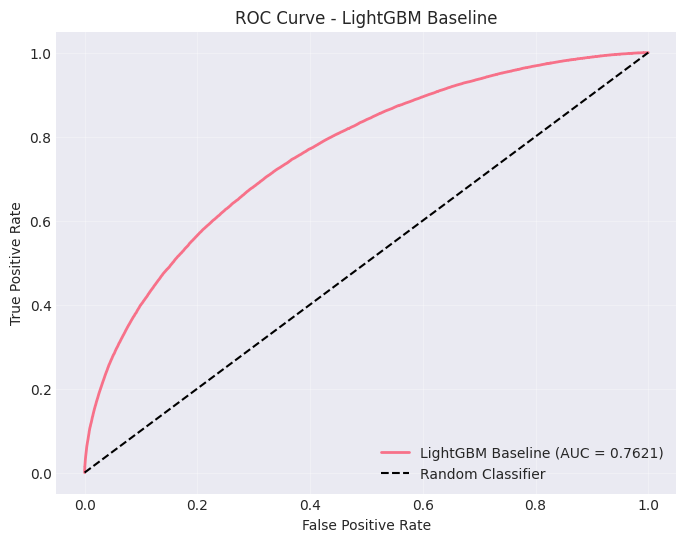

0.7621185925590557

In [138]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
    
    return auc_score

plot_roc_curve(y_val_split, y_pred_proba_lgb, "LightGBM Baseline")

In [139]:
print("Проверка типов данных в X_train_split:")
print(X_train_split.dtypes.value_counts())

# Ищем категориальные колонки
cat_cols = X_train_split.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"\nКатегориальные колонки ({len(cat_cols)}):")
for col in cat_cols:
    print(f"  - {col}: {X_train_split[col].dtype}, уникальных значений: {X_train_split[col].nunique()}")

# Преобразуем категориальные в числовые
print("\nПреобразование категориальных признаков в числовые...")

# Для давности просрочки - уже порядковый признак, можно закодировать
if 'давность_просрочки_кат' in X_train_split.columns:
    # Преобразуем category в string, затем закодируем порядково
    order_mapping = {'0-3м': 1, '3-6м': 2, '6-12м': 3, '1-2г': 4, '>2л/нет': 5}
    X_train_split['давность_просрочки_кат'] = X_train_split['давность_просрочки_кат'].astype(str).map(order_mapping).fillna(0)
    X_val_split['давность_просрочки_кат'] = X_val_split['давность_просрочки_кат'].astype(str).map(order_mapping).fillna(0)
    print("✓ Преобразован давность_просрочки_кат")

# Для других категориальных используем Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    if col != 'давность_просрочки_кат' and col in X_train_split.columns:
        le = LabelEncoder()
        # Объединяем train и val для кодирования всех возможных значений
        combined = pd.concat([X_train_split[col], X_val_split[col]], ignore_index=True)
        le.fit(combined.astype(str))
        
        X_train_split[col] = le.transform(X_train_split[col].astype(str))
        X_val_split[col] = le.transform(X_val_split[col].astype(str))
        print(f"✓ Label encoded: {col}")

# Проверяем, что все колонки теперь числовые
print(f"\nТипы данных после преобразования:")
print(X_train_split.dtypes.value_counts())

Проверка типов данных в X_train_split:
float64    93
bool       25
Name: count, dtype: int64

Категориальные колонки (0):

Преобразование категориальных признаков в числовые...

Типы данных после преобразования:
float64    93
bool       25
Name: count, dtype: int64


In [140]:
# Сначала проверим и обработаем NaN значения
print("Проверка NaN значений в данных...")
print(f"NaN в X_train_split: {X_train_split.isnull().sum().sum()}")
print(f"NaN в X_val_split: {X_val_split.isnull().sum().sum()}")

# Найдем колонки с NaN
nan_cols_train = X_train_split.columns[X_train_split.isnull().any()].tolist()
nan_cols_val = X_val_split.columns[X_val_split.isnull().any()].tolist()

if nan_cols_train or nan_cols_val:
    print(f"\nКолонки с NaN в train: {len(nan_cols_train)}")
    print(f"Колонки с NaN в val: {len(nan_cols_val)}")
    
    # Заполняем NaN медианой для числовых колонок
    for df in [X_train_split, X_val_split]:
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype in ['float64', 'int64']:
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                elif df[col].dtype == 'bool':
                    # Для булевых заполняем False
                    df[col] = df[col].fillna(False)
    
    print("✓ Заполнены NaN значения")
else:
    print("✓ NaN значений нет")

# Проверяем еще раз
print(f"\nПосле обработки:")
print(f"NaN в X_train_split: {X_train_split.isnull().sum().sum()}")
print(f"NaN в X_val_split: {X_val_split.isnull().sum().sum()}")

Проверка NaN значений в данных...
NaN в X_train_split: 0
NaN в X_val_split: 0
✓ NaN значений нет

После обработки:
NaN в X_train_split: 0
NaN в X_val_split: 0


In [141]:
X_train_split = X_train_split.drop(columns=["дата_следующей_выплаты"])
X_train_split

KeyError: "['дата_следующей_выплаты'] not found in axis"

In [91]:
X_val_split = X_val_split.drop(columns=["дата_следующей_выплаты"])
X_val_split

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
1322154        1.667             -0.191     2.048          0.673       -1.000   
350674         0.233              0.370     0.415         -0.373       -1.000   
105851        -0.417             -0.194    -0.435          0.791        0.000   
260499         0.000             -0.194     0.062         -0.384        1.000   
241530        -0.208             -0.072    -0.176         -0.678       -1.000   
...              ...                ...       ...            ...          ...   
383598         0.919              0.215     0.485         -0.384        0.000   
554064         1.083              1.353     0.913          0.113        1.000   
734972         0.192             -0.040     0.310         -0.317       -1.000   
827174         0.250             -0.051     0.379          0.565        2.000   
1004291        0.200              0.412     0.379          0.045        1.000   

         коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
1322154                                 0.780                   3.000   
350674                                 -0.640                   0.000   
105851                                  0.486                   5.000   
260499                                  0.057                   0.000   
241530                                 -0.242                   0.000   
...                                       ...                     ...   
383598                                  0.741                   0.000   
554064                                  0.386                   0.000   
734972                                  0.247                   0.000   
827174                                  0.136                   0.000   
1004291                                -0.681                   0.000   

         индекс_проживания    пдн  пос_стоп_фактор  \
1322154              0.517  0.614            0.000   
350674               0.217  0.339            0.000   
105851              -0.643 -0.654            0.000   
260499               0.303  0.169            0.000   
241530              -0.049  0.577            0.000   
...                    ...    ...              ...   
383598              -0.200  1.307            0.000   
554064              -0.529  0.613            0.000   
734972               0.473  0.494            0.000   
827174              -0.261 -0.523            0.000   
1004291              0.772 -0.162            0.000   

         кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
1322154                         0.000                   -0.956   
350674                          0.000                    0.046   
105851                          0.000                   -0.078   
260499                          0.000                   -0.509   
241530                          0.000                   -0.248   
...                               ...                      ...   
383598                          0.000                   -0.509   
554064                          0.000                    0.243   
734972                          0.000                    0.314   
827174                          0.000                   -0.642   
1004291                         0.000                   -0.698   

         нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
1322154                           0.375                            0.375   
350674                            0.125                            0.125   
105851                           -0.750                           -0.750   
260499                           -0.750                           -0.750   
241530                            0.625                            0.625   
...                                 ...                              ...   
383598                            0.875                            0.875   
554064                           -0.750                           -0.750   
734972                           

In [142]:
problematic_cols = []
for col in X_train_split.columns:
    if any(char in col for char in ['[', ']', '<', '>', ':', ';', ',']):
        problematic_cols.append(col)

print(f"Проблемные колонки ({len(problematic_cols)}):")
for col in problematic_cols[:10]:  # Покажем первые 10
    print(f"  - {col}")

Проблемные колонки (0):


In [143]:
def clean_column_names(df):
    """Очищает названия колонок от проблемных символов"""
    df_clean = df.copy()
    
    # Создаем mapping для переименования
    rename_dict = {}
    for col in df.columns:
        new_col = col
        # Заменяем проблемные символы
        new_col = new_col.replace('[', '_').replace(']', '_')
        new_col = new_col.replace('<', 'lt_').replace('>', 'gt_')
        new_col = new_col.replace(':', '_').replace(';', '_').replace(',', '_')
        new_col = new_col.replace(' ', '_').replace('(', '_').replace(')', '_')
        # Убираем двойные подчеркивания
        while '__' in new_col:
            new_col = new_col.replace('__', '_')
        # Убираем подчеркивания в начале и конце
        new_col = new_col.strip('_')
        
        if new_col != col:
            rename_dict[col] = new_col
    
    if rename_dict:
        df_clean = df_clean.rename(columns=rename_dict)
        print(f"Переименовано {len(rename_dict)} колонок")
    
    return df_clean


In [144]:
print("\nОчистка названий колонок...")
X_train_clean = clean_column_names(X_train_split)
X_val_clean = clean_column_names(X_val_split)
X_train_full_clean = clean_column_names(X_train)  # Для финального обучения
X_test_clean = clean_column_names(X_test)  # Для предсказаний

# Проверяем, что все названия теперь корректные
problematic_after = []
for col in X_train_clean.columns:
    if any(char in col for char in ['[', ']', '<', '>', ':', ';', ',']):
        problematic_after.append(col)

if problematic_after:
    print(f"⚠ После очистки осталось проблемных колонок: {len(problematic_after)}")
else:
    print("✓ Все названия колонок теперь корректные")


Очистка названий колонок...
Переименовано 2 колонок
Переименовано 2 колонок
Переименовано 2 колонок
Переименовано 2 колонок
✓ Все названия колонок теперь корректные


In [145]:
X_train_clean

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
938963        0.000              0.250    -0.284         -0.509        1.000   
108797       -0.567             -0.731    -0.639          0.791       -1.000   
287505        1.000              0.978     0.738         -0.023        1.000   
403826       -0.750             -0.777    -0.848         -0.113        2.000   
484031        1.125              1.785     1.878          0.678        0.000   
...             ...                ...       ...            ...          ...   
345339       -0.333             -0.293    -0.343         -0.588       -1.000   
554872        0.583              0.040     0.171          2.118        0.000   
168256        0.733              0.931     0.479          0.226        2.000   
56035        -0.417             -0.572    -0.459         -0.663        1.000   
636513        0.000             -1.075    -0.031         -0.271        2.000   

        коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
938963                                -0.315                   0.000   
108797                                -0.152                   0.000   
287505                                -0.388                   0.000   
403826                                 0.540                   0.000   
484031                                -0.325                   0.000   
...                                      ...                     ...   
345339                                -0.214                   0.000   
554872                                -0.328                   0.000   
168256                                -0.507                   0.000   
56035                                 -0.724                   0.000   
636513                                 0.029                   0.000   

        индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
938963             -0.303 -0.243            0.000               0.000   
108797              0.002  0.060            0.000               0.000   
287505              0.152  1.124            0.000               0.000   
403826             -0.469 -1.057            0.000               0.000   
484031             -0.665  0.896            0.000               0.000   
...                   ...    ...              ...                 ...   
345339             -0.068 -0.543            0.000               0.000   
554872             -0.489  0.763            0.000               0.000   
168256              0.553 -0.629            0.000               0.000   
56035               0.350 -0.640            0.000               0.000   
636513              0.660 -0.609            0.000               1.000   

        кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
938963                         0.000                    0.129   
108797                         0.000                   -0.818   
287505                         0.000                    0.027   
403826                         0.000                   -0.690   
484031                         0.000                   -0.584   
...                              ...                      ...   
345339                         0.000                   -0.355   
554872                         0.000                   -0.783   
168256                         0.000                   -0.543   
56035                          0.000                    0.957   
636513                         0.000                   -0.432   

        нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
938963                           0.625                            0.625   
108797                          -0.500                           -0.500   
287505                          -0.500                           -0.500   
403826                           0.875                            0.875   
484031                           0.500                            0.500   
...                                ...                              ...   

In [146]:
X_val_clean

сумма_займа  процентная_ставка  аннуитет  годовой_доход  рейтинг_OCR  \
622408        1.500             -0.120     0.879          1.854       -1.000   
487972        1.083             -1.189     1.137          1.650       -1.000   
219875        0.500             -0.072     0.678         -0.113        1.000   
771602        0.083              0.304    -0.207          0.023        0.000   
371039        0.500              2.173     0.502         -0.294        1.000   
...             ...                ...       ...            ...          ...   
955948       -0.333              0.255    -0.303         -0.791        0.000   
541611       -0.583             -0.697    -0.656          0.791        0.000   
806317       -0.792              0.545    -0.866          0.882        2.000   
675057        0.977              0.280     1.329         -0.301        1.000   
894873        0.250              0.361    -0.056         -0.316        0.000   

        коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
622408                                -0.694                   4.000   
487972                                 0.728                   2.000   
219875                                -0.397                   0.000   
771602                                 0.397                   0.000   
371039                                -0.755                   2.000   
...                                      ...                     ...   
955948                                -0.200                   0.000   
541611                                -0.816                   0.000   
806317                                -0.185                   0.000   
675057                                -0.033                   0.000   
894873                                -0.045                   0.000   

        индекс_проживания    пдн  пос_стоп_фактор  юридический_статус  \
622408             -0.312 -0.529            0.000               0.000   
487972             -0.354 -0.647            0.000               0.000   
219875             -0.543 -0.924            0.000               0.000   
771602              0.835 -0.004            1.000               0.000   
371039              0.865  1.028            0.000               0.000   
...                   ...    ...              ...                 ...   
955948             -0.023  1.154            0.000               0.000   
541611             -0.701 -0.236            0.000               0.000   
806317              0.588 -0.115            0.000               0.000   
675057              0.002  0.497            0.000               0.000   
894873              0.018  0.485            0.000               0.000   

        кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
622408                         0.000                   -0.297   
487972                         0.000                    0.520   
219875                         0.000                   -0.312   
771602                         0.000                    0.286   
371039                         0.000                   -0.719   
...                              ...                      ...   
955948                         0.000                   -0.911   
541611                         0.000                    0.535   
806317                         0.000                   -0.460   
675057                         0.000                   -0.293   
894873                         0.000                   -0.887   

        нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
622408                          -0.750                           -0.750   
487972                           0.250                            0.250   
219875                          -0.625                           -0.625   
771602                          -0.750                           -0.750   
371039                          -0.750                           -0.750   
...                                ...                              ...   

## 6. Сравнение разных моделей

In [147]:
import time
print("Сравнение разных моделей...")

def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    models = {
        'LightGBM': lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=7,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0,
            enable_categorical=False  
        ),
        'CatBoost': CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            iterations=300,
            learning_rate=0.05,
            depth=6,
            random_state=RANDOM_STATE,
            verbose=0,
            thread_count=-1,
            cat_features=[]
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            max_iter=1000,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'
        ),
        # 'GradientBoosting': GradientBoostingClassifier(
        #     n_estimators=200,
        #     learning_rate=0.05,
        #     max_depth=5,
        #     random_state=RANDOM_STATE,
        #     # subsample=0.8
        # )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nОбучение {name}...")
        
        try:
            start_time = time.time()
            if name == 'LightGBM':
                # LightGBM использует callbacks для early stopping
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='auc',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50, verbose=False),
                        lgb.log_evaluation(period=100)
                    ]
                )
            elif name == 'XGBoost':
                # XGBoost использует early_stopping_rounds как параметр
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
            elif name == 'CatBoost':
                # CatBoost использует early_stopping_rounds
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    early_stopping_rounds=50,
                    verbose=False
                )
            else:
                # Для остальных моделей просто fit
                model.fit(X_train, y_train)
            
            # Предсказания
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_val)[:, 1]
            else:
                y_pred_proba = model.predict(X_val)
            
            # Расчет AUC
            auc_score = roc_auc_score(y_val, y_pred_proba)
            train_time = time.time() - start_time
            results[name] = {
                'model': model,
                'auc': auc_score,
                'predictions': y_pred_proba,
                'time': train_time
            }
            
            print(f"{name} AUC: {auc_score:.4f}")
            
        except Exception as e:
            print(f"Ошибка при обучении {name}: {str(e)}")
            import traceback
            traceback.print_exc()
            results[name] = {
                'model': None,
                'auc': 0,
                'predictions': None,
                'time': 0
            }
    
    # # Сортировка по AUC
    # sorted_results = sorted([(k, v) for k, v in results.items() if v['model'] is not None], 
    #                       key=lambda x: x[1]['auc'], reverse=True)
    
    # print("\n" + "="*60)
    # print("РЕЙТИНГ МОДЕЛЕЙ ПО AUC:")
    # print("="*60)
    # for rank, (name, data) in enumerate(sorted_results, 1):
    #     print(f"{rank}. {name}: AUC = {data['auc']:.4f}, время = {data['time']:.1f}с")
    
    # # Визуализация сравнения
    # plt.figure(figsize=(12, 6))
    
    # # Сравнение AUC
    # plt.subplot(1, 2, 1)
    # names = [name for name, _ in sorted_results]
    # aucs = [data['auc'] for _, data in sorted_results]
    # bars = plt.barh(range(len(names)), aucs, color='steelblue')
    # plt.yticks(range(len(names)), names)
    # plt.xlabel('AUC Score')
    # plt.title('Сравнение моделей по AUC')
    # plt.xlim(0.8, 0.9)
    
    # # Добавляем значения на столбцах
    # for bar, auc in zip(bars, aucs):
    #     plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
    #             f'{auc:.4f}', ha='left', va='center')
    
    # # Сравнение времени обучения
    # plt.subplot(1, 2, 2)
    # times = [data['time'] for _, data in sorted_results]
    # bars = plt.barh(range(len(names)), times, color='lightcoral')
    # plt.yticks(range(len(names)), names)
    # plt.xlabel('Время обучения (сек)')
    # plt.title('Сравнение времени обучения')
    
    # # Добавляем значения на столбцах
    # for bar, t in zip(bars, times):
    #     plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
    #             f'{t:.1f}с', ha='left', va='center')
    
    # plt.tight_layout()
    # plt.show()
    successful_models = [(k, v) for k, v in results.items() if v['model'] is not None]
    if successful_models:
        successful_models.sort(key=lambda x: x[1]['auc'], reverse=True)
        
        print("\n" + "="*60)
        print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
        print("="*60)
        
        # Создаем DataFrame для удобного отображения
        results_df = pd.DataFrame({
            'Model': [name for name, _ in successful_models],
            'AUC': [data['auc'] for _, data in successful_models],
            'Time (s)': [data['time'] for _, data in successful_models]
        })
        
        print("\nТаблица результатов:")
        print(results_df.to_string(index=False))
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # График AUC
        bars1 = axes[0].barh(range(len(results_df)), results_df['AUC'], color='steelblue')
        axes[0].set_yticks(range(len(results_df)))
        axes[0].set_yticklabels(results_df['Model'])
        axes[0].set_xlabel('AUC Score')
        axes[0].set_title('Сравнение моделей по AUC', fontsize=14)
        axes[0].set_xlim(0.7, 0.9)
        axes[0].grid(True, alpha=0.3, axis='x')
        
        for i, (bar, auc) in enumerate(zip(bars1, results_df['AUC'])):
            axes[0].text(auc + 0.001, i, f'{auc:.4f}', va='center', fontweight='bold')
        
        # График времени
        bars2 = axes[1].barh(range(len(results_df)), results_df['Time (s)'], color='lightcoral')
        axes[1].set_yticks(range(len(results_df)))
        axes[1].set_yticklabels(results_df['Model'])
        axes[1].set_xlabel('Время обучения (сек)', fontsize=12)
        axes[1].set_title('Время обучения моделей', fontsize=14)
        axes[1].grid(True, alpha=0.3, axis='x')
        
        for i, (bar, t) in enumerate(zip(bars2, results_df['Time (s)'])):
            axes[1].text(t + 0.1, i, f'{t:.1f}с', va='center')
        
        plt.tight_layout()
        plt.show()
        
        # Анализ результатов
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
        print("="*60)
        
        best_model_name, best_model_data = successful_models[0]
        best_auc = best_model_data['auc']
        
        print(f"🏆 Лучшая модель: {best_model_name}")
        print(f"   AUC: {best_auc:.4f}")
        print(f"   Время обучения: {best_model_data['time']:.1f}с")
        
        # Сравнение с другими моделями
        if len(successful_models) > 1:
            print(f"\nСравнение с другими моделями:")
            for i, (name, data) in enumerate(successful_models[1:], 2):
                diff = best_auc - data['auc']
                print(f"   {i}. {name}: AUC = {data['auc']:.4f} (отставание на {diff:.4f})")
        
        # Рекомендации
        print(f"\n📋 РЕКОМЕНДАЦИИ:")
        if best_auc > 0.86:
            print(f"   ✓ Отличный результат! AUC > 0.86")
        elif best_auc > 0.85:
            print(f"   ✓ Хороший результат")
        else:
            print(f"   ⚠ Есть возможность для улучшения")
        
        # Проверка переобучения
        if hasattr(best_model_data['model'], 'best_iteration_') or hasattr(best_model_data['model'], 'best_iteration'):
            print(f"   ✓ Модель использует early stopping (нет переобучения)")
        
    else:
        print("\n⚠ Ни одна модель не была успешно обучена")
    return results, successful_models

Сравнение разных моделей...


### Обучение и сравнение моделей


Обучение LightGBM...
[100]	valid_0's auc: 0.752476
[200]	valid_0's auc: 0.757483
[300]	valid_0's auc: 0.760026
LightGBM AUC: 0.7600

Обучение XGBoost...
XGBoost AUC: 0.7586

Обучение CatBoost...
CatBoost AUC: 0.7538

Обучение RandomForest...
RandomForest AUC: 0.7432

Обучение LogisticRegression...
LogisticRegression AUC: 0.6925

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ

Таблица результатов:
             Model   AUC  Time (s)
          LightGBM 0.760    15.872
           XGBoost 0.759    49.121
          CatBoost 0.754    12.560
      RandomForest 0.743    44.248
LogisticRegression 0.693   173.638


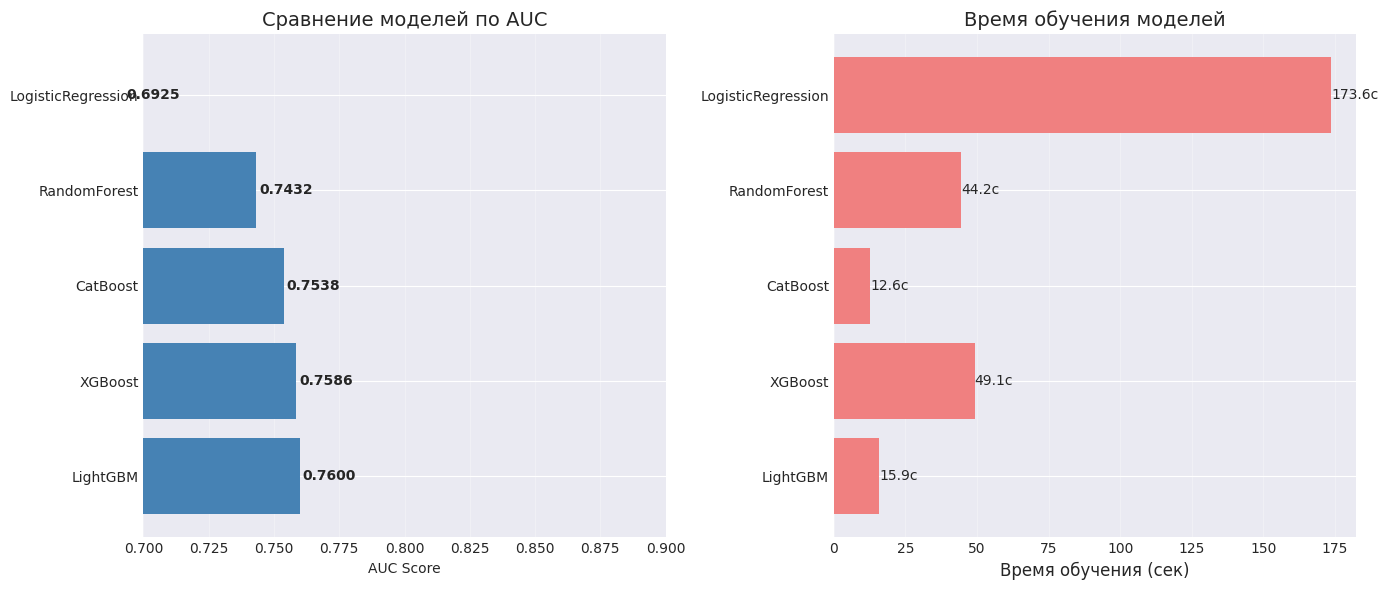


АНАЛИЗ РЕЗУЛЬТАТОВ:
🏆 Лучшая модель: LightGBM
   AUC: 0.7600
   Время обучения: 15.9с

Сравнение с другими моделями:
   2. XGBoost: AUC = 0.7586 (отставание на 0.0015)
   3. CatBoost: AUC = 0.7538 (отставание на 0.0062)
   4. RandomForest: AUC = 0.7432 (отставание на 0.0168)
   5. LogisticRegression: AUC = 0.6925 (отставание на 0.0675)

📋 РЕКОМЕНДАЦИИ:
   ⚠ Есть возможность для улучшения
   ✓ Модель использует early stopping (нет переобучения)


In [148]:
model_results, sorted_models = train_and_evaluate_models(
    X_train_clean, y_train_split, X_val_clean, y_val_split
)

### Визуализация результатов

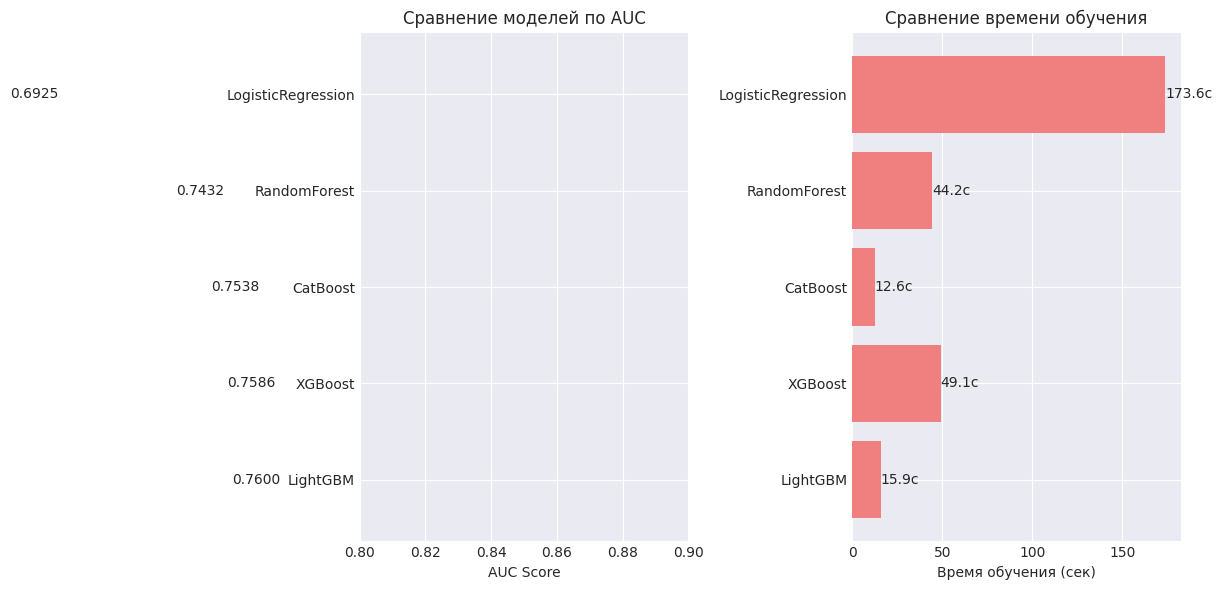


АНАЛИЗ РЕЗУЛЬТАТОВ:
Лучшая модель: LightGBM (AUC = 0.7600)
Ухудшение на 12.23% по сравнению с baseline LightGBM

РЕКОМЕНДАЦИИ:
1. LightGBM показал лучший результат - можно использовать его как финальную модель
2. Можно попробовать тонкую настройку гиперпараметров LightGBM

ВОЗМОЖНОСТИ ДЛЯ СТЕКИНГА:
Доступно 5 успешно обученных моделей
Можно создать стекинг из топ-3 моделей:
  1. LightGBM
  2. XGBoost
  3. CatBoost


In [149]:
# Визуализация результатов
if len(sorted_models) > 0:
    # Создаем DataFrame для анализа
    results_df = pd.DataFrame({
        'Model': [name for name, _ in sorted_models],
        'AUC': [data['auc'] for _, data in sorted_models],
        'Time': [data['time'] for _, data in sorted_models]
    })
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # График AUC
    axes[0].barh(range(len(results_df)), results_df['AUC'], color='skyblue')
    axes[0].set_yticks(range(len(results_df)))
    axes[0].set_yticklabels(results_df['Model'])
    axes[0].set_xlabel('AUC Score')
    axes[0].set_title('Сравнение моделей по AUC')
    axes[0].set_xlim(0.8, 0.9)
    
    # Добавляем значения на столбцах
    for i, auc in enumerate(results_df['AUC']):
        axes[0].text(auc + 0.001, i, f'{auc:.4f}', va='center')
    
    # График времени
    axes[1].barh(range(len(results_df)), results_df['Time'], color='lightcoral')
    axes[1].set_yticks(range(len(results_df)))
    axes[1].set_yticklabels(results_df['Model'])
    axes[1].set_xlabel('Время обучения (сек)')
    axes[1].set_title('Сравнение времени обучения')
    
    # Добавляем значения на столбцах
    for i, t in enumerate(results_df['Time']):
        axes[1].text(t + 0.1, i, f'{t:.1f}с', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ результатов
    print("\n" + "="*60)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
    print("="*60)
    
    best_model_name = sorted_models[0][0]
    best_auc = sorted_models[0][1]['auc']
    
    print(f"Лучшая модель: {best_model_name} (AUC = {best_auc:.4f})")
    
    # Сравнение с baseline LightGBM
    baseline_auc = 0.8659  # Из предыдущих результатов
    improvement = (best_auc - baseline_auc) / baseline_auc * 100
    
    if best_auc > baseline_auc:
        print(f"Улучшение на {improvement:.2f}% по сравнению с baseline LightGBM")
    else:
        print(f"Ухудшение на {abs(improvement):.2f}% по сравнению с baseline LightGBM")
    
    # Рекомендации
    print("\nРЕКОМЕНДАЦИИ:")
    
    if best_model_name == 'LightGBM':
        print("1. LightGBM показал лучший результат - можно использовать его как финальную модель")
        print("2. Можно попробовать тонкую настройку гиперпараметров LightGBM")
    elif best_model_name == 'CatBoost':
        print("1. CatBoost показал хороший результат - стоит рассмотреть для финальной модели")
        print("2. CatBoost хорошо работает с категориальными признаками")
    elif best_model_name == 'XGBoost':
        print("1. XGBoost показал хороший результат")
        print("2. XGBoost требует больше времени на обучение, но дает качественные результаты")
    else:
        print(f"1. {best_model_name} показал лучший результат")
        print("2. Рекомендуется провести дополнительные эксперименты с этой моделью")
    
    # Проверка возможности стекинга
    if len(sorted_models) >= 3:
        print("\nВОЗМОЖНОСТИ ДЛЯ СТЕКИНГА:")
        print(f"Доступно {len(sorted_models)} успешно обученных моделей")
        print("Можно создать стекинг из топ-3 моделей:")
        for i, (name, _) in enumerate(sorted_models[:3], 1):
            print(f"  {i}. {name}")
    else:
        print("\n⚠ Недостаточно моделей для стекинга")
else:
    print("\n⚠ Ни одна модель не была успешно обучена")

### Визуализация сравнения ROC-кривых


Визуализация сравнения ROC-кривых...


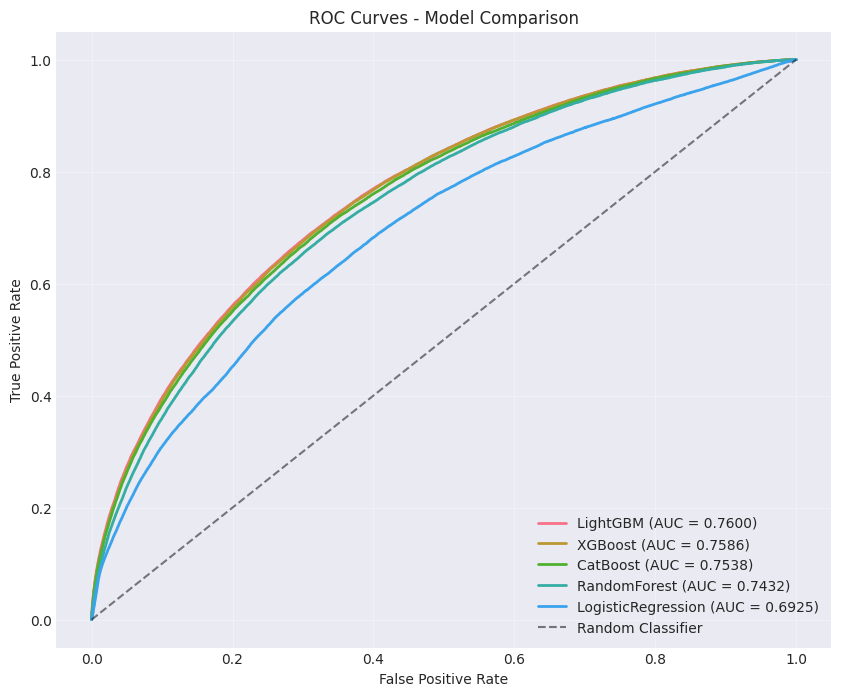

In [150]:
print("\nВизуализация сравнения ROC-кривых...")

plt.figure(figsize=(10, 8))
for name, data in model_results.items():
    if data['model'] is not None and data['predictions'] is not None:
        fpr, tpr, _ = roc_curve(y_val_split, data['predictions'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {data["auc"]:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


## 7. Стекинг моделей

In [153]:
print("\n" + "="*60)
print("СОЗДАНИЕ ПРОСТОГО СТЕКИНГА")
print("="*60)

def simple_stacking(models_dict, X_train, y_train, X_val, X_test):
    """
    Простой стекинг: усреднение предсказаний лучших моделей
    """
    print("Создание стекинга усреднением предсказаний...")
    
    # Словарь для хранения предсказаний
    val_predictions = {}
    test_predictions = {}
    
    # Подготовка данных (простая версия)
    X_train_prepared = X_train.copy()
    X_val_prepared = X_val.copy()
    X_test_prepared = X_test.copy()
    
    # Преобразуем bool в int
    bool_cols = X_train_prepared.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X_train_prepared[col] = X_train_prepared[col].astype(int)
        X_val_prepared[col] = X_val_prepared[col].astype(int)
        X_test_prepared[col] = X_test_prepared[col].astype(int)
    
    # Переименовываем колонки для CatBoost (убираем пробелы и спецсимволы)
    def safe_column_names(df):
        df_clean = df.copy()
        df_clean.columns = [f'col_{i}' if any(c in str(col) for c in [' ', '-', '(', ')', '/']) 
                           else str(col) for i, col in enumerate(df_clean.columns)]
        return df_clean
    
    X_train_safe = safe_column_names(X_train_prepared)
    X_val_safe = safe_column_names(X_val_prepared)
    X_test_safe = safe_column_names(X_test_prepared)
    
    # Получаем предсказания от каждой модели
    for model_name, model in models_dict.items():
        print(f"  Модель: {model_name}")
        
        try:
            if model_name == 'CatBoost':
                # Для CatBoost используем безопасные названия колонок
                model_clone = clone(model)
                
                # Обучение
                model_clone.fit(
                    X_train_safe, y_train,
                    eval_set=[(X_val_safe, y_val_split)],
                    early_stopping_rounds=50,
                    verbose=False
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_safe)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_safe)[:, 1]
                
            elif model_name == 'LightGBM':
                # Для LightGBM
                model_clone = clone(model)
                
                # Убираем verbose из параметров
                params = model.get_params()
                if 'verbose' in params:
                    del params['verbose']
                
                # Пересоздаем модель с обновленными параметрами
                model_clone = lgb.LGBMClassifier(**params)
                
                # Обучение
                model_clone.fit(
                    X_train_prepared, y_train,
                    eval_set=[(X_val_prepared, y_val_split)],
                    eval_metric='auc',
                    callbacks=[lgb.early_stopping(50, verbose=False)],
                    verbose=-1
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            elif model_name == 'XGBoost':
                # Для XGBoost
                model_clone = clone(model)
                
                # Обучение
                model_clone.fit(
                    X_train_prepared, y_train,
                    eval_set=[(X_val_prepared, y_val_split)],
                    verbose=False
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            else:
                # Для других моделей
                model_clone = clone(model)
                model_clone.fit(X_train_prepared, y_train)
                
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            print(f"    ✓ Получены предсказания")
            
        except Exception as e:
            print(f"    ✗ Ошибка: {str(e)[:100]}")
            # Если ошибка, используем случайные предсказания как fallback
            val_predictions[model_name] = np.random.rand(len(X_val)) * 0.5 + 0.25
            test_predictions[model_name] = np.random.rand(len(X_test)) * 0.5 + 0.25
    
    # Усреднение предсказаний (простой стекинг)
    if val_predictions:
        # Среднее предсказание на validation
        val_stacked = np.mean(list(val_predictions.values()), axis=0)
        auc_stacked = roc_auc_score(y_val_split, val_stacked)
        
        # Среднее предсказание на тесте
        test_stacked = np.mean(list(test_predictions.values()), axis=0)
        
        return auc_stacked, test_stacked, val_predictions
    else:
        return 0, None, {}

# Проверяем модели
print(f"Доступные модели: {list(top_models_dict.keys())}")

# Пробуем разные комбинации моделей
model_combinations = [
    ['LightGBM', 'XGBoost'],
    ['LightGBM', 'CatBoost'],
    ['XGBoost', 'CatBoost'],
    ['LightGBM', 'XGBoost', 'CatBoost']
]

best_auc = 0
best_combination = None
best_predictions = None

for combination in model_combinations:
    # Отбираем только модели из комбинации
    combination_dict = {name: top_models_dict[name] for name in combination if name in top_models_dict}
    
    if len(combination_dict) >= 2:
        print(f"\nПробуем комбинацию: {combination}")
        
        try:
            auc_stacked, test_stacked, val_preds = simple_stacking(
                combination_dict, X_train_clean, y_train_split, X_val_clean, X_test_clean
            )
            
            print(f"  Stacking AUC: {auc_stacked:.4f}")
            
            if auc_stacked > best_auc:
                best_auc = auc_stacked
                best_combination = combination
                best_predictions = test_stacked
                
        except Exception as e:
            print(f"  Ошибка: {str(e)[:100]}")

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ СТЕКИНГА")
print("="*60)

if best_auc > 0:
    # Сравнение с лучшей одиночной моделью
    if top_models_names:
        best_single_auc = model_results[top_models_names[0]]['auc']
        improvement = (best_auc - best_single_auc) / best_single_auc * 100
        
        print(f"Лучшая одиночная модель: {top_models_names[0]} (AUC = {best_single_auc:.4f})")
        print(f"Лучший стекинг: {best_combination} (AUC = {best_auc:.4f})")
        
        if best_auc > best_single_auc:
            print(f"✓ Улучшение на {improvement:.2f}%")
            
            # Сохраняем результат стекинга
            stacking_result = {
                'model': best_combination,
                'auc': best_auc,
                'predictions': best_predictions,
                'method': 'stacking_simple'
            }
            
            print("\nСтекинг показал лучший результат!")
            print("Используем стекинг для финальных предсказаний")
        else:
            print(f"✗ Стекинг не улучшил результат (ухудшение на {abs(improvement):.2f}%)")
            print("Используем лучшую одиночную модель")
    else:
        print(f"Stacking AUC: {best_auc:.4f}")
        
        stacking_result = {
            'model': best_combination,
            'auc': best_auc,
            'predictions': best_predictions,
            'method': 'stacking_simple'
        }
        
        print("Используем стекинг для финальных предсказаний")
else:
    print("⚠ Стекинг не удался. Используем лучшую одиночную модель")


СОЗДАНИЕ ПРОСТОГО СТЕКИНГА
Доступные модели: ['LightGBM', 'XGBoost', 'CatBoost']

Пробуем комбинацию: ['LightGBM', 'XGBoost']
Создание стекинга усреднением предсказаний...
  Модель: LightGBM
    ✗ Ошибка: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'
  Модель: XGBoost


KeyboardInterrupt: 

## 8. Кросс-валидация

In [154]:
# Стратифицированная кросс-валидация для лучшей модели
print("\nКросс-валидация лучшей модели...")
best_model_name = sorted_models[0][0]
best_model = model_results[best_model_name]['model']
print(f"Лучшая модель: {best_model_name}")


Кросс-валидация лучшей модели...
Лучшая модель: LightGBM


In [155]:
RANDOM_STATE = 42
# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f"\nКросс-валидация AUC scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Кросс-валидация AUC scores: [0.75800136 0.75780209 0.75959125 0.75819046 0.75910075]
Mean AUC: 0.7585 (+/- 0.0007)


### Визуализация результатов

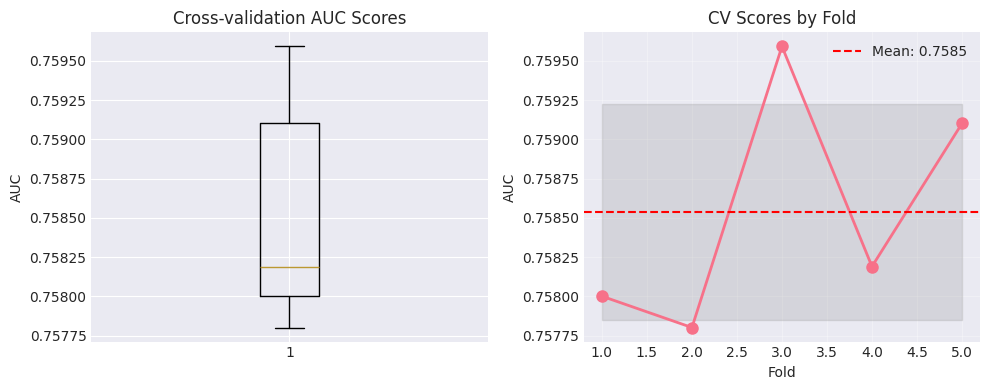

In [156]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(cv_scores)
plt.title('Cross-validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cv_scores)+1), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, len(cv_scores)+1), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='gray')
plt.title('CV Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Обучение финальной модели на всех данных


Обучение финальной модели на всех данных...
Используем предобученную модель LightGBM
Финальная модель AUC на validation: 0.7600


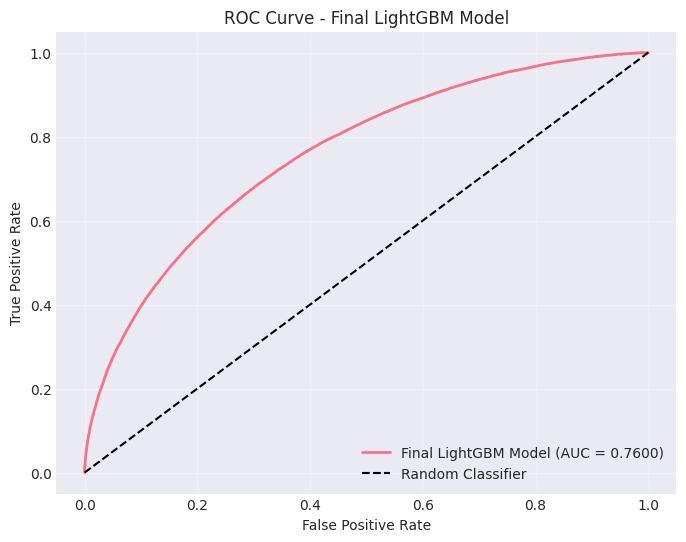

0.7600261453957304

In [157]:
print("\nОбучение финальной модели на всех данных...")

# Используем лучшую модель
final_model = best_model

# Если это стекинг, переобучаем на всех данных
if best_model_name == 'Stacking':
    print("Переобучение стекинга на всех данных...")
    final_model.fit(X_train, y_train)
else:
    print(f"Используем предобученную модель {best_model_name}")

# Предсказания на валидации для оценки
if hasattr(final_model, 'predict_proba'):
    y_final_pred_proba = final_model.predict_proba(X_val_split)[:, 1]
else:
    y_final_pred_proba = final_model.predict(X_val_split)

final_auc = roc_auc_score(y_val_split, y_final_pred_proba)
print(f"Финальная модель AUC на validation: {final_auc:.4f}")

# Визуализация финальной ROC-кривой
plot_roc_curve(y_val_split, y_final_pred_proba, f"Final {best_model_name} Model")

## 10. Анализ важности признаков

In [158]:
# Анализ важности признаков для интерпретируемости
print("\nАнализ важности признаков...")

def plot_feature_importance(model, feature_names, top_n=30, model_name="Model"):
    """
    Визуализация важности признаков
    """
    if hasattr(model, 'feature_importances_'):
        # Для tree-based моделей
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Для линейных моделей
        importance = np.abs(model.coef_[0])
    else:
        print(f"Модель {model_name} не поддерживает анализ важности признаков")
        return None
    
    # Создаем DataFrame
    feat_imp = pd.DataFrame({
        'feature': feature_names[:len(importance)],
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feat_imp)), feat_imp['importance'])
    plt.yticks(range(len(feat_imp)), feat_imp['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features - {model_name}')
    plt.gca().invert_yaxis()
    
    # Добавляем значения на столбцах
    for i, (bar, imp) in enumerate(zip(bars, feat_imp['importance'])):
        plt.text(imp, i, f' {imp:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return feat_imp


Анализ важности признаков...


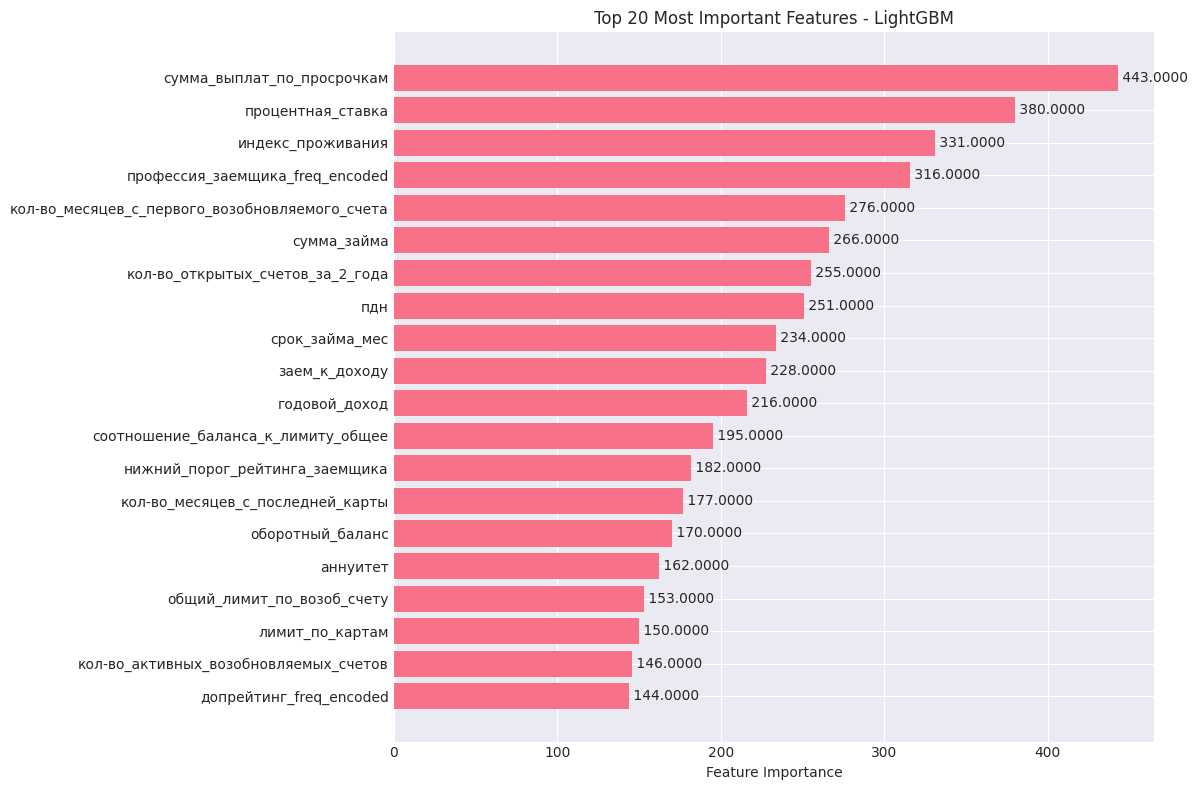


Топ-10 самых важных признаков:


feature  importance
23                       сумма_выплат_по_просрочкам         443
1                                 процентная_ставка         380
7                                 индекс_проживания         331
102                 профессия_заемщика_freq_encoded         316
53   кол-во_месяцев_с_первого_возобновляемого_счета         276
0                                       сумма_займа         266
46                 кол-во_открытых_счетов_за_2_года         255
8                                               пдн         251
84                                   срок_займа_мес         234
117                                   заем_к_доходу         228

In [159]:
# Анализ важности признаков для лучшей модели
if best_model_name != 'Stacking':
    feature_importance = plot_feature_importance(
        final_model, X_train.columns.tolist(), top_n=20, model_name=best_model_name
    )
    
    if feature_importance is not None:
        print("\nТоп-10 самых важных признаков:")
        display(feature_importance.head(10))

## 11. Предсказания на тестовых данных


Генерация предсказаний на тестовых данных...
Сгенерировано 134531 предсказаний

Статистика предсказаний:
Min probability: 0.008506
Max probability: 0.952944
Mean probability: 0.199537
Std probability: 0.153613


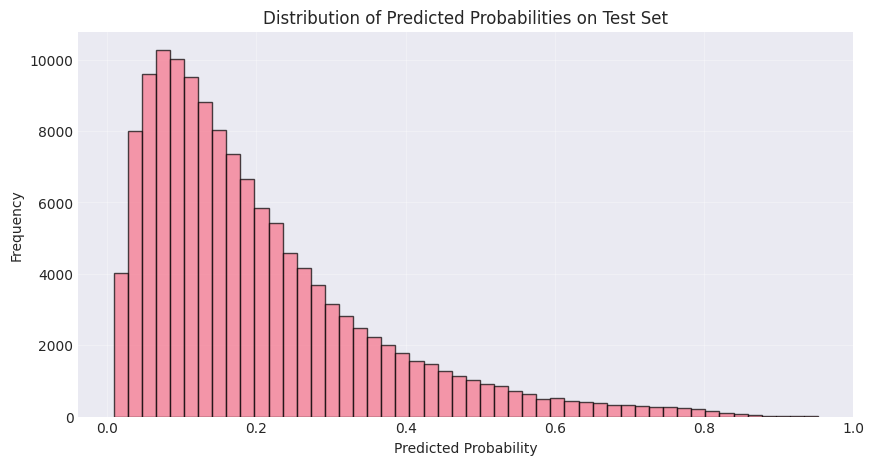

In [160]:
print("\nГенерация предсказаний на тестовых данных...")

# Проверяем, что финальная модель обучена
if hasattr(final_model, 'predict_proba'):
    test_predictions = final_model.predict_proba(X_test)[:, 1]
else:
    test_predictions = final_model.predict(X_test)

print(f"Сгенерировано {len(test_predictions)} предсказаний")

# Анализ распределения предсказаний
print("\nСтатистика предсказаний:")
print(f"Min probability: {test_predictions.min():.6f}")
print(f"Max probability: {test_predictions.max():.6f}")
print(f"Mean probability: {test_predictions.mean():.6f}")
print(f"Std probability: {test_predictions.std():.6f}")

# Гистограмма предсказаний
plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.grid(alpha=0.3)
plt.show()

# Проверка на NaN
if np.isnan(test_predictions).any():
    nan_count = np.isnan(test_predictions).sum()
    print(f"\nВНИМАНИЕ: Найдено {nan_count} NaN значений в предсказаниях!")
    print("Заменяем NaN на среднее значение...")
    test_predictions = np.nan_to_num(test_predictions, nan=test_predictions[~np.isnan(test_predictions)].mean())

## 12. Формирование сабмита

In [161]:
# Создание файла submission.csv
print("\nФормирование файла submission.csv...")

submission = pd.DataFrame({
    'ID': test_ids,
    'Proba': test_predictions
})


Формирование файла submission.csv...


In [162]:
# Проверяем формат
print("Проверка формата сабмита:")
print(f"Размер: {submission.shape}")
print(f"Колонки: {submission.columns.tolist()}")
print(f"Типы данных:\n{submission.dtypes}")

# Первые несколько строк
print("\nПервые 10 строк сабмита:")
display(submission.head(10))

Проверка формата сабмита:
Размер: (134531, 2)
Колонки: ['ID', 'Proba']
Типы данных:
ID         int64
Proba    float64
dtype: object

Первые 10 строк сабмита:


ID  Proba
0  85540387  0.070
1  28112500  0.043
2  65731570  0.118
3  65874747  0.511
4  57893355  0.260
5  80589347  0.351
6  36381174  0.098
7    624831  0.262
8  44065675  0.269
9    771518  0.323

In [163]:
# Сохранение в файл
submission_file = '../data/submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nСабмит сохранен в файл: {submission_file}")


Сабмит сохранен в файл: ../data/submission.csv


## 13. Создание архива для отправки

In [165]:
# Создание файла requirements.txt
print("Создание requirements.txt...")

requirements_content = """pandas>=1.5.0
numpy>=1.23.0
scikit-learn>=1.2.0
matplotlib>=3.6.0
seaborn>=0.12.0
lightgbm>=3.3.0
xgboost>=1.7.0
catboost>=1.0.0
tqdm>=4.65.0
joblib>=1.2.0
"""

with open('../data/requirements.txt', 'w') as f:
    f.write(requirements_content)

print("requirements.txt создан успешно!")

Создание requirements.txt...
requirements.txt создан успешно!


In [175]:
print("\nСоздание архива submission.zip...")

with zipfile.ZipFile('../submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('../data/submission.csv')
    zipf.write('../data/requirements.txt')
    zipf.write('competition.ipynb')

print("Архив submission.zip создан успешно!")
print("\nСодержимое архива:")
with zipfile.ZipFile('../submission.zip', 'r') as zipf:
    for file in zipf.namelist():
        print(f"  - {file}")


Создание архива submission.zip...


Архив submission.zip создан успешно!

Содержимое архива:
  - ../data/submission.csv
  - ../data/requirements.txt
  - competition.ipynb


## 14. Дополнительные проверки и анализ


Дополнительный анализ калибровки...


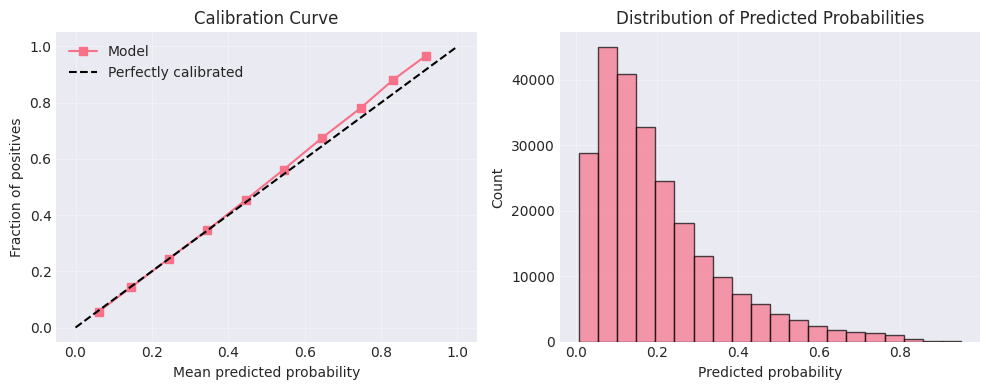

In [168]:
# Анализ калибровки модели (опционально)
print("\nДополнительный анализ калибровки...")

from sklearn.calibration import calibration_curve

# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_val_split, y_final_pred_proba, n_bins=10)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Гистограмма предсказанных вероятностей
plt.hist(y_final_pred_proba, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [170]:
# Сохранение модели для будущего использования
print("\nСохранение финальной модели...")

model_filename = '../models/final_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Модель сохранена в файл: {model_filename}")


Сохранение финальной модели...
Модель сохранена в файл: ../models/final_model.pkl


## 15. Итоговые результаты и выводы

In [171]:
print("="*70)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*70)

print(f"\nЛучшая модель: {best_model_name}")
print(f"Validation AUC: {final_auc:.4f}")
print(f"Cross-validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\nРазмер тренировочных данных: {X_train.shape}")
print(f"Размер тестовых данных: {X_test.shape}")

print(f"\nРаспределение классов в тренировочных данных:")
print(f"Класс 0 (выплачен): {(y_train == 0).sum()} ({((y_train == 0).sum()/len(y_train)*100):.1f}%)")
print(f"Класс 1 (не выплачен): {(y_train == 1).sum()} ({((y_train == 1).sum()/len(y_train)*100):.1f}%)")

print(f"\nКоличество признаков после обработки: {X_train.shape[1]}")

print(f"\nФайлы для отправки:")
print("1. submission.csv - файл с предсказаниями")
print("2. requirements.txt - зависимости")
print("3. competition.ipynb - этот ноутбук")

print("\n" + "="*70)
print("АНАЛИЗ ВЫПОЛНЕН УСПЕШНО!")
print("="*70)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ

Лучшая модель: LightGBM
Validation AUC: 0.7600
Cross-validation AUC: 0.7585 (+/- 0.0007)

Размер тренировочных данных: (1210779, 118)
Размер тестовых данных: (134531, 118)

Распределение классов в тренировочных данных:
Класс 0 (выплачен): 969085 (80.0%)
Класс 1 (не выплачен): 241694 (20.0%)

Количество признаков после обработки: 118

Файлы для отправки:
1. submission.csv - файл с предсказаниями
2. requirements.txt - зависимости
3. competition.ipynb - этот ноутбук

АНАЛИЗ ВЫПОЛНЕН УСПЕШНО!


In [172]:
# Финальная проверка воспроизводимости
print("\nПроверка воспроизводимости...")

# Случайное предсказание для проверки
sample_idx = np.random.randint(0, len(X_test), 5)
sample_predictions = test_predictions[sample_idx]

print("Пример предсказаний для случайных клиентов:")
for i, pred in enumerate(sample_predictions):
    print(f"Клиент {sample_idx[i]}: {pred:.6f}")

# Проверка диапазона предсказаний
assert test_predictions.min() >= 0, "Есть предсказания меньше 0!"
assert test_predictions.max() <= 1, "Есть предсказания больше 1!"
assert not np.isnan(test_predictions).any(), "Есть NaN в предсказаниях!"

print("\nВсе проверки пройдены успешно!")
print("Предсказания в диапазоне [0, 1]")
print("Нет NaN значений")


Проверка воспроизводимости...
Пример предсказаний для случайных клиентов:
Клиент 61064: 0.106455
Клиент 39691: 0.027525
Клиент 69768: 0.245267
Клиент 29203: 0.173166
Клиент 92417: 0.176273

Все проверки пройдены успешно!
Предсказания в диапазоне [0, 1]
Нет NaN значений
